In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
#   LEARN FCN00
#

from __future__ import print_function
import argparse
import os

import numpy as np
import pickle
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, AveragePooling2D
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray, img_dice_coeff, get_center
from fname_func import load_fnames, make_fnames

# MAXPOOLING
from create_fcn import create_fcn01, create_fcn00
# AVERAGE POOLING
#from create_fcn_avpool import create_fcn01,create_fcn00

np.random.seed(2016)

/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#
#  MAIN STARTS FROM HERE
#
if __name__ == '__main__':
    
    target_size = (224, 224)
    dpath_this = './'
    # dname_checkpoints = 'checkpoints_fcn00_avpool.augumented'
    dname_checkpoints = 'checkpoints_fcn00.augumented_2'
    # dname_checkpoints_fcn01 = 'checkpoints_fcn01_avpool'
    dname_checkpoints_fcn01 = 'checkpoints_fcn01'
    dname_outputs = 'outputs'
    fname_architecture = 'architecture.json'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = "history.pkl"

    # モデルを作成
    print('creating model fcn00...')
    model_fcn00 = create_fcn00(target_size)

creating model fcn00...


In [9]:
    #
    # Test Gi4e data
    #
    fnames = load_fnames('gi4e.left/list_files.txt')
    [fpaths_xs_test,fpaths_ys_test] = make_fnames(fnames,'gi4e.left/','gi4e.left/','')
    
    X_test = load_imgs_asarray(fpaths_xs_test, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    
    # トレーニング時に計算した平均・標準偏差をロード    
    print('loading mean and standard deviation from ' + fname_stats + '...')
    stats = np.load(dname_checkpoints + '/' + fname_stats)
    mean = stats['mean']
    std = stats['std']
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    for i in range(3):
        X_test[:, i] = (X_test[:, i] - mean[i]) / std[i]
    print('==> done')

loading mean and standard deviation from stats01.npz...
==> mean: [126.17433  90.78752  78.74256]
==> std : [61.172367 47.73529  52.325943]
==> done


In [10]:
    from PIL import Image
    import matplotlib.pyplot as plt

    # 学習済みの重みをロード
    epoch = 200
    fname_weights = 'model_weights_%02d.h5'%(epoch)
    fpath_weights = os.path.join(dname_checkpoints, fname_weights)
    model_fcn00.load_weights(fpath_weights)
    print('==> done')

    # テストを開始
    outputs = model_fcn00.predict(X_test)

==> done


In [11]:
    # 出力を画像として保存
    dname_outputs = './outputs.gi4e-left/'
    if not os.path.isdir(dname_outputs):
        print('create directory: %s'%(dname_outputs))
        os.mkdir(dname_outputs)

    print('saving outputs as images...')
    n = 0
    for i, array in enumerate(outputs):
        #array = np.where(array > 0.1, 1, 0) # 二値に変換
        #array = array.astype(np.float)
        formatted = (array[0]*255.0/np.max(array[0])).astype('uint8')
        #img_out = array_to_img(array, dim_ordering)
        img_out = Image.fromarray(formatted)
        fpath_out = os.path.join(dname_outputs, "%05d.png"%(n))
        img_out.save(fpath_out)
        #cv2.imwrite(fpath_out,array[0])
        n = n + 1

    print('==> done')

create directory: ./outputs.gi4e-left/
saving outputs as images...
==> done


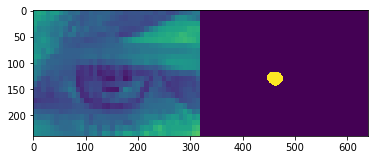

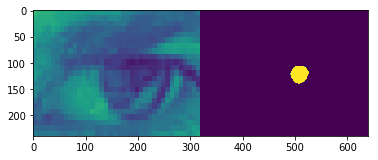

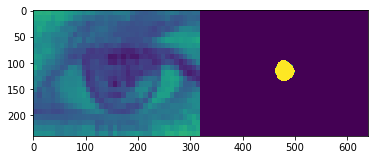

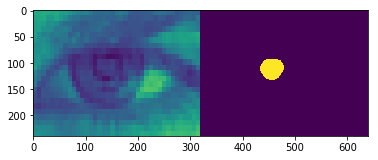

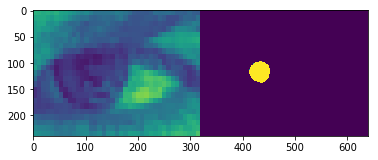

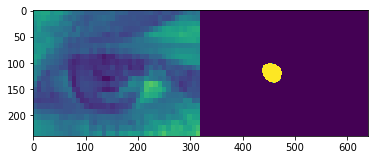

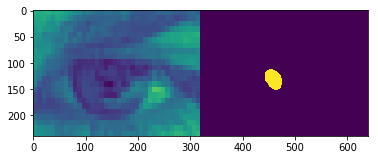

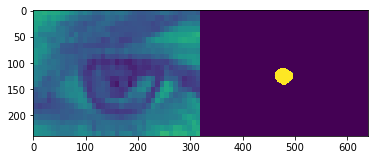

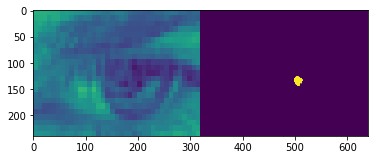

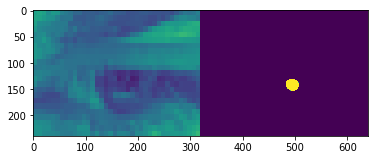

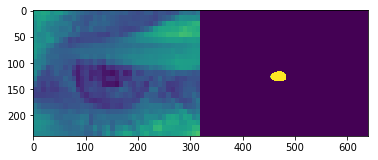

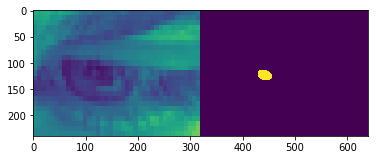

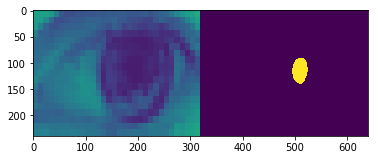

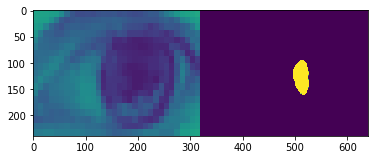

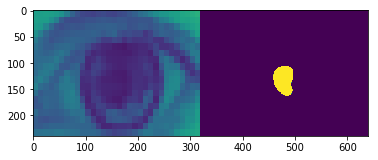

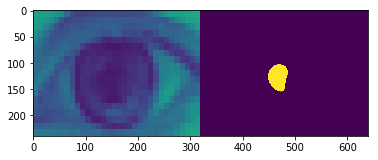

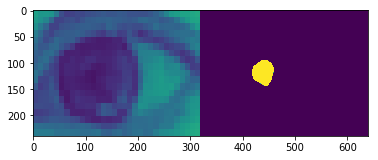

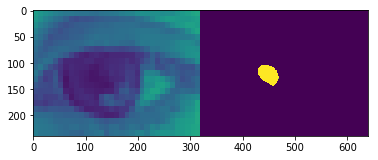

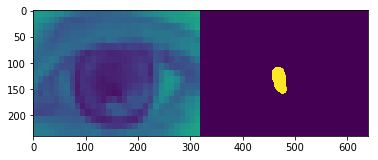

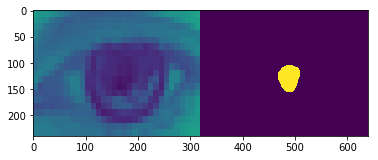

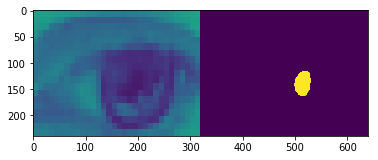

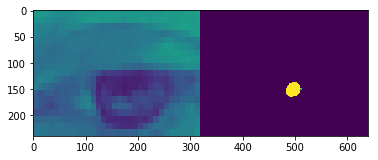

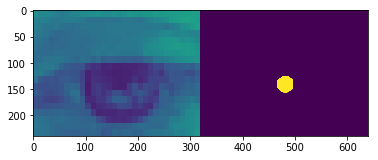

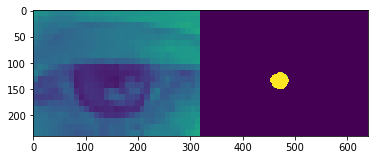

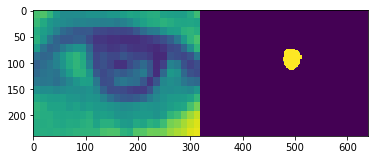

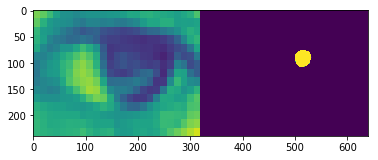

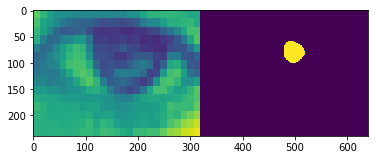

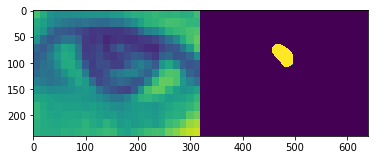

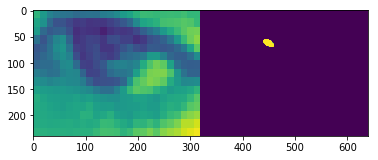

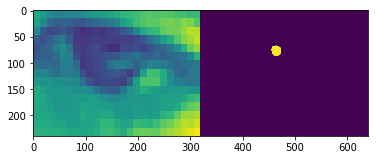

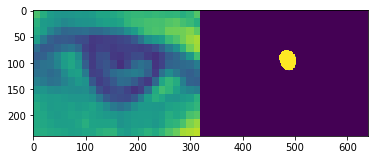

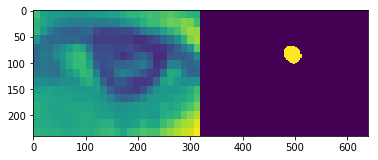

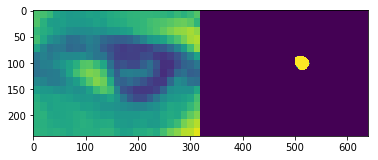

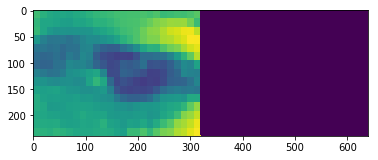

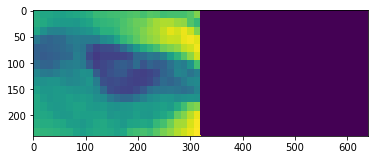

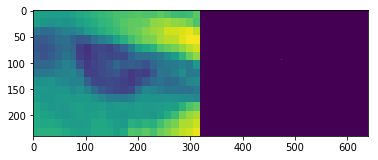

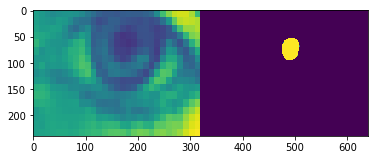

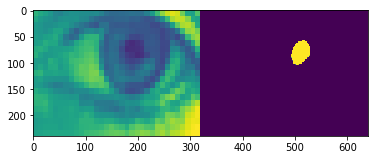

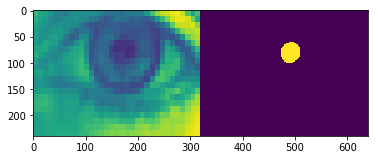

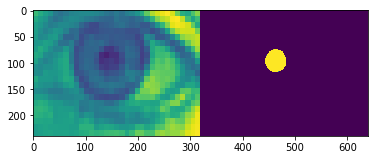

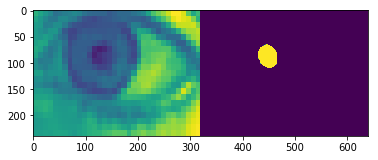

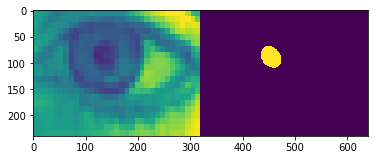

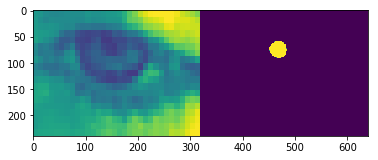

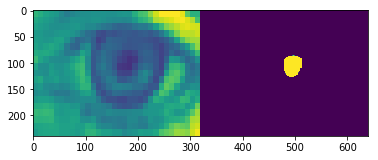

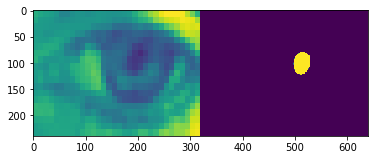

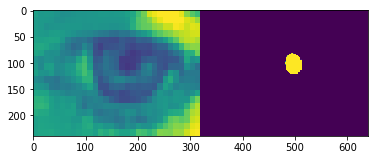

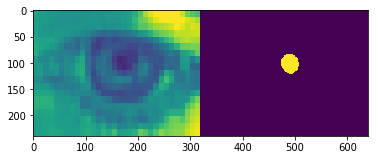

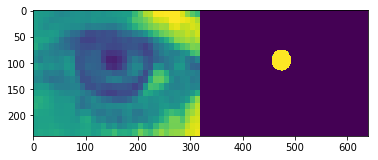

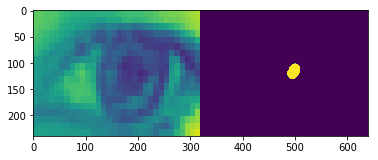

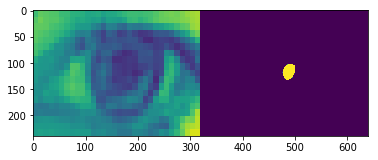

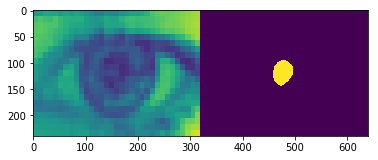

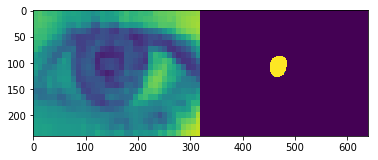

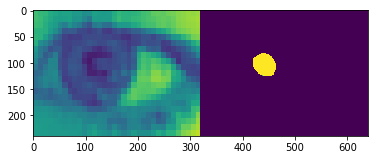

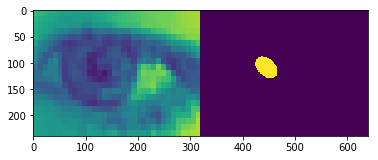

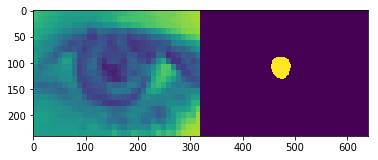

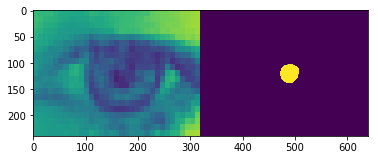

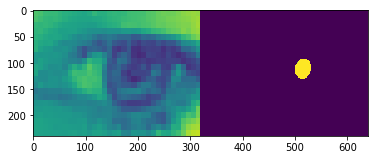

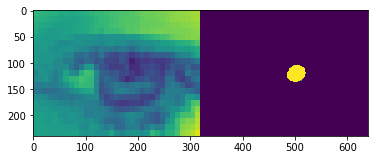

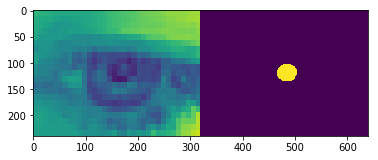

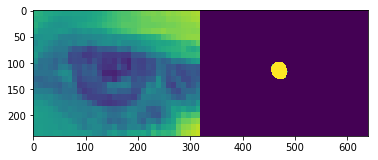

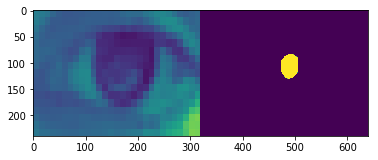

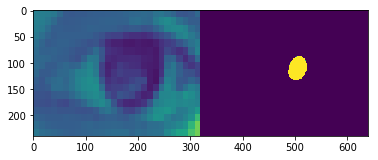

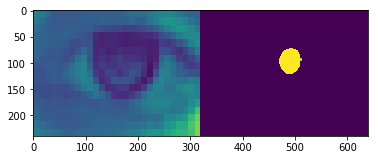

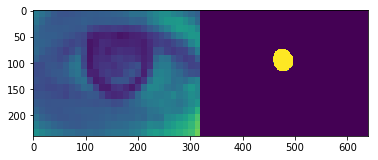

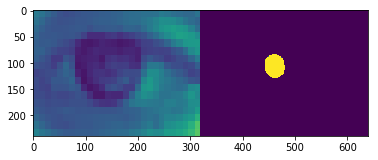

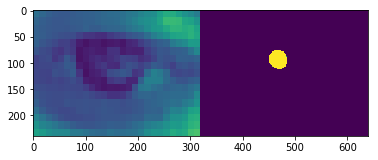

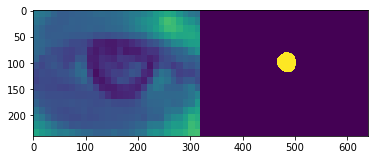

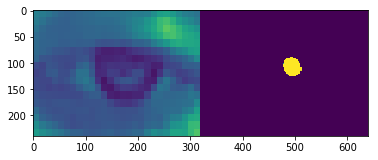

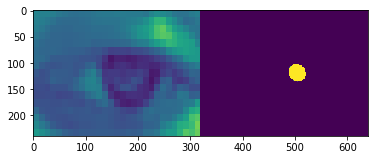

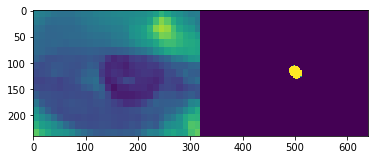

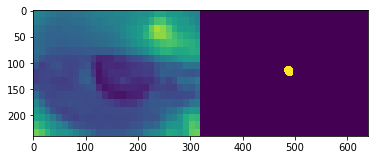

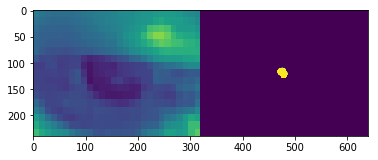

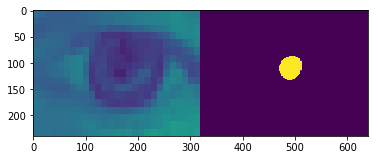

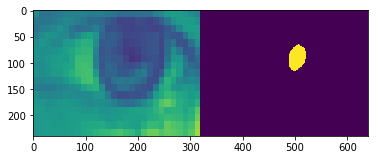

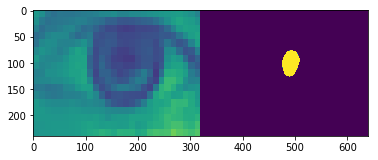

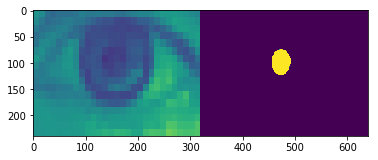

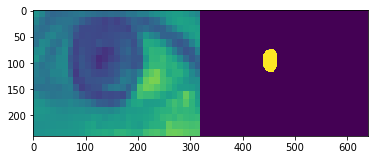

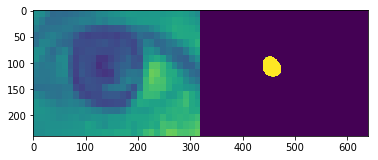

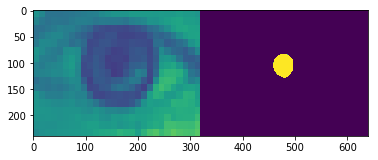

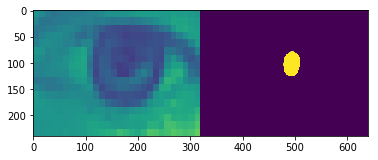

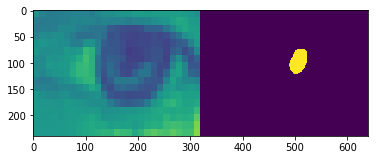

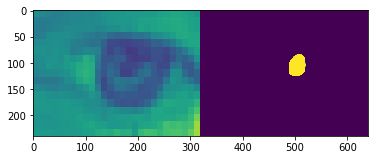

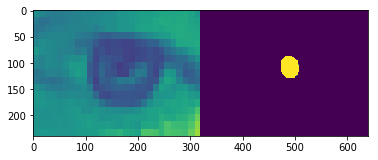

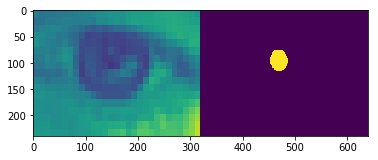

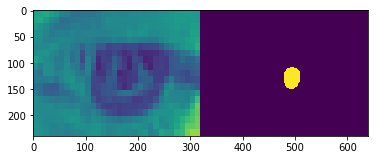

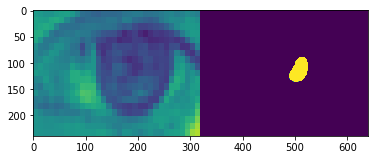

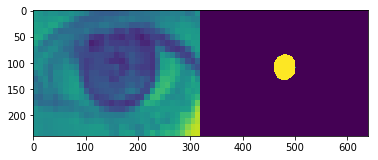

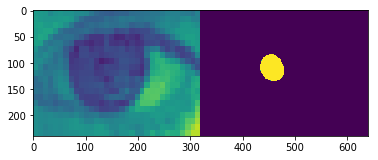

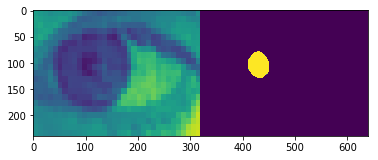

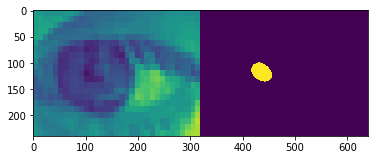

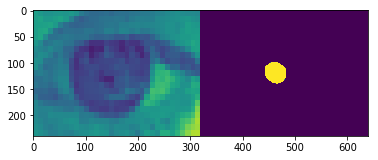

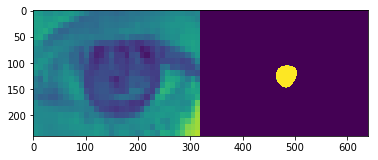

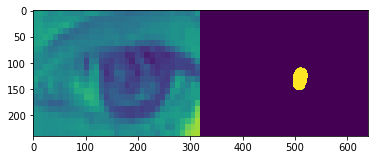

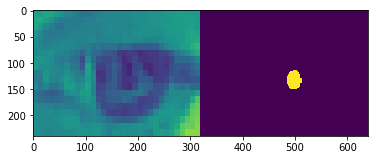

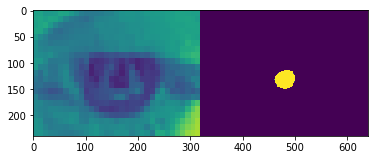

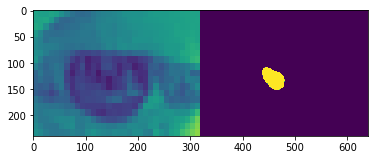

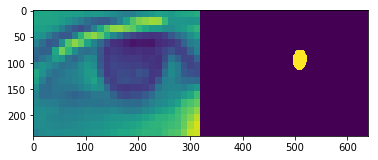

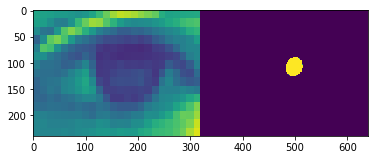

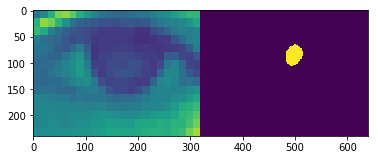

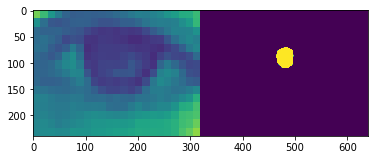

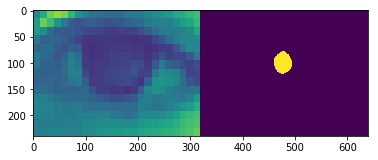

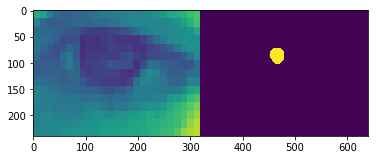

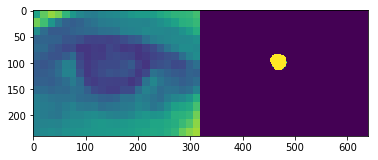

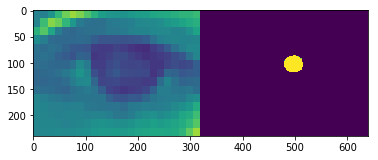

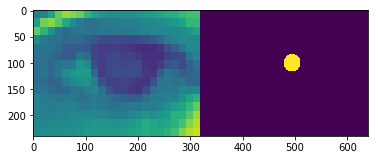

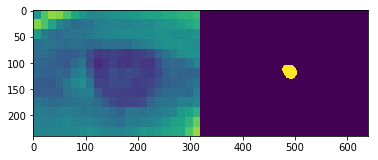

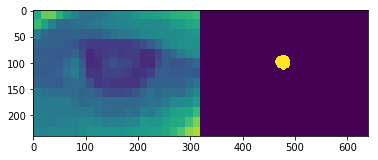

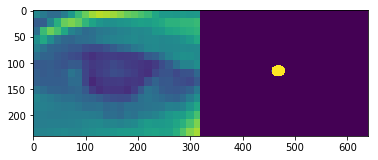

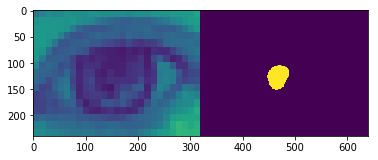

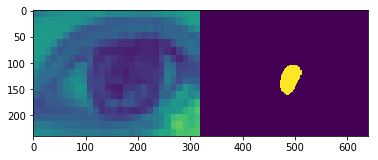

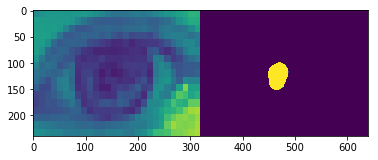

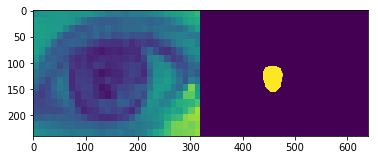

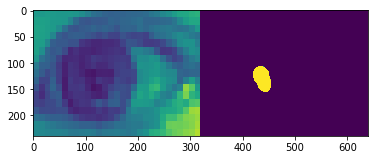

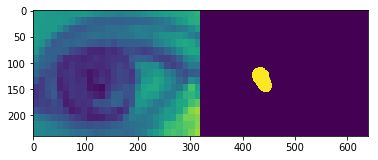

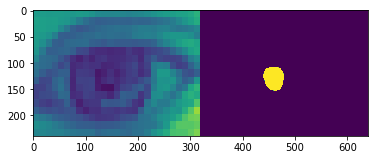

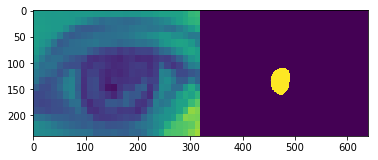

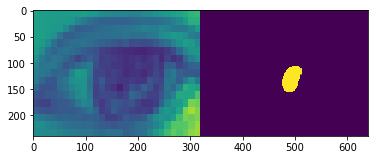

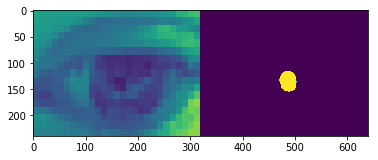

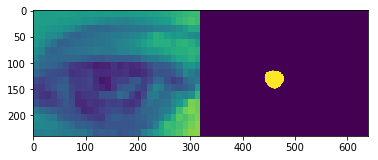

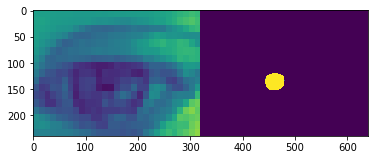

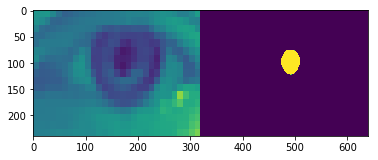

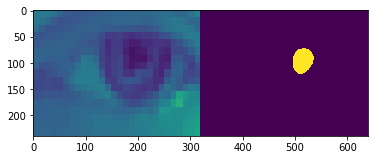

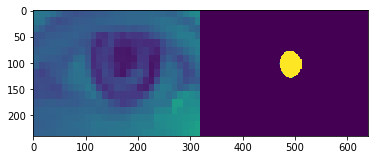

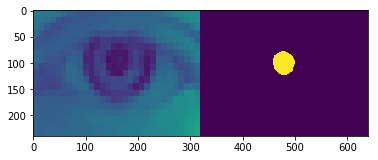

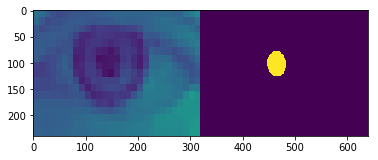

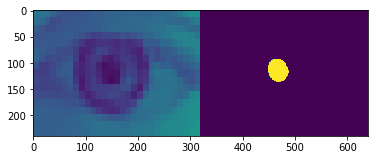

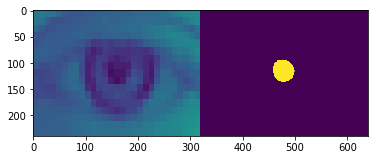

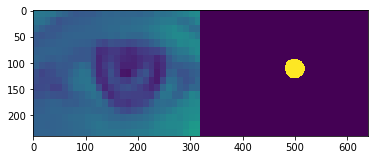

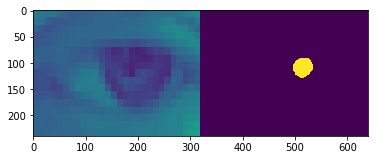

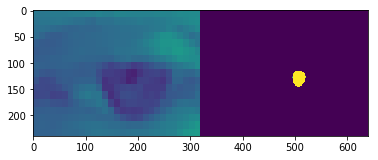

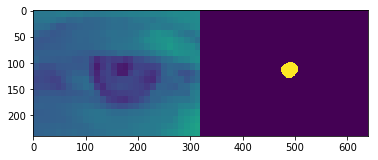

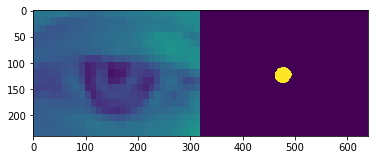

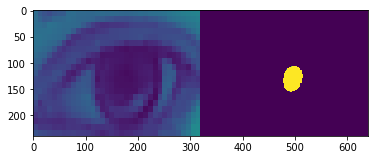

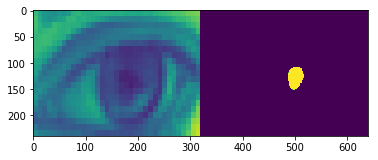

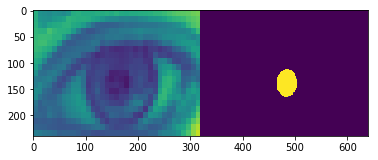

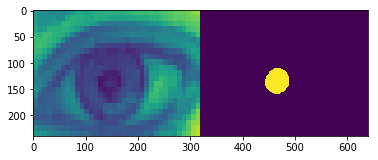

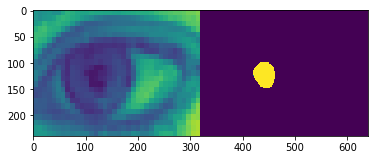

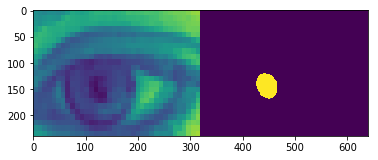

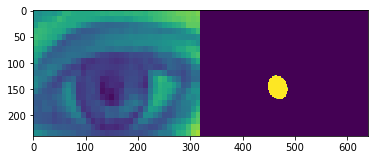

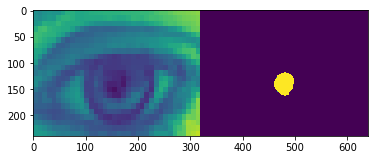

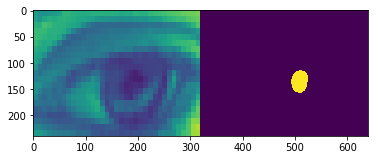

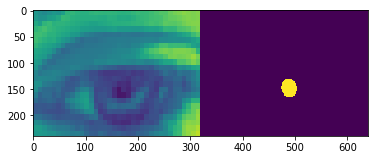

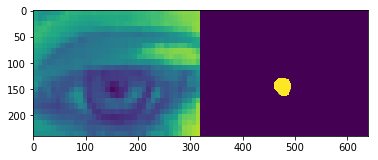

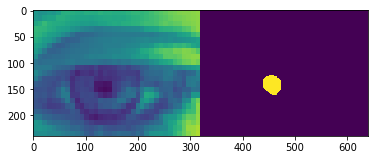

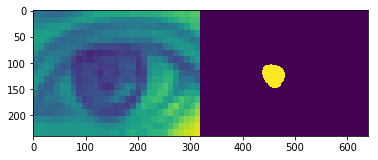

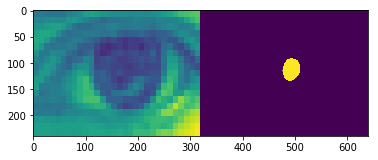

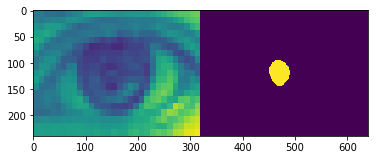

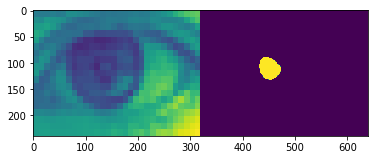

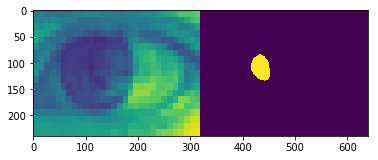

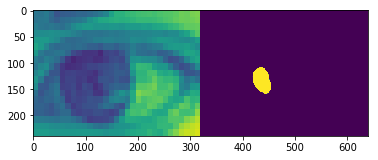

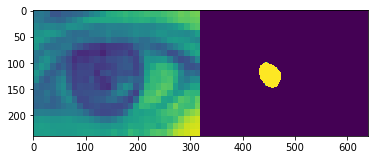

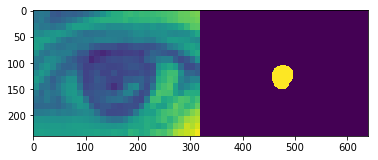

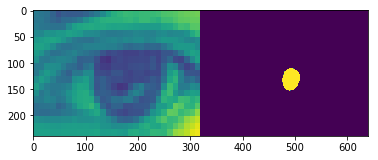

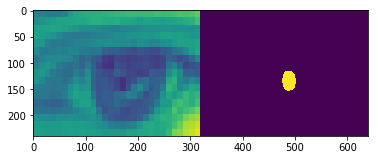

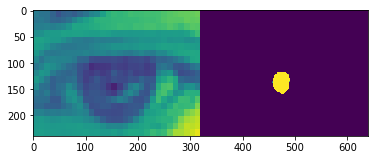

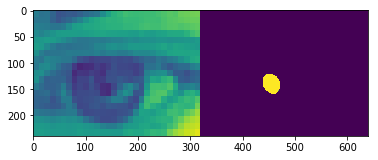

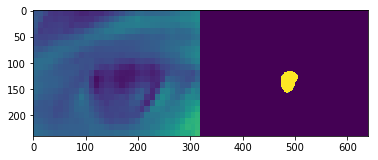

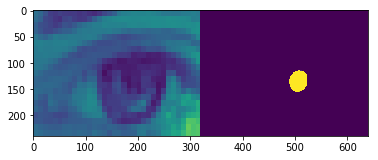

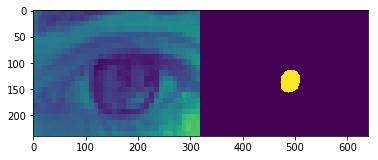

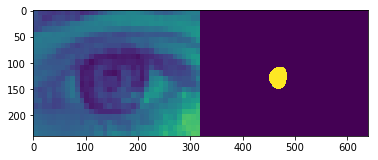

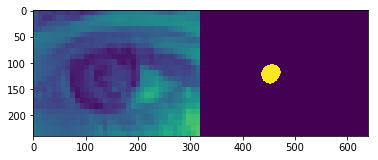

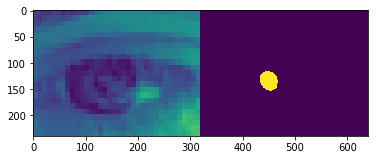

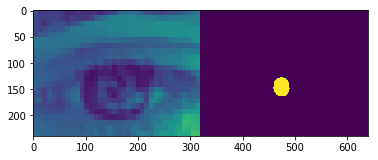

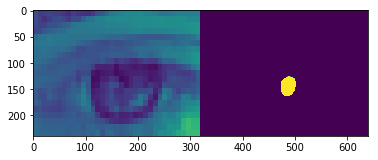

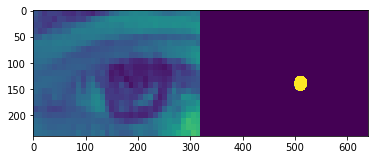

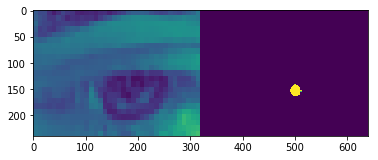

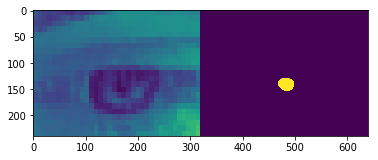

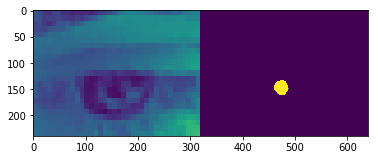

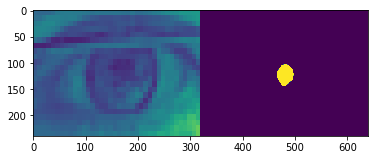

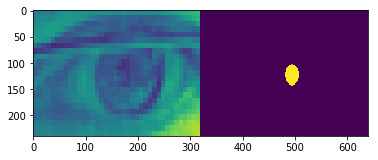

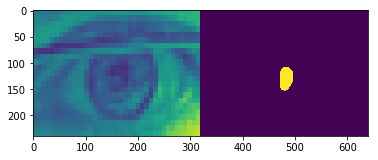

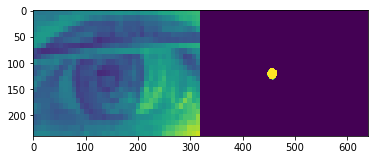

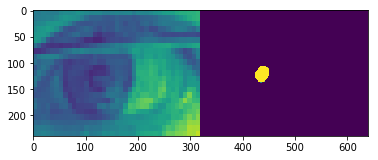

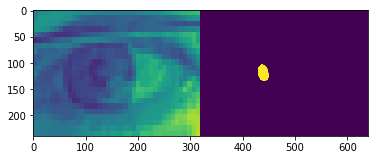

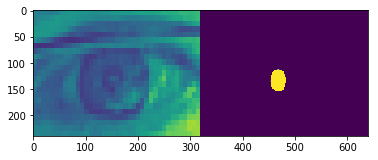

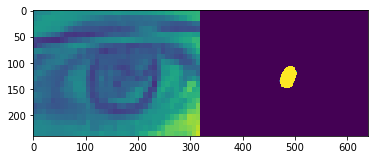

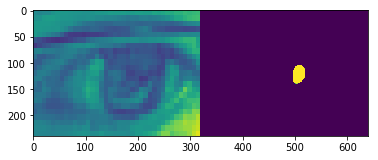

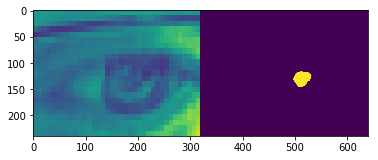

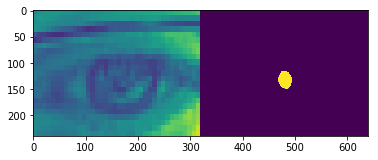

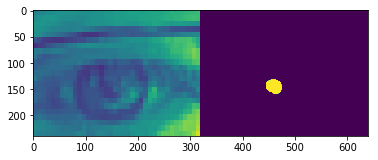

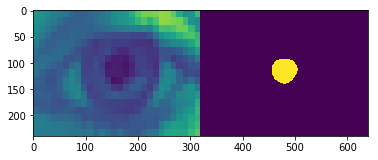

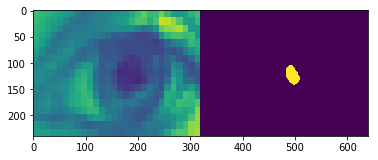

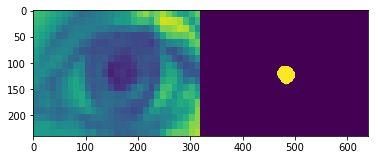

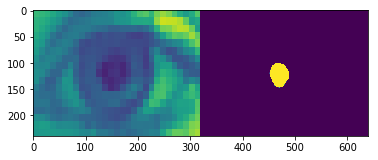

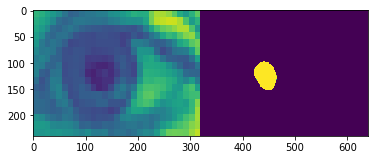

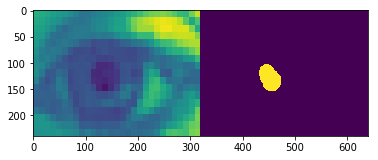

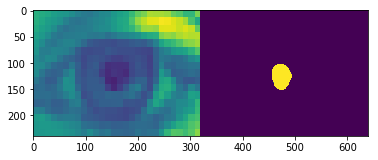

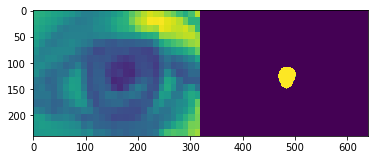

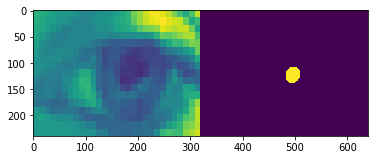

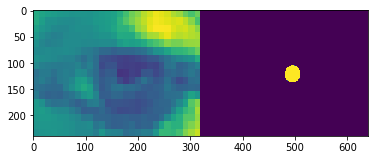

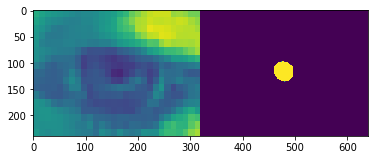

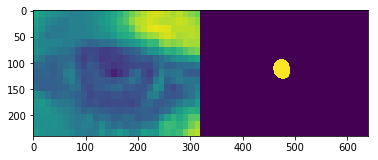

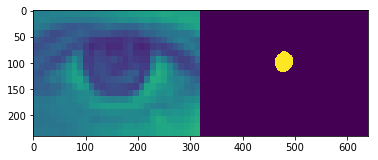

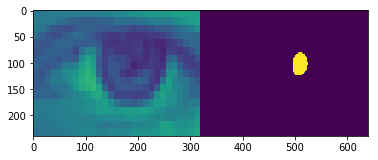

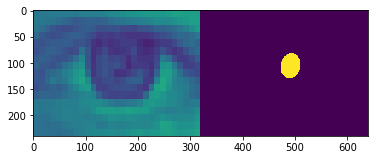

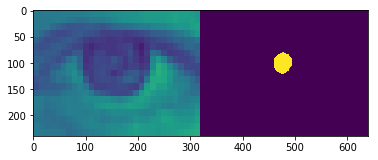

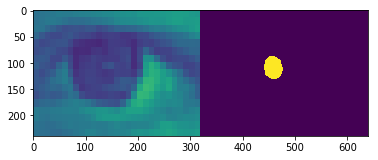

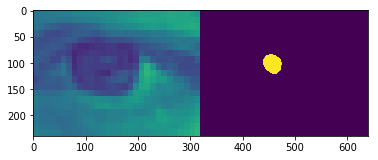

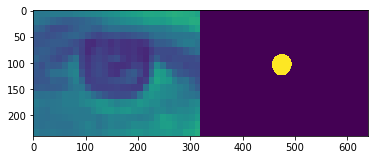

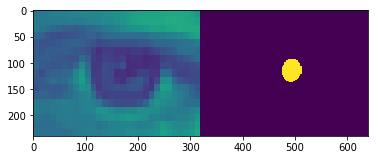

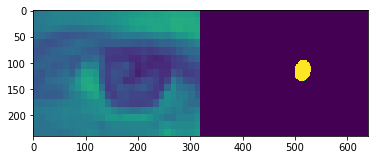

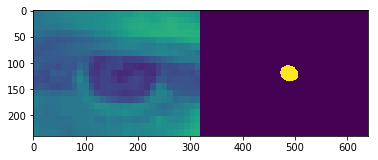

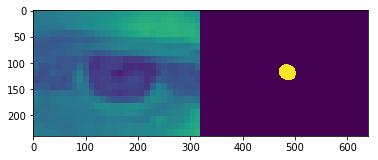

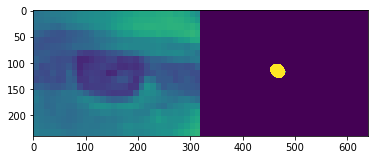

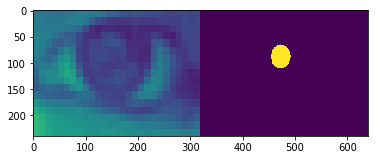

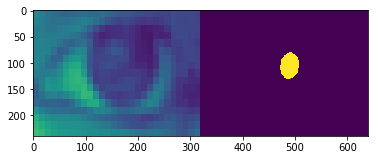

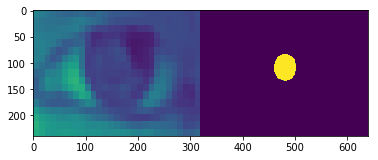

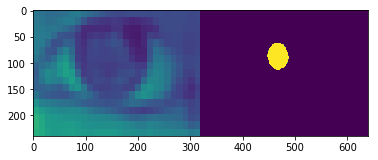

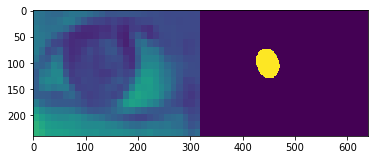

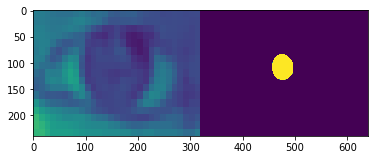

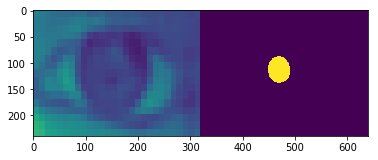

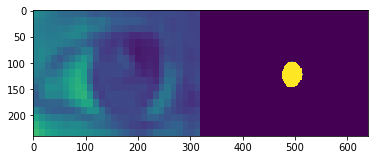

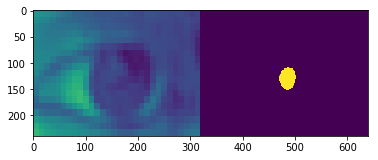

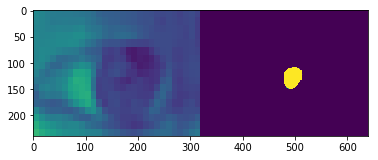

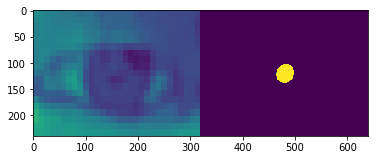

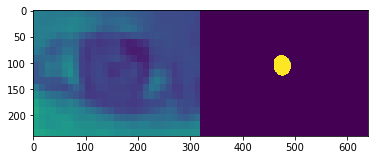

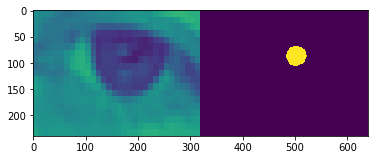

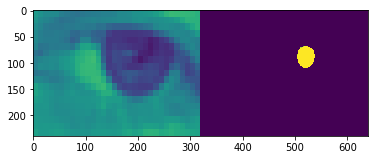

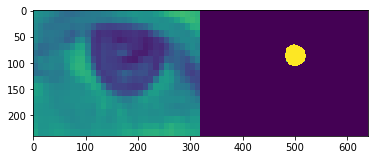

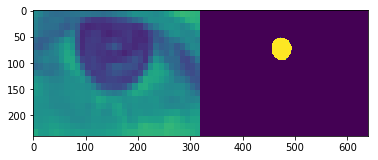

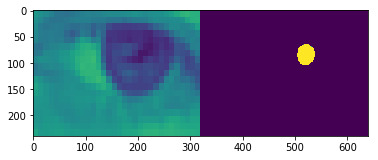

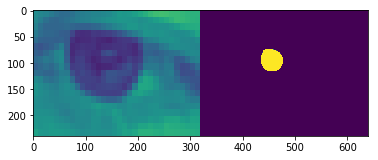

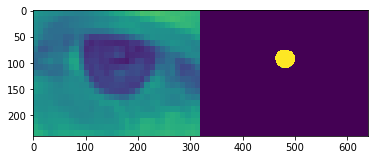

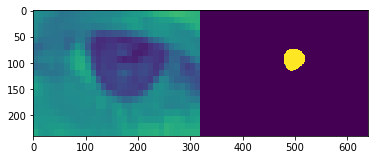

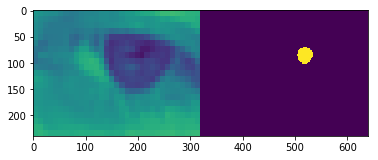

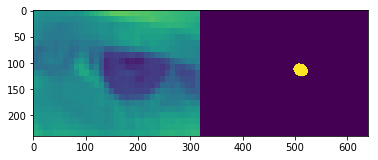

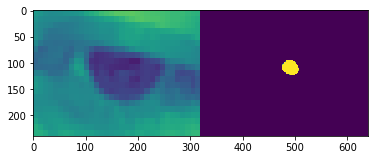

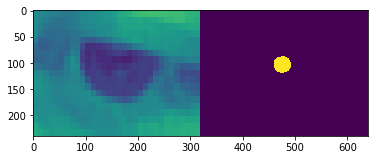

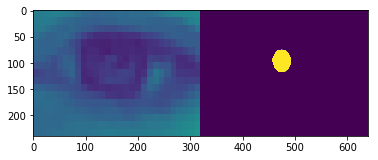

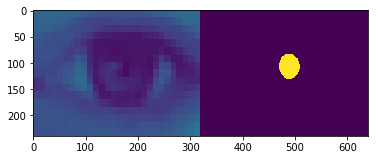

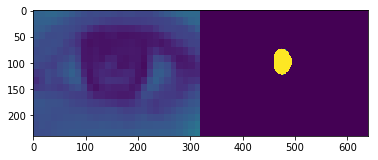

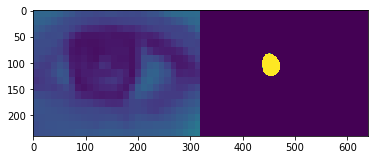

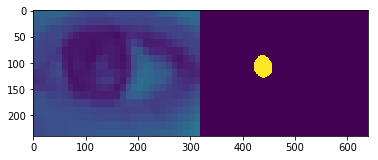

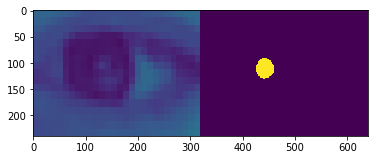

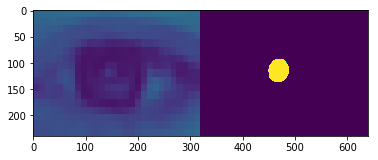

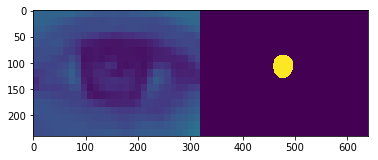

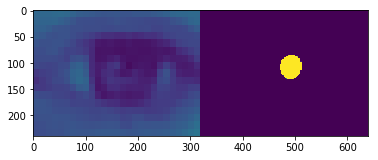

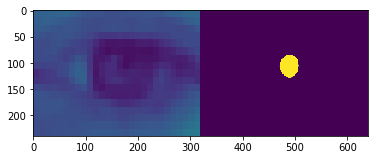

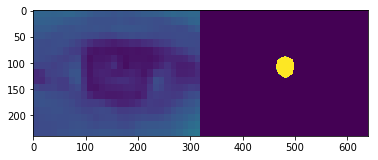

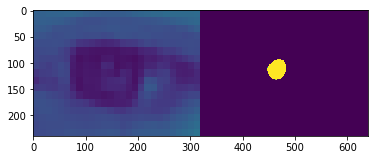

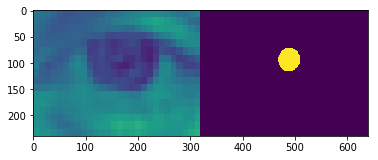

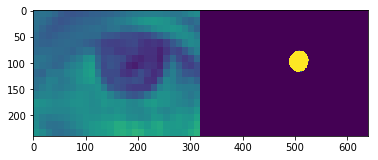

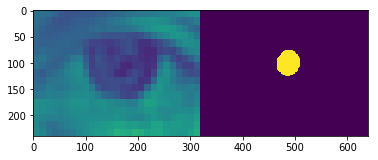

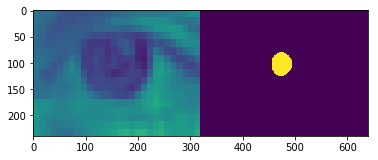

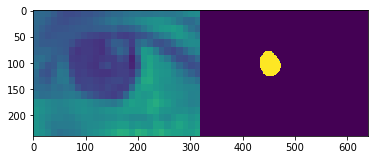

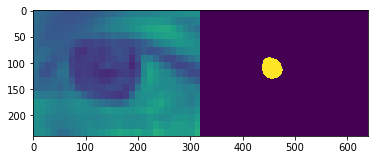

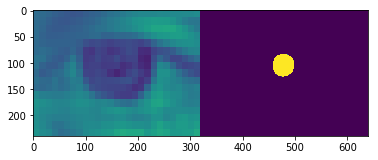

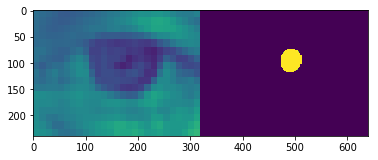

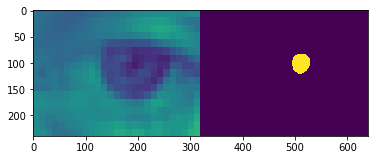

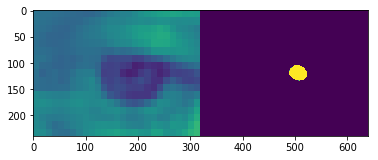

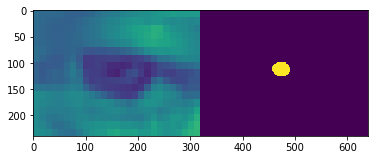

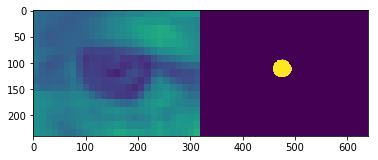

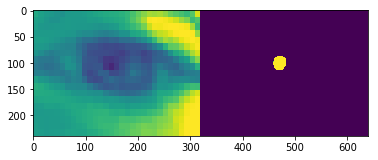

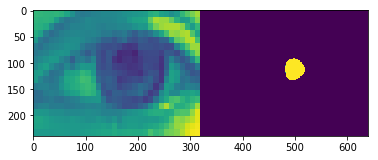

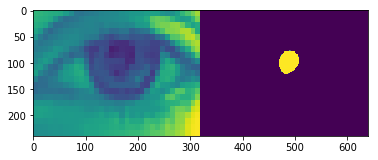

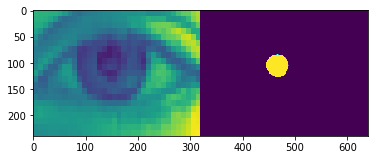

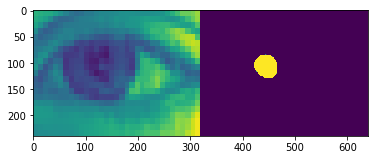

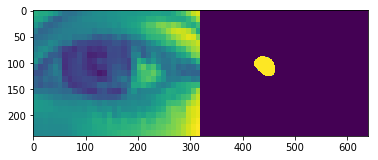

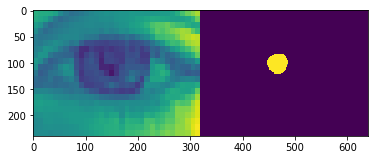

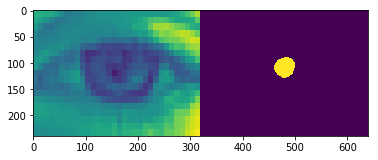

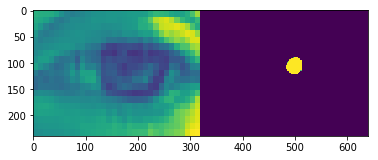

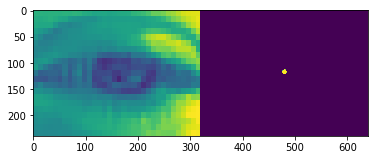

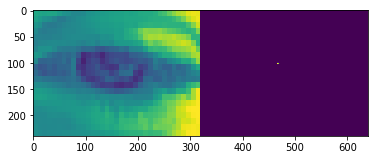

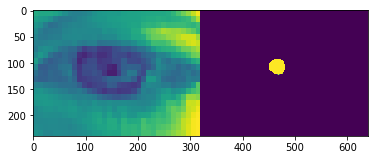

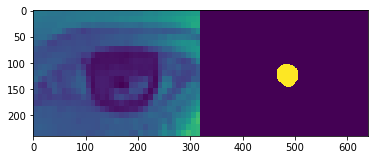

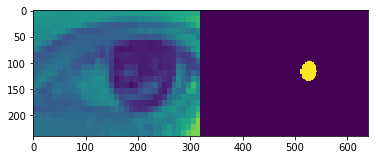

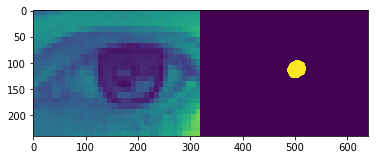

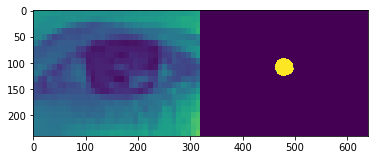

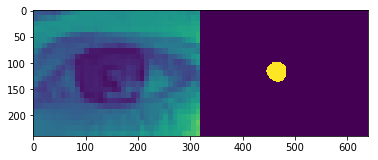

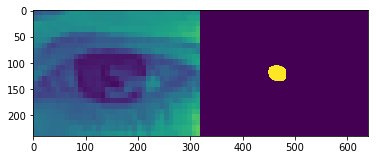

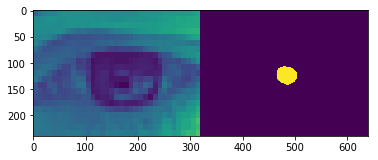

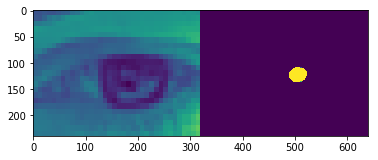

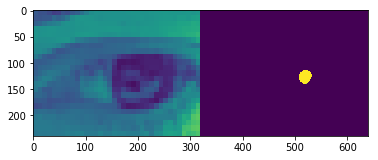

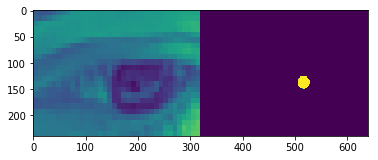

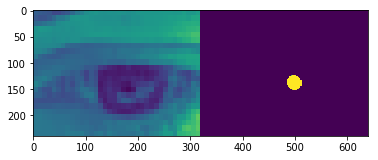

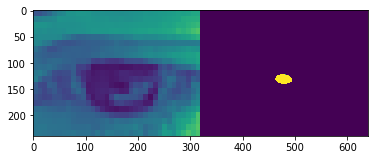

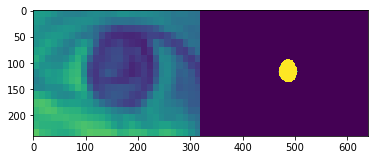

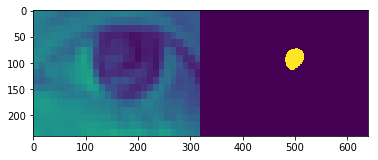

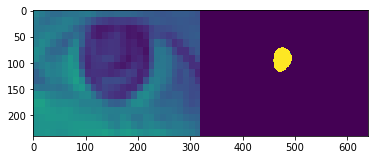

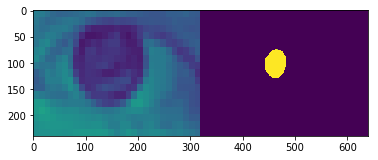

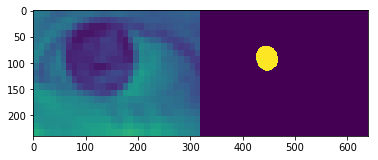

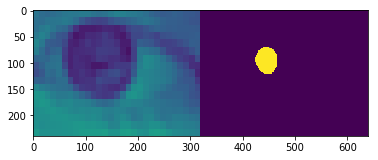

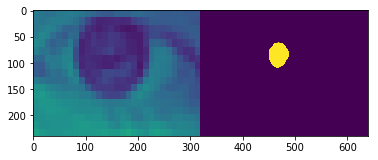

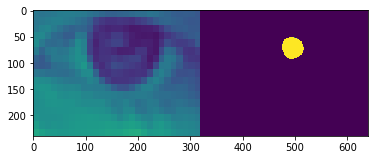

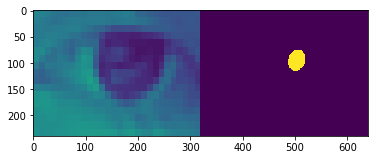

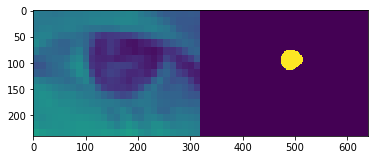

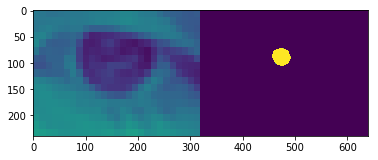

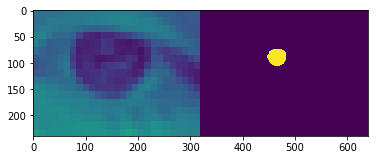

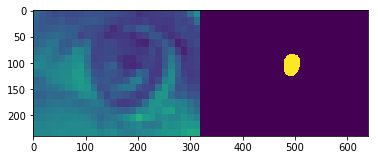

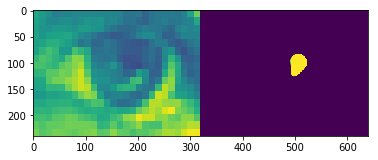

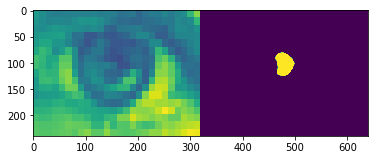

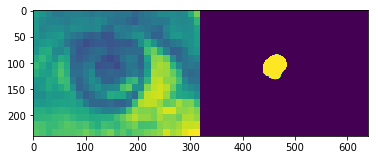

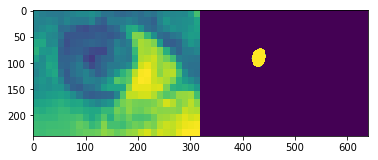

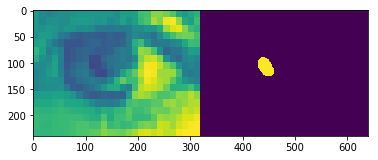

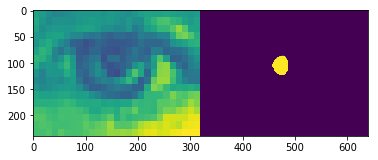

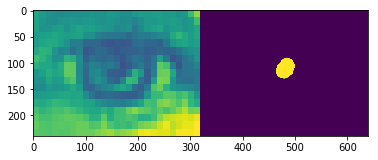

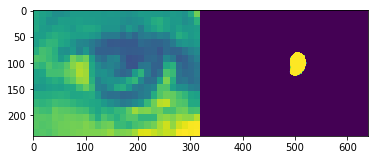

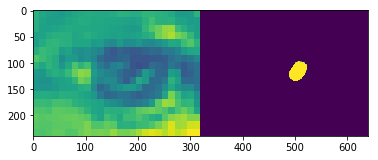

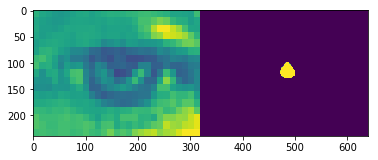

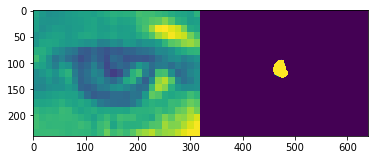

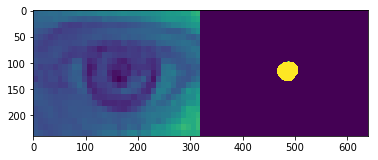

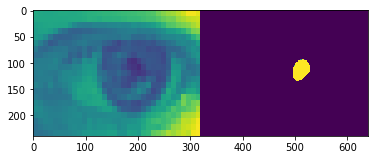

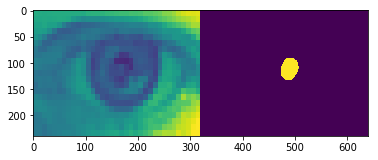

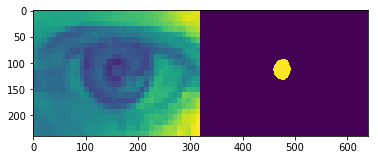

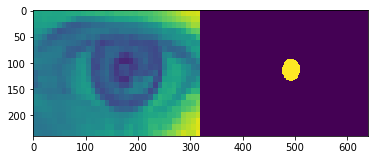

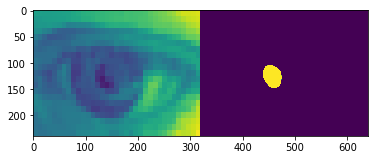

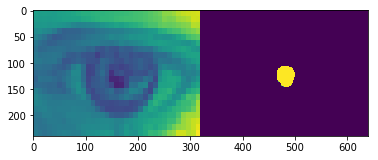

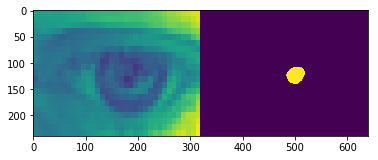

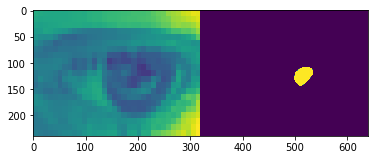

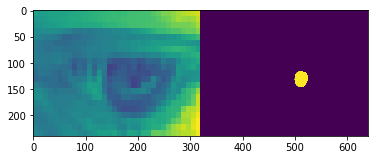

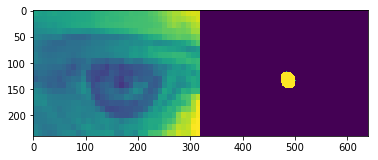

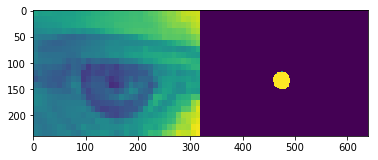

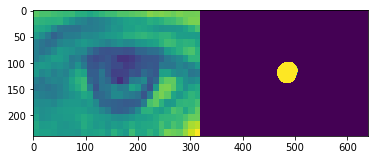

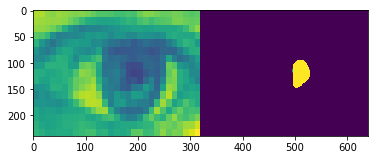

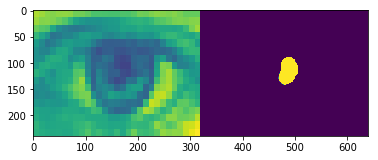

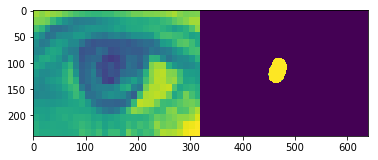

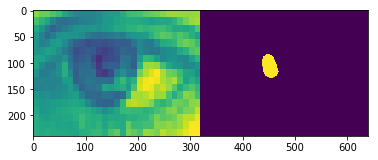

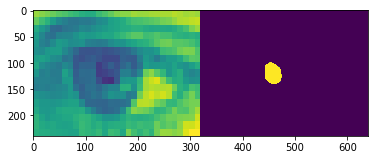

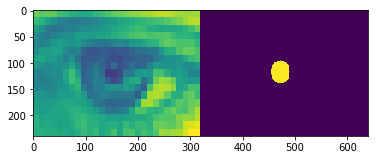

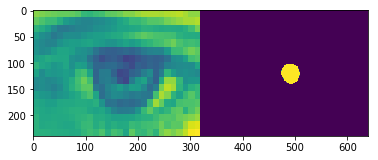

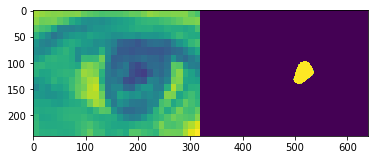

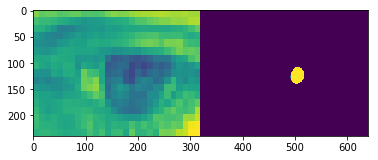

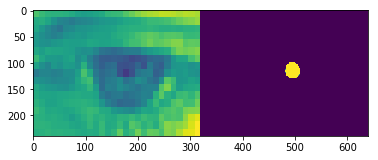

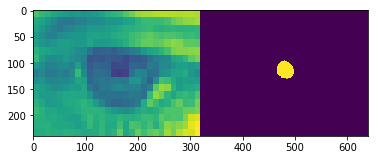

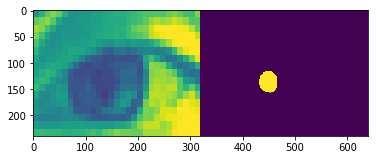

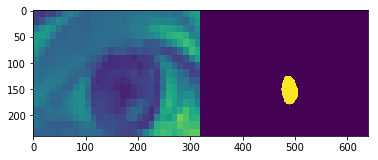

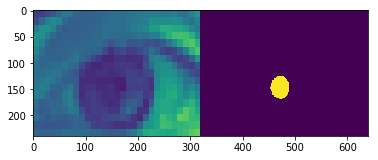

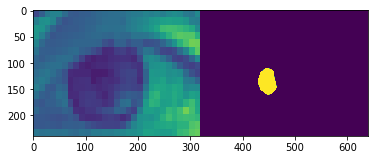

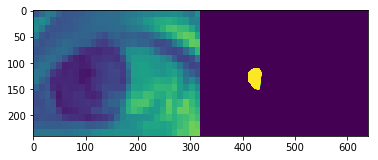

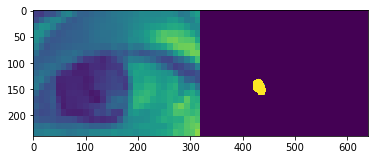

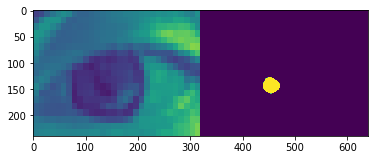

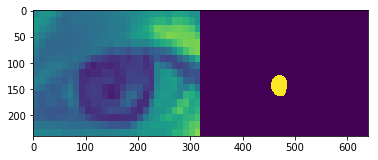

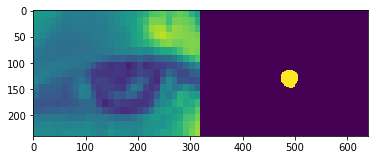

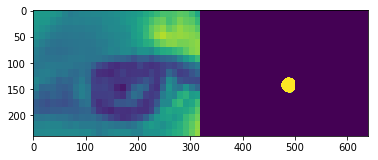

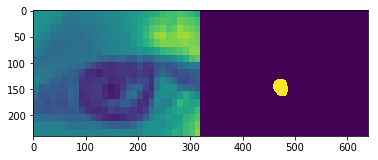

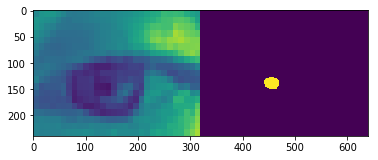

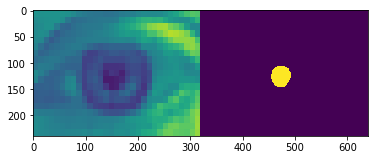

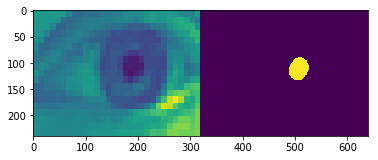

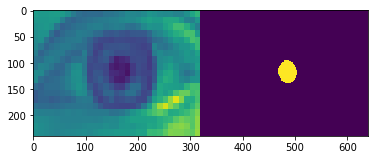

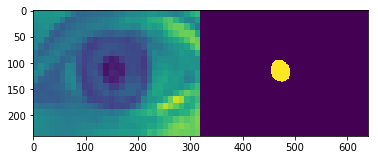

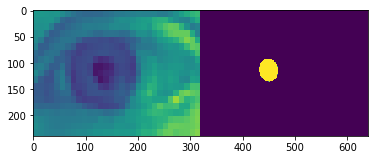

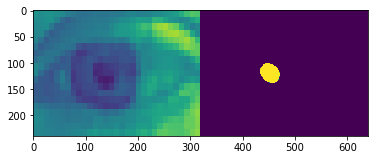

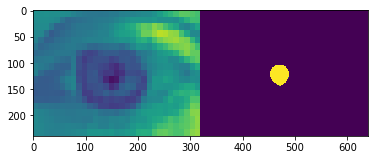

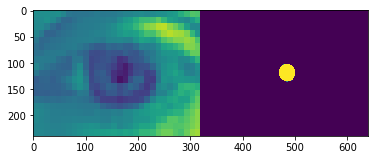

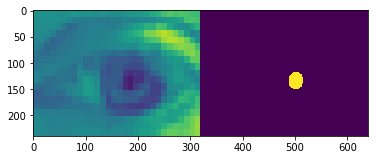

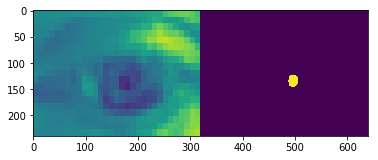

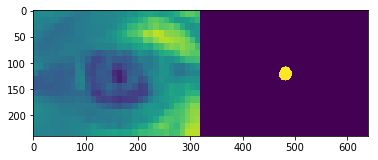

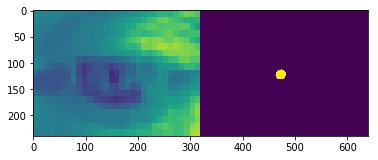

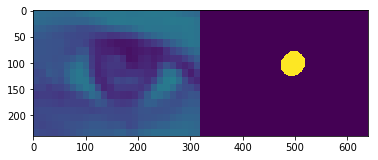

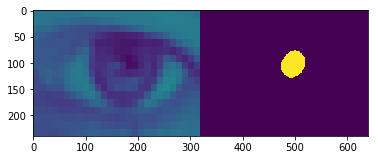

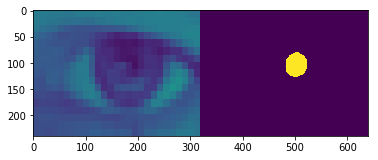

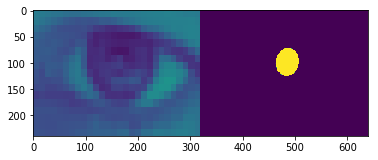

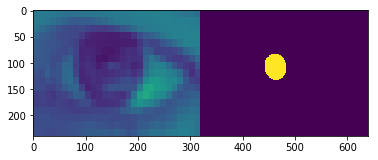

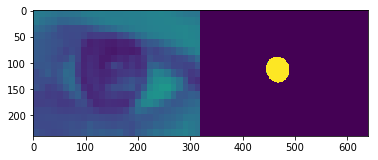

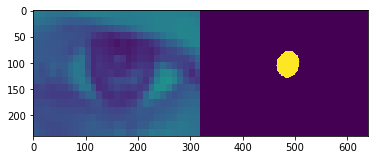

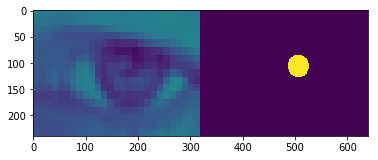

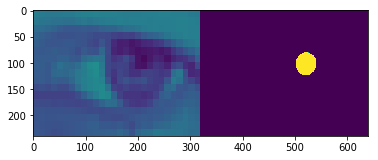

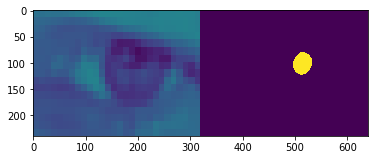

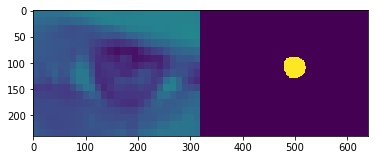

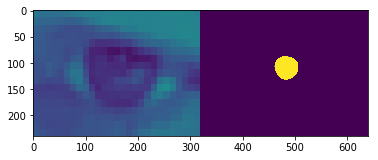

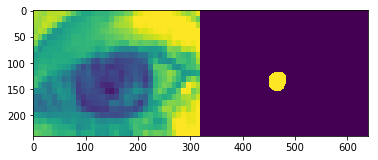

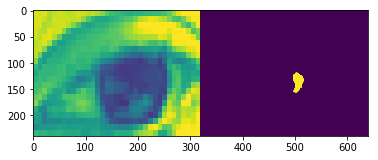

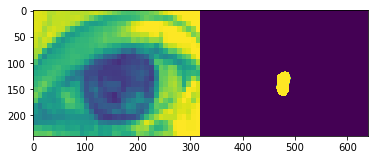

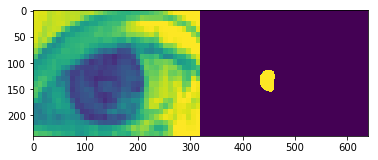

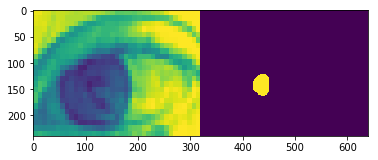

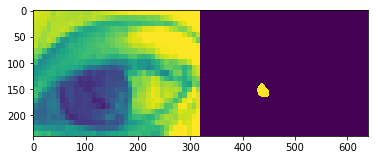

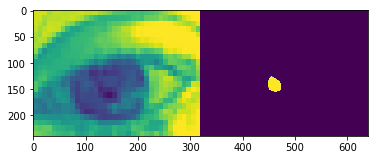

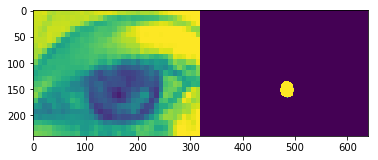

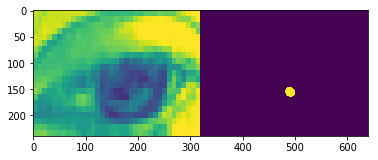

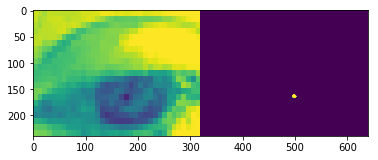

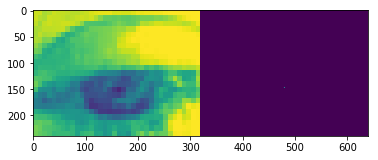

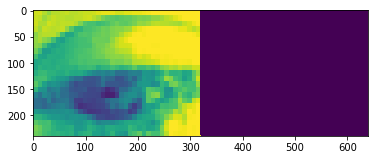

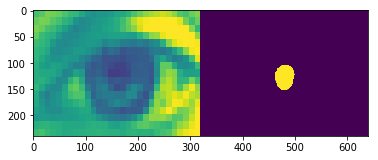

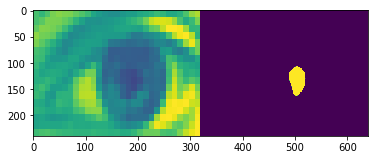

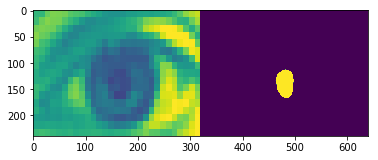

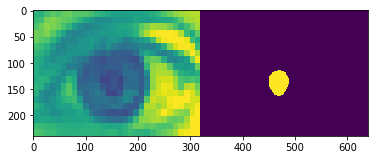

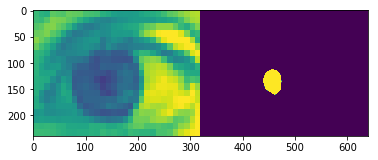

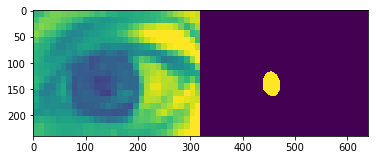

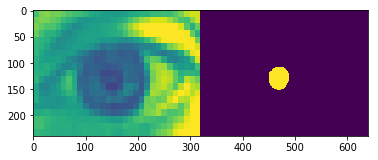

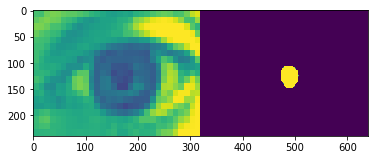

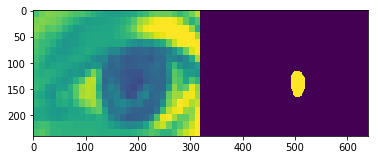

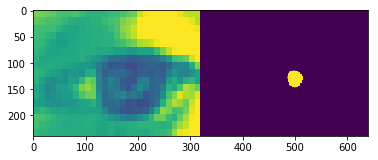

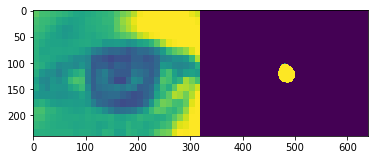

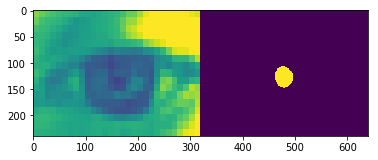

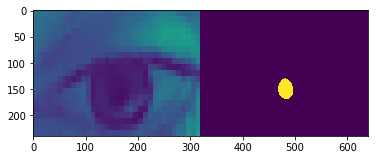

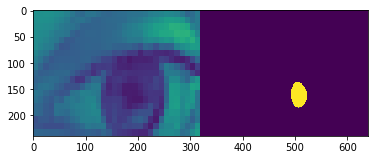

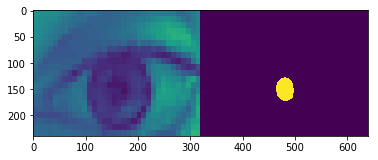

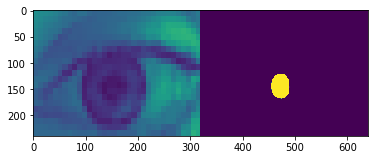

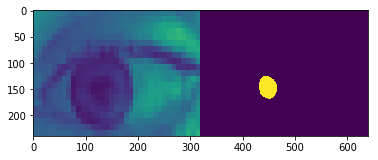

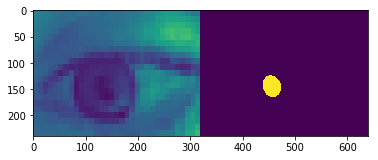

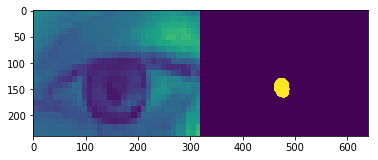

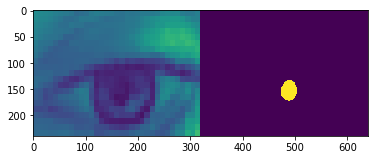

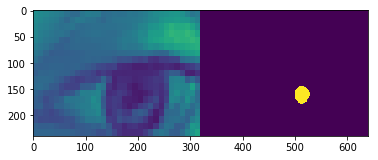

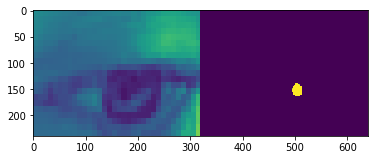

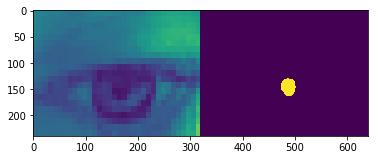

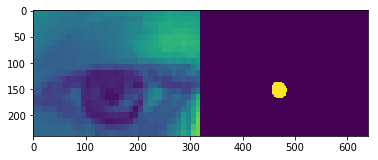

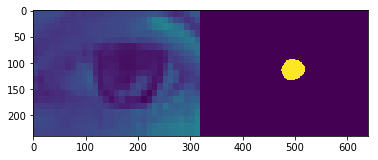

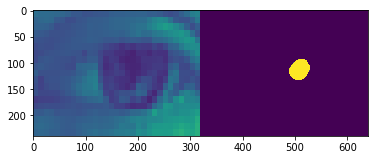

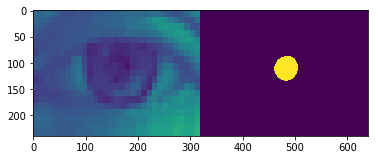

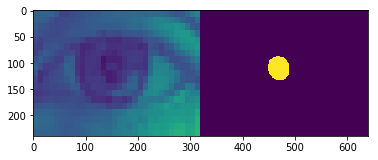

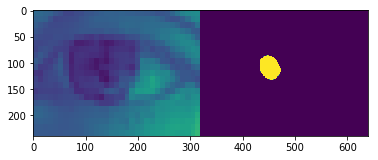

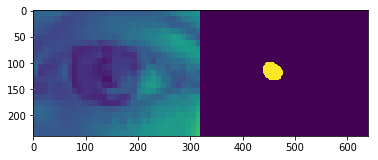

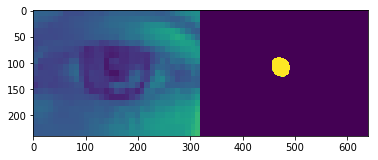

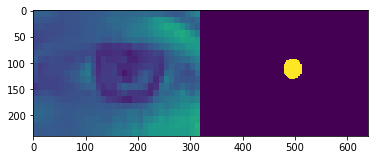

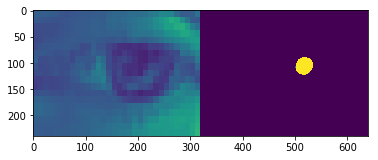

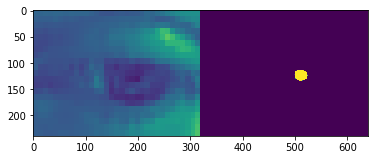

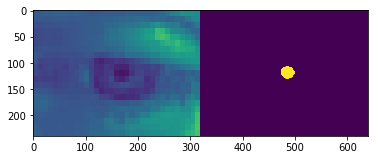

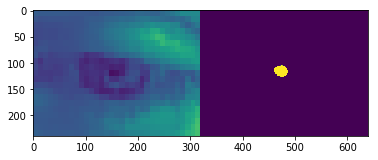

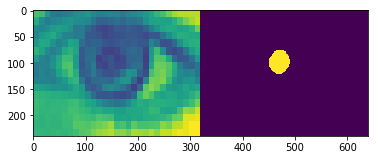

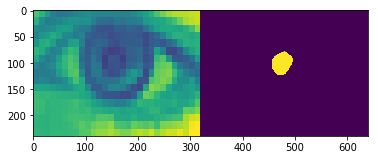

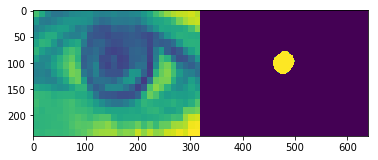

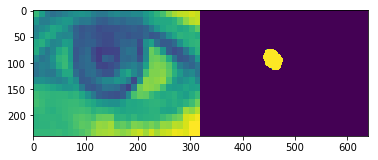

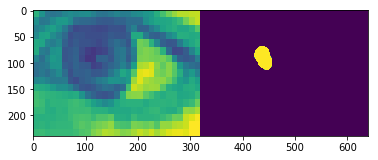

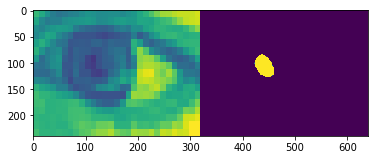

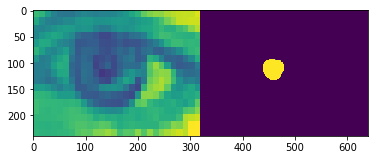

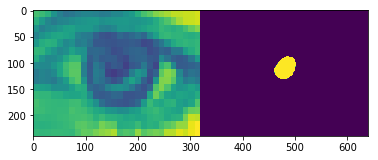

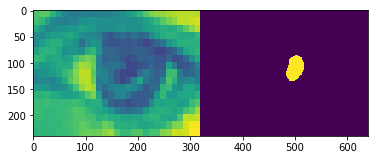

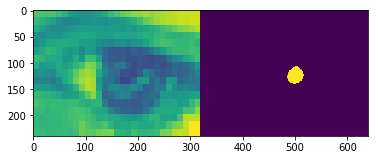

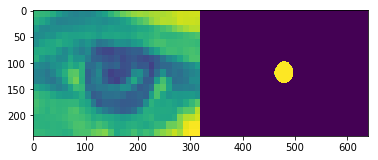

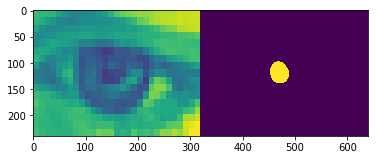

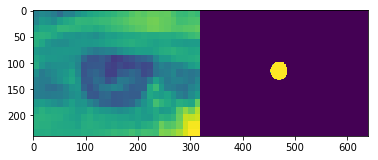

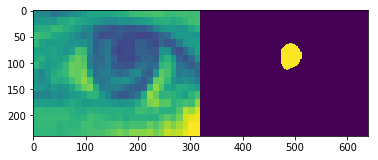

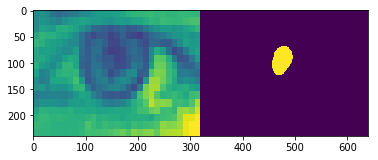

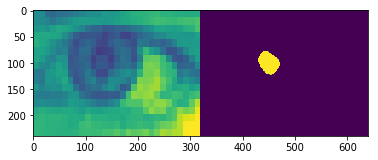

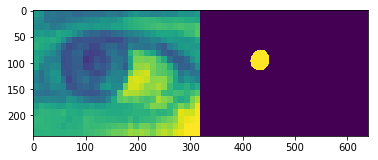

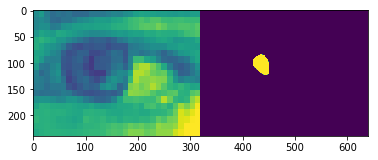

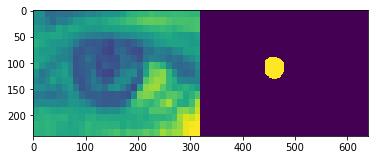

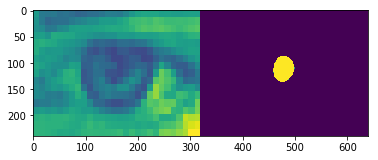

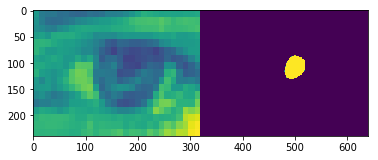

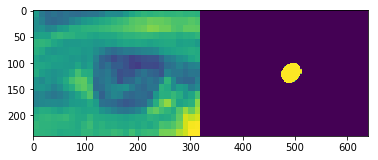

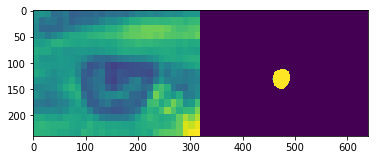

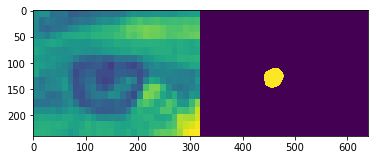

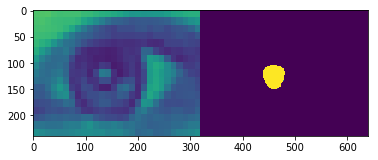

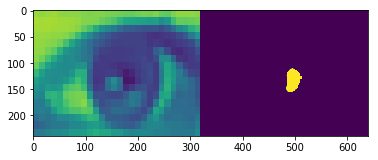

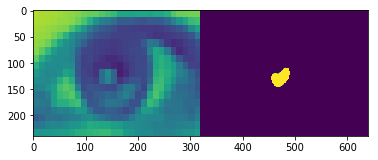

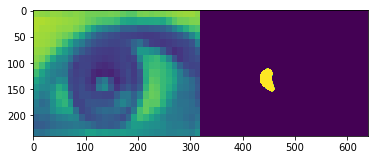

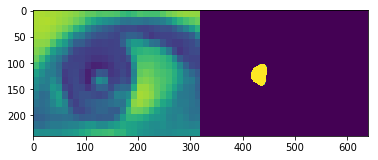

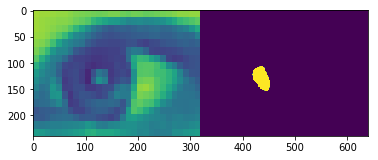

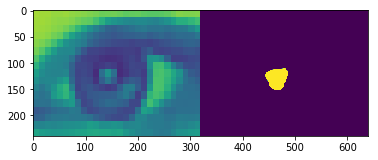

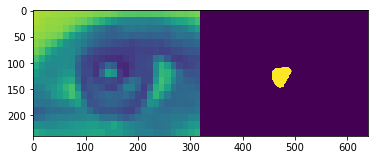

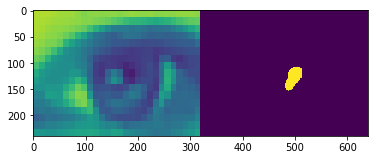

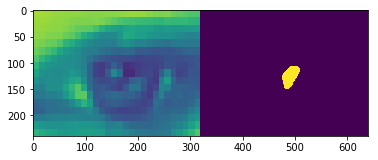

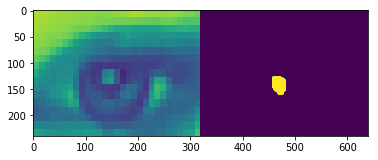

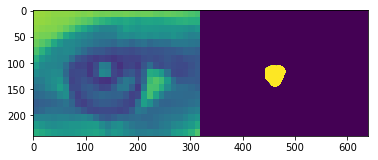

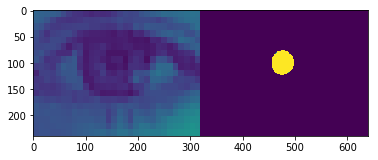

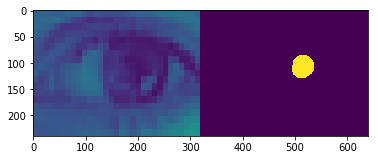

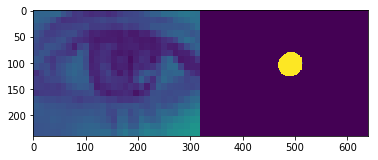

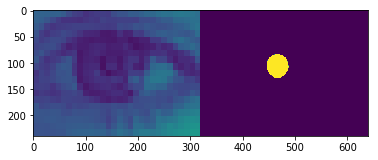

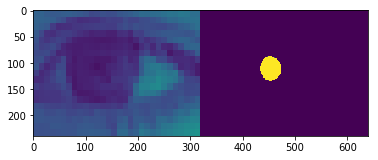

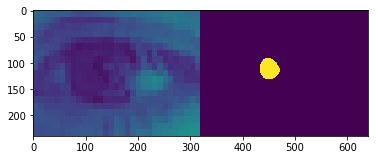

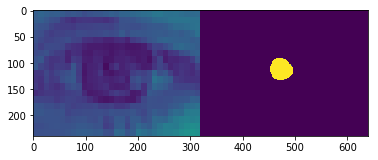

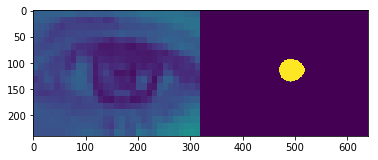

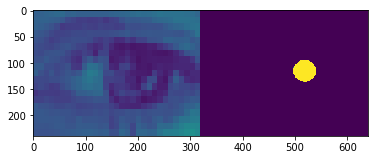

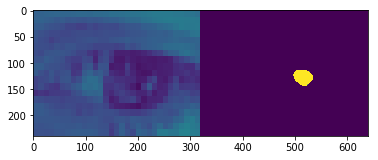

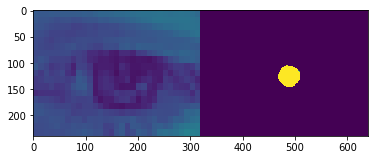

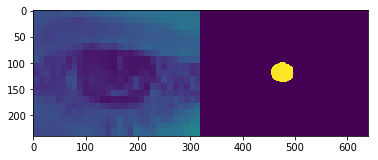

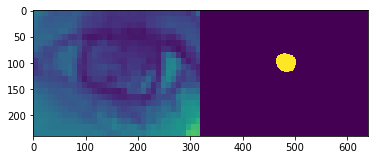

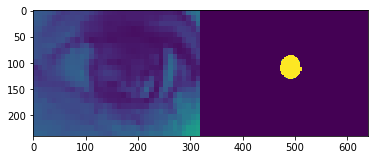

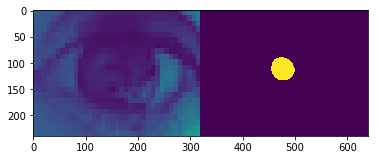

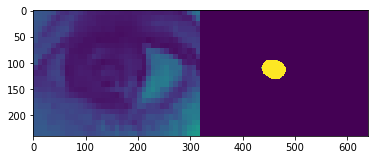

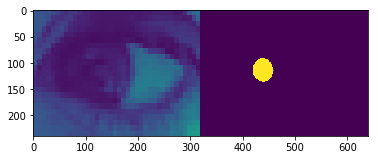

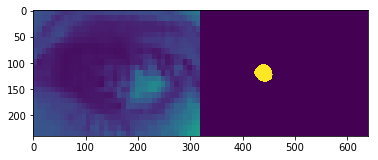

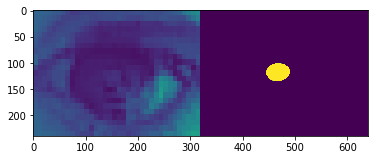

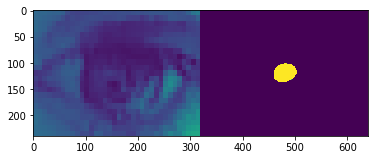

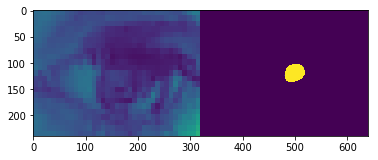

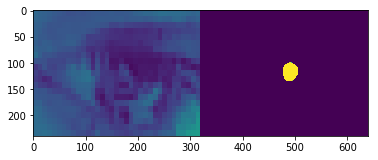

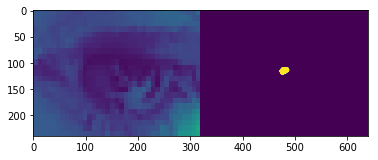

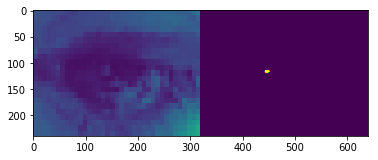

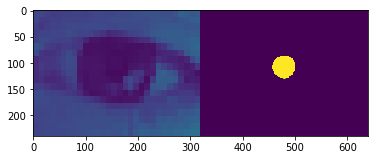

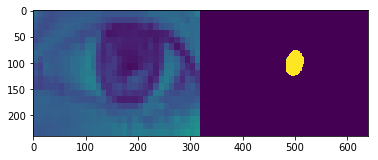

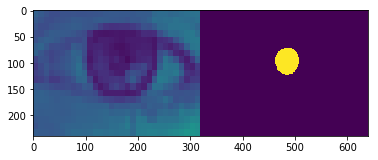

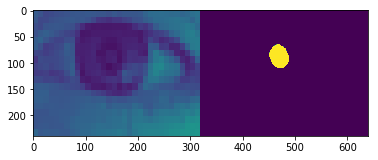

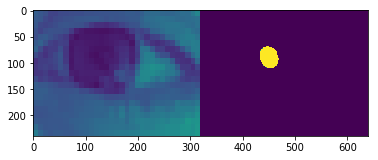

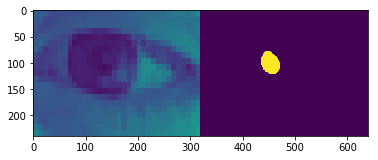

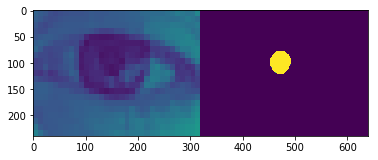

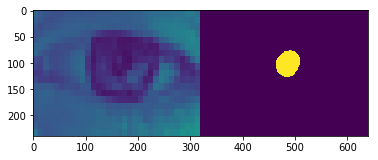

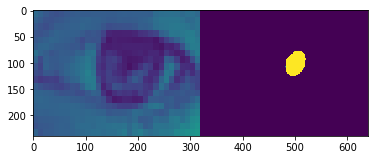

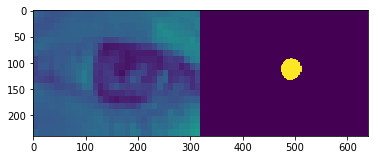

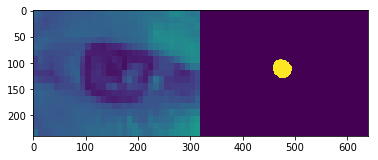

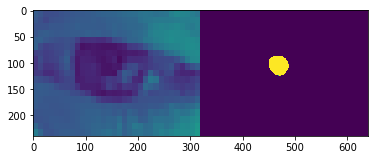

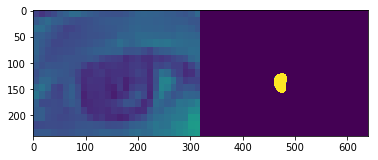

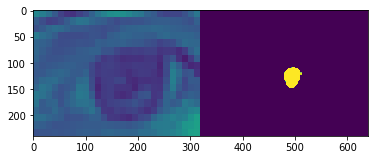

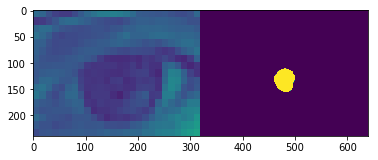

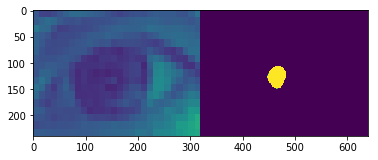

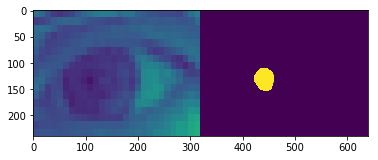

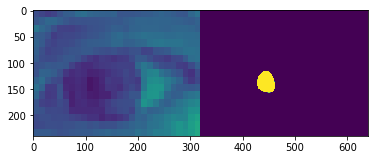

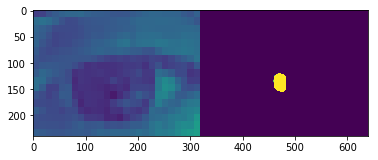

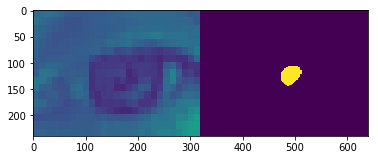

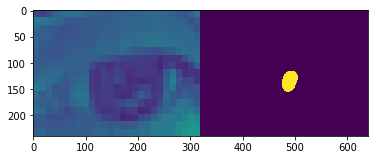

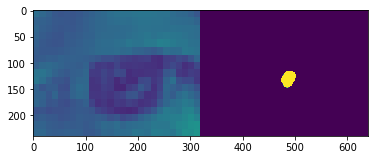

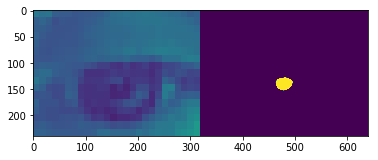

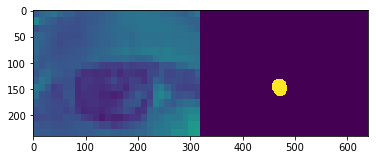

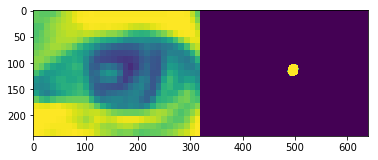

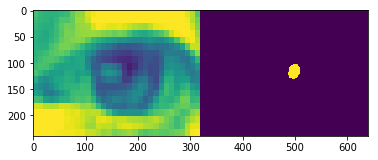

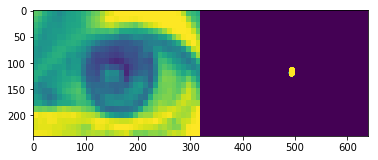

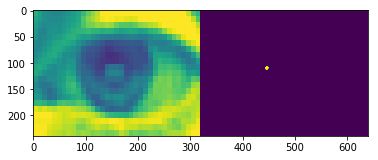

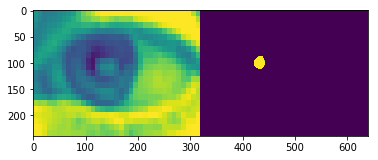

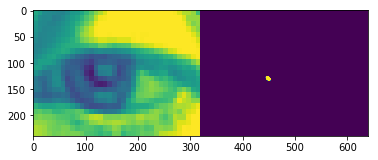

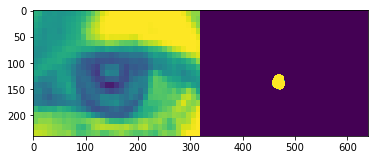

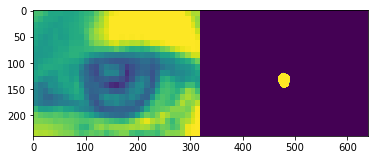

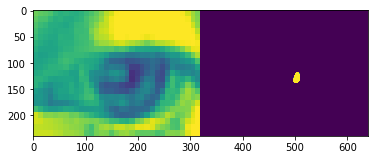

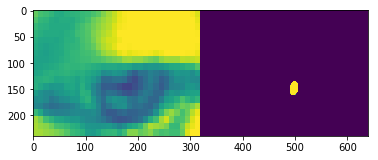

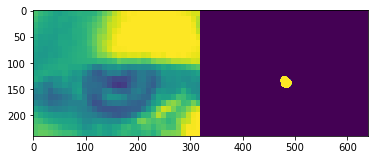

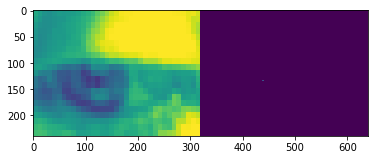

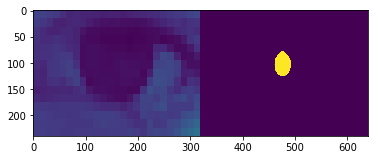

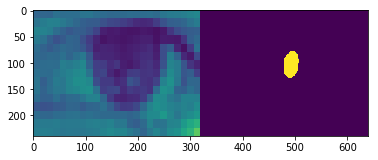

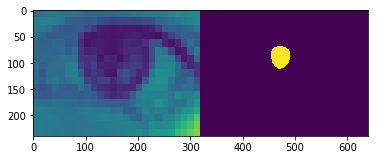

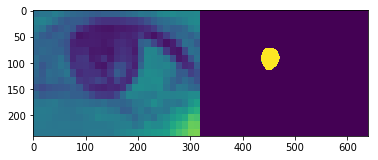

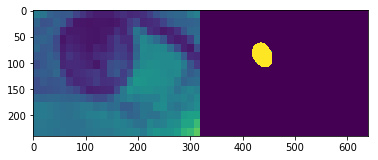

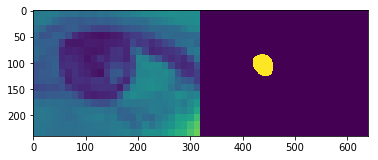

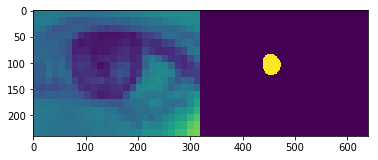

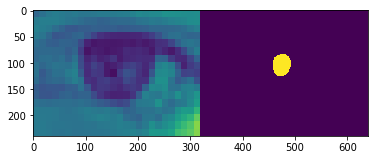

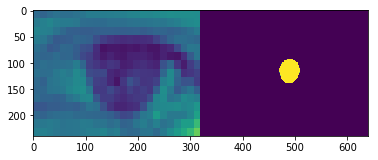

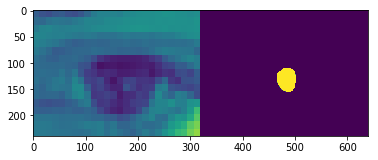

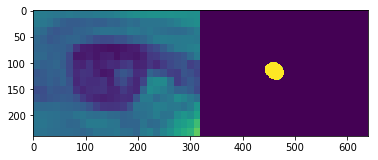

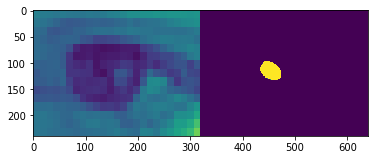

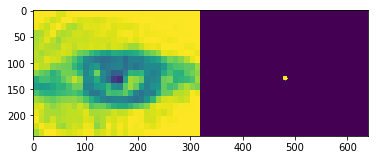

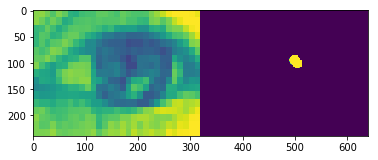

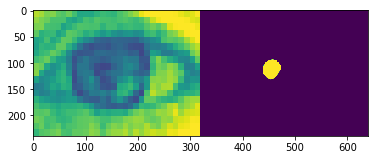

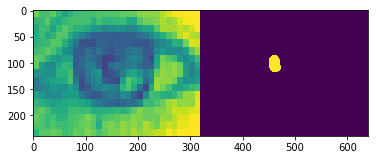

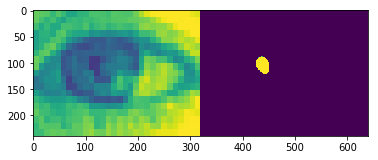

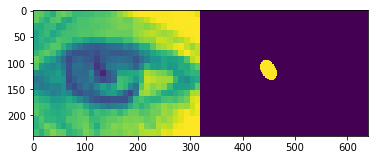

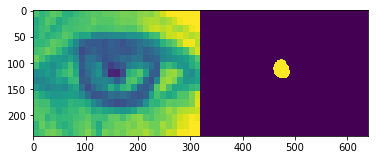

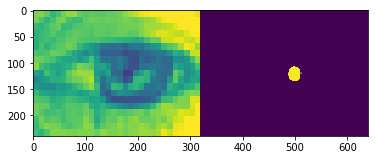

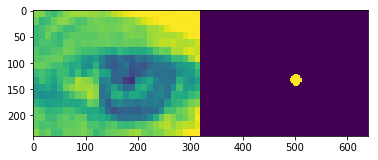

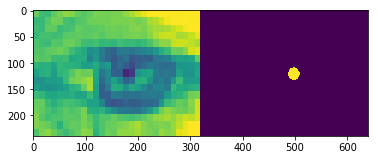

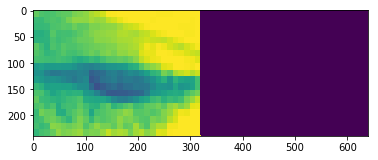

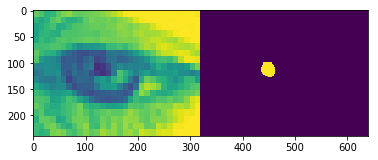

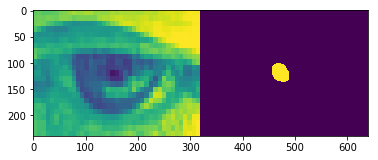

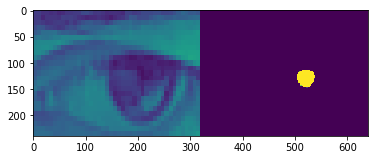

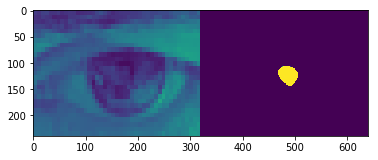

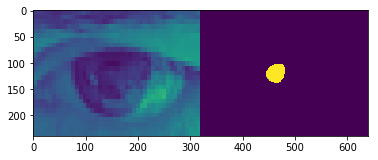

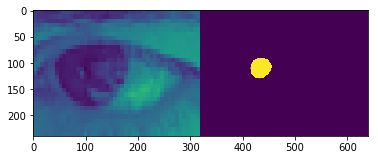

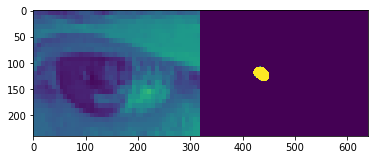

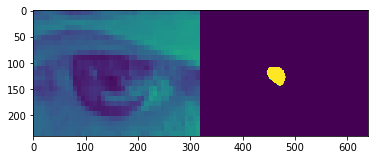

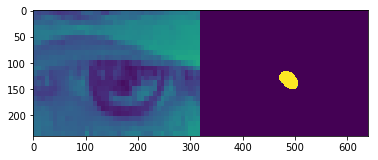

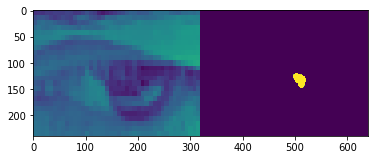

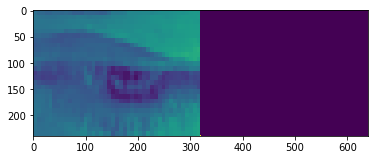

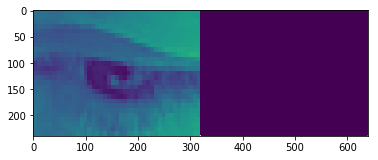

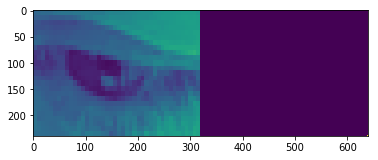

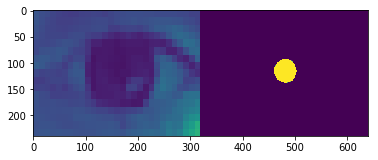

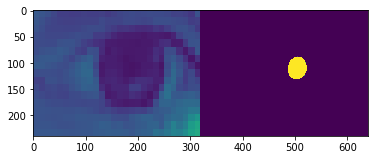

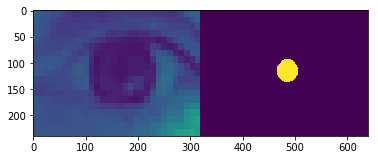

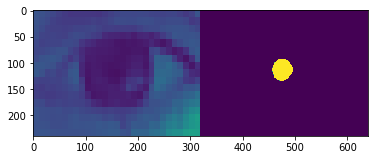

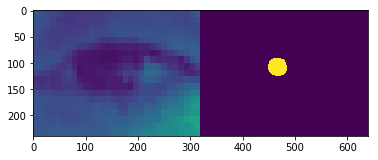

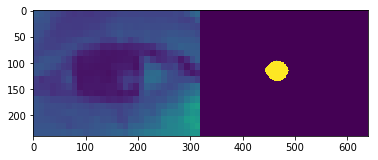

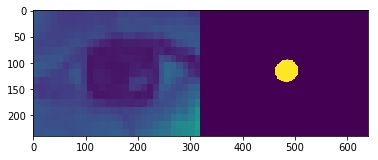

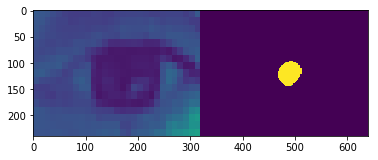

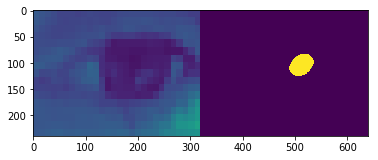

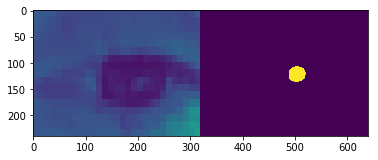

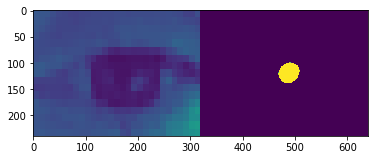

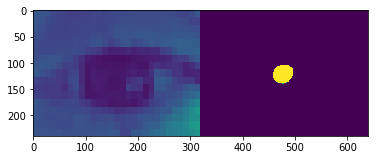

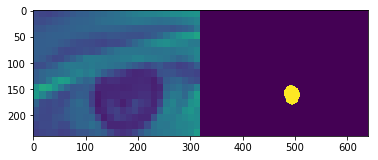

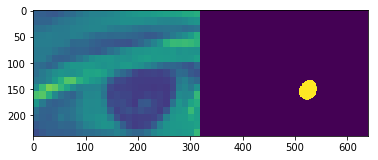

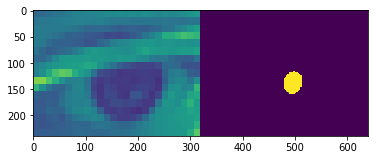

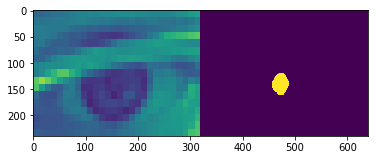

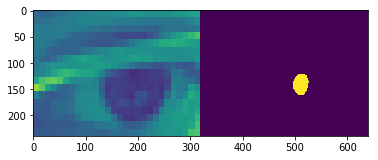

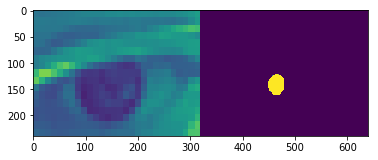

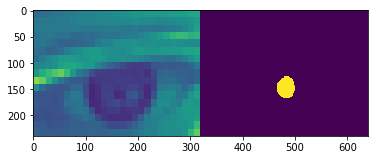

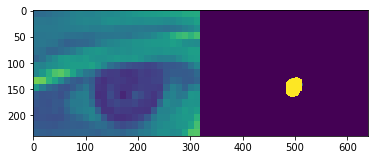

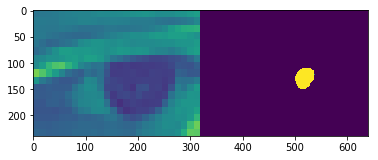

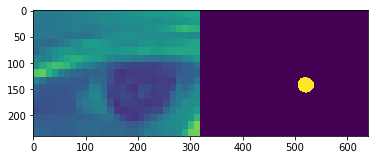

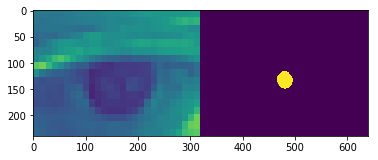

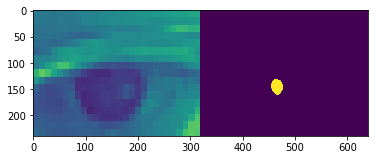

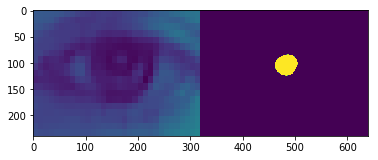

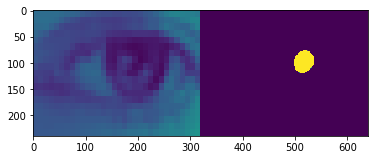

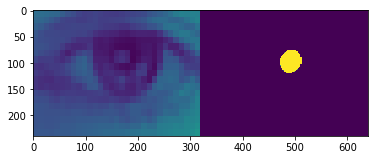

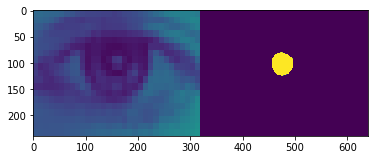

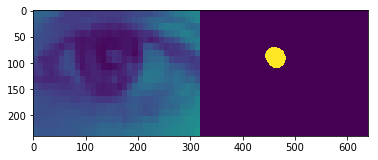

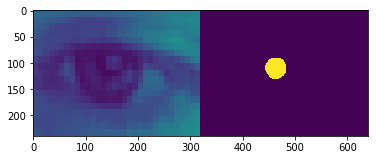

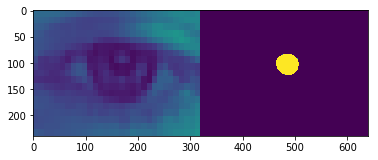

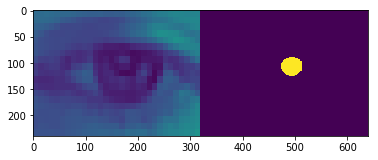

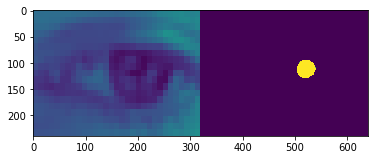

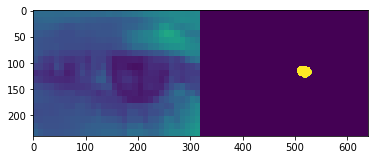

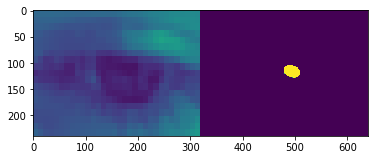

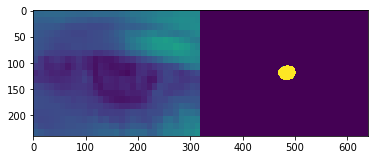

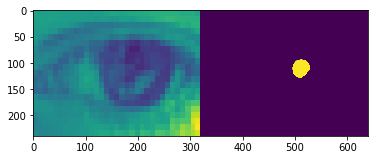

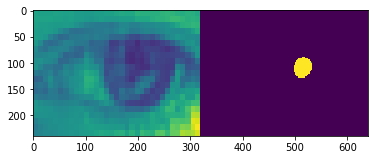

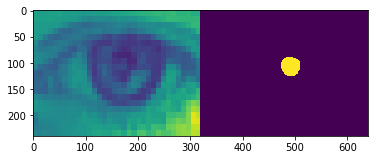

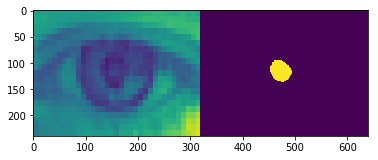

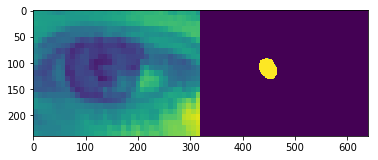

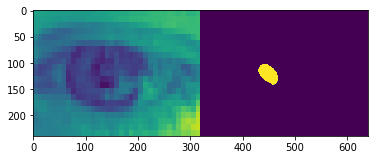

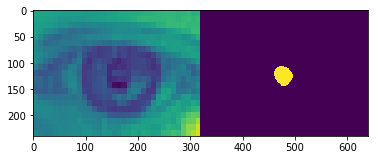

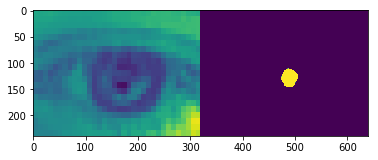

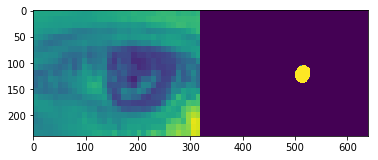

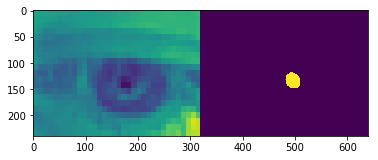

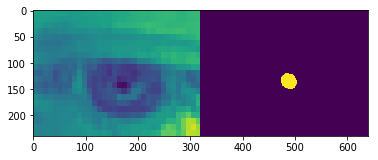

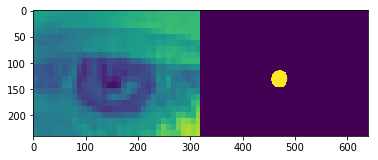

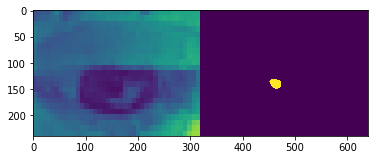

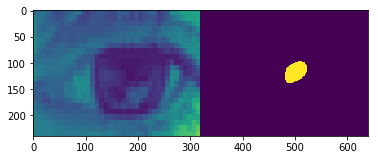

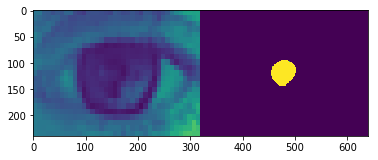

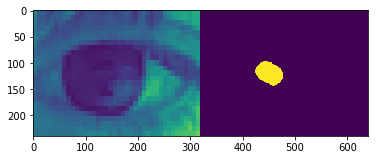

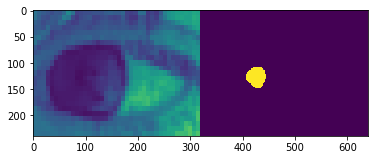

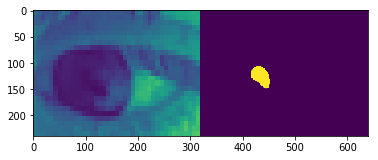

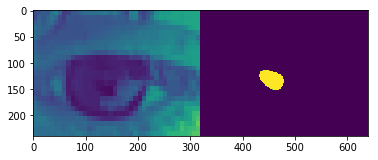

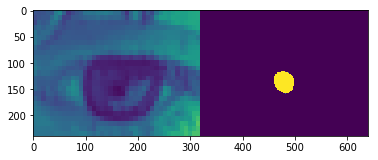

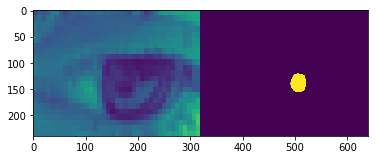

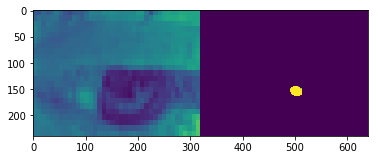

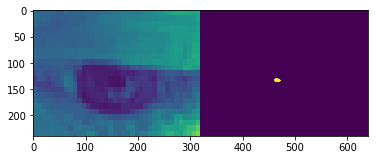

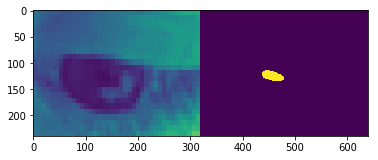

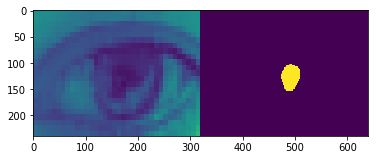

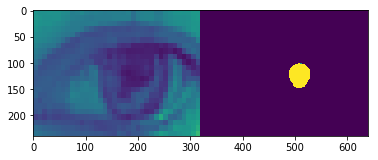

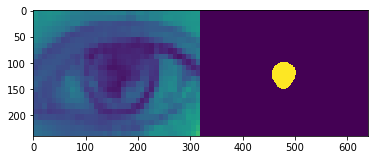

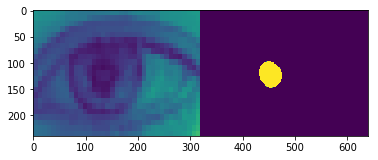

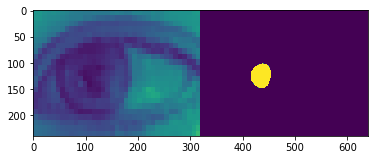

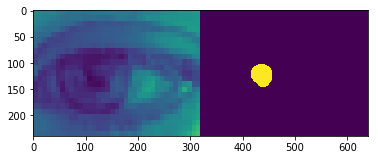

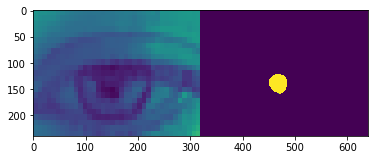

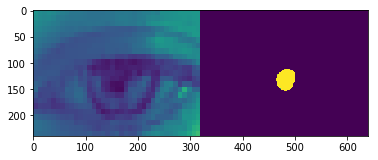

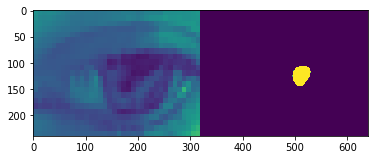

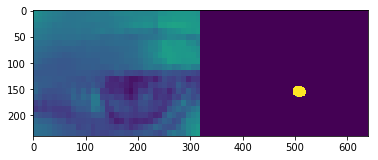

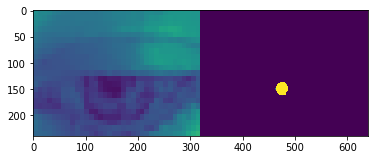

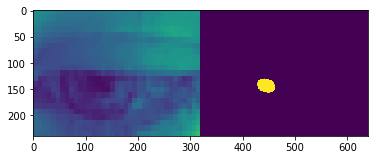

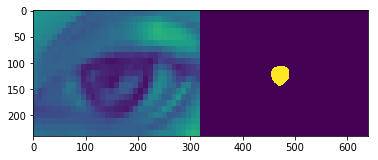

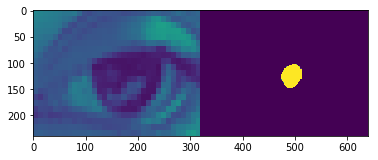

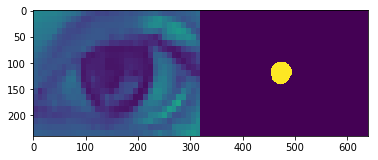

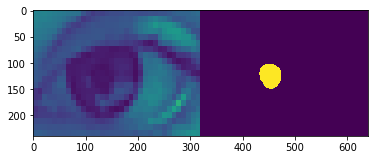

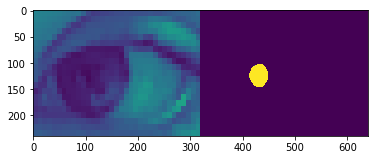

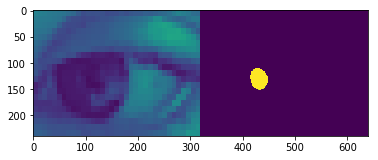

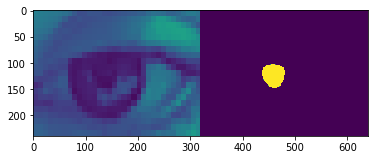

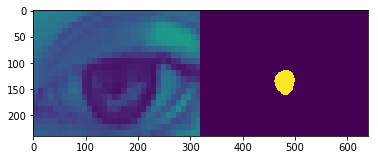

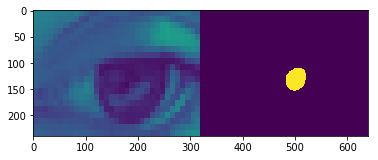

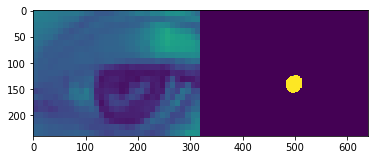

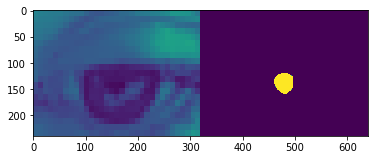

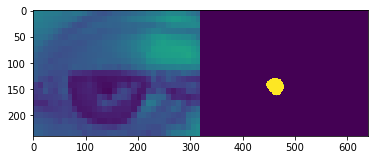

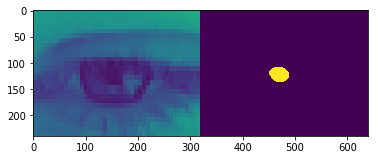

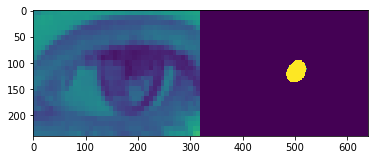

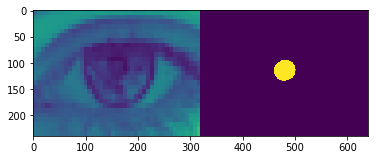

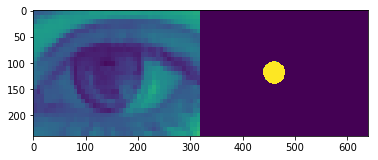

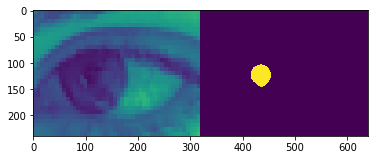

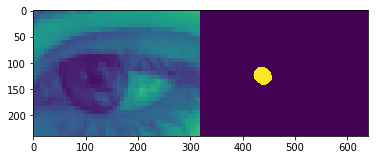

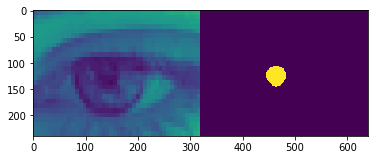

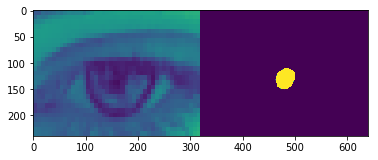

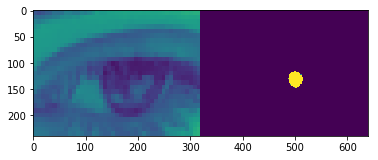

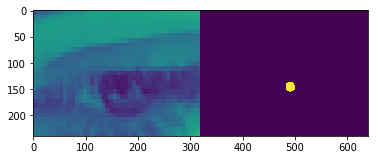

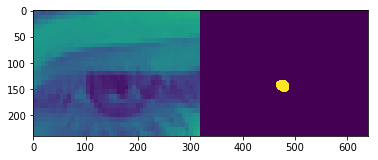

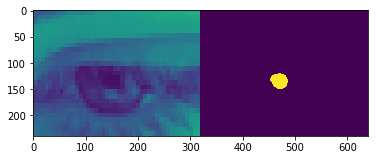

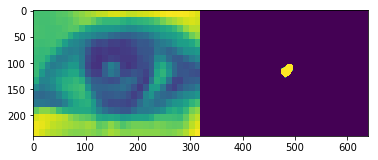

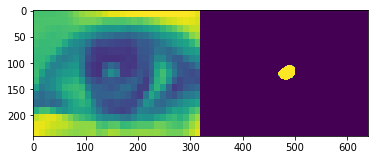

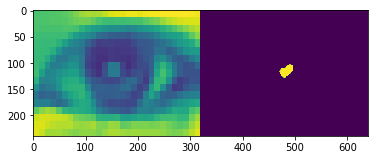

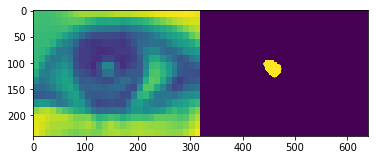

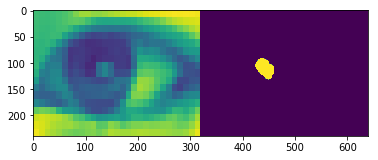

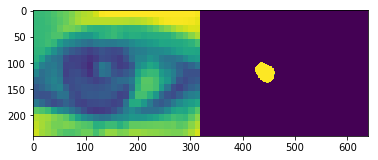

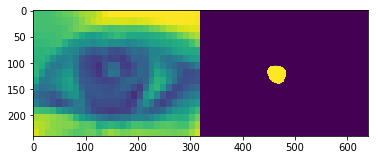

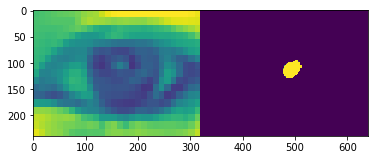

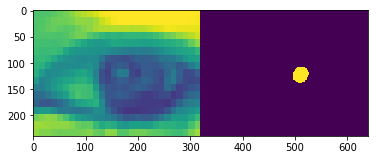

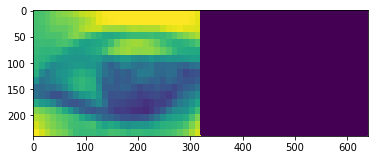

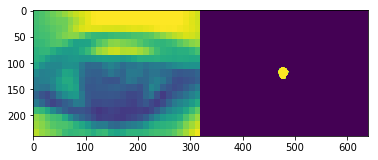

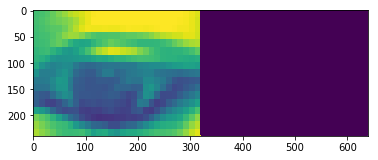

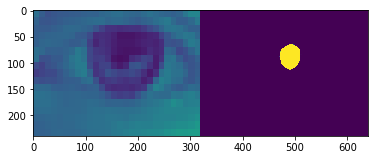

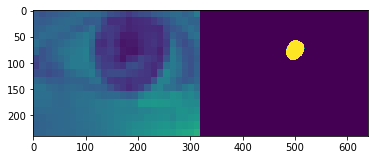

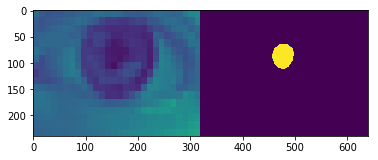

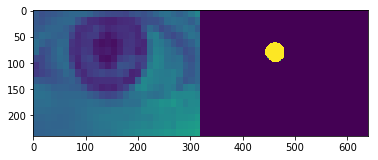

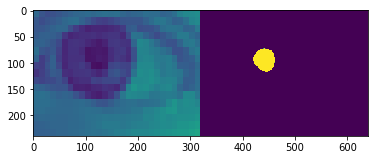

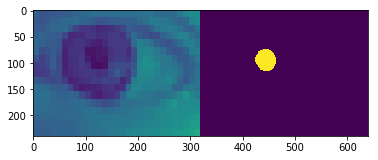

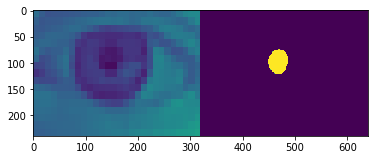

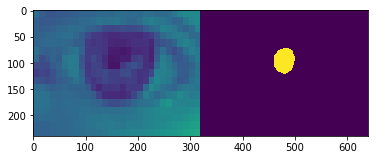

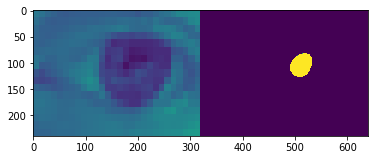

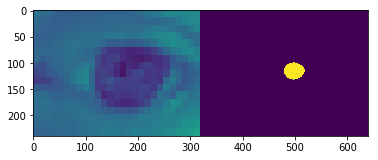

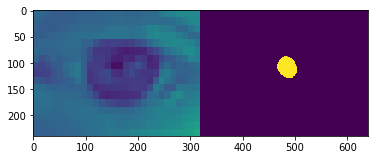

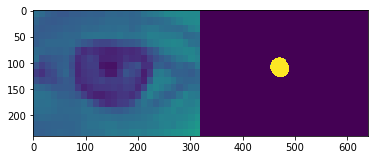

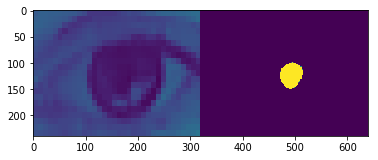

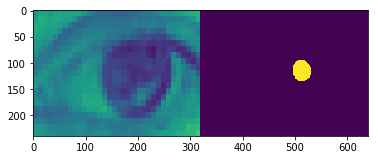

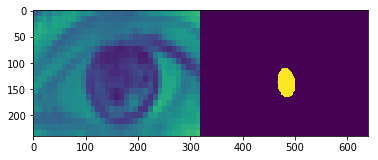

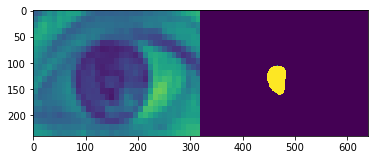

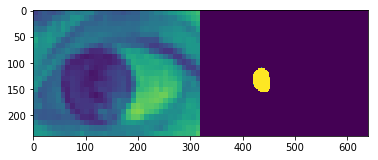

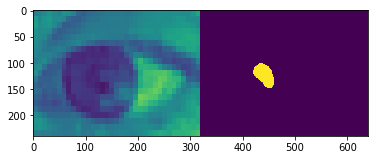

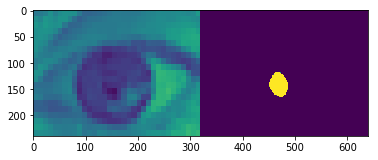

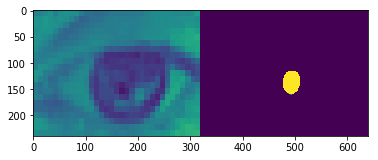

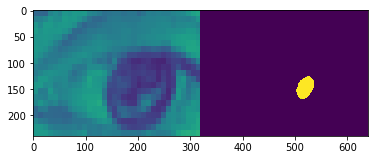

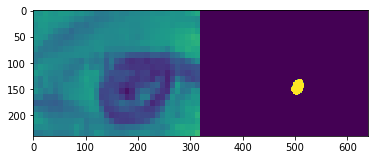

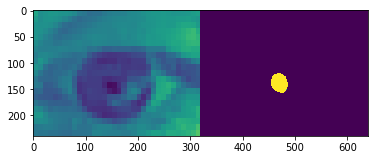

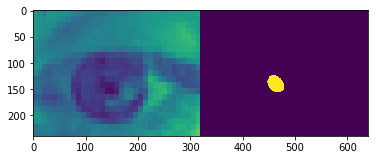

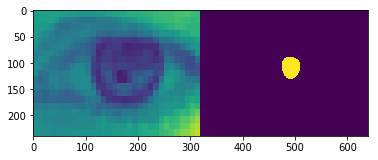

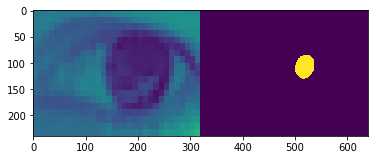

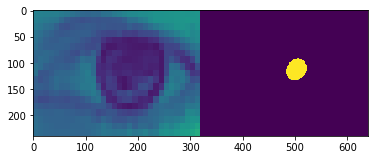

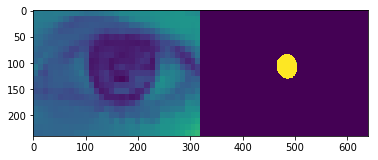

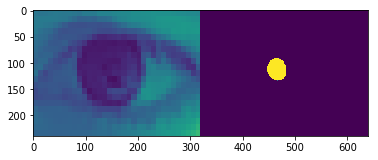

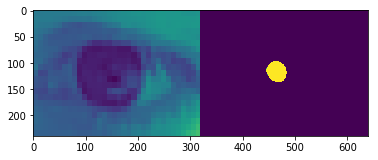

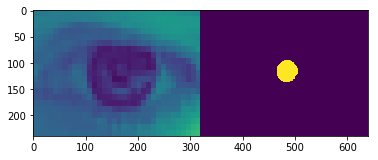

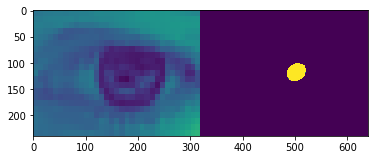

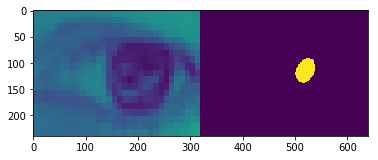

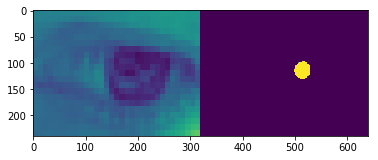

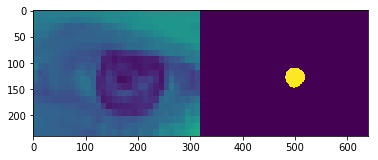

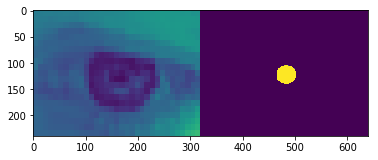

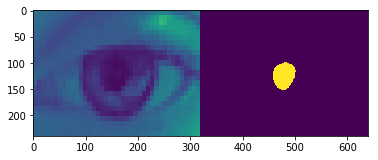

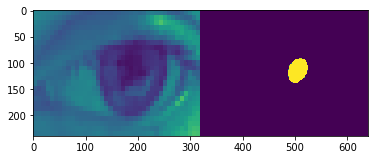

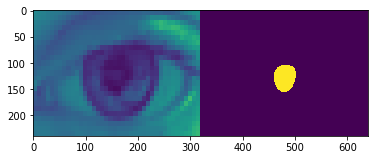

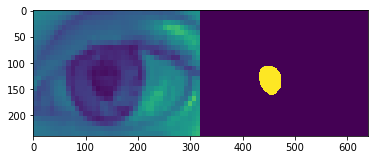

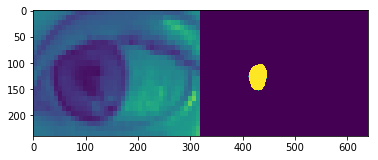

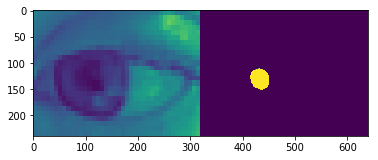

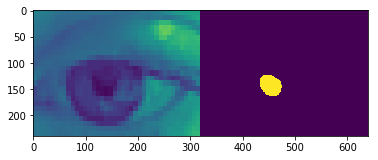

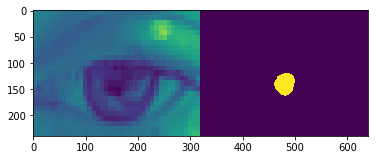

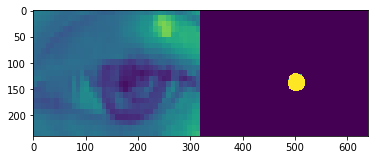

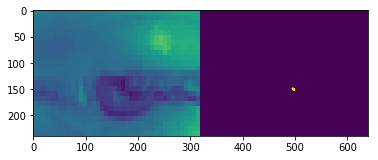

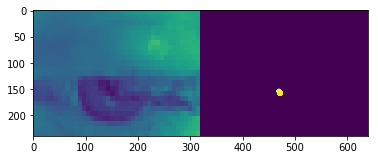

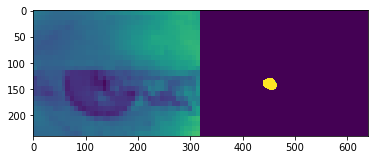

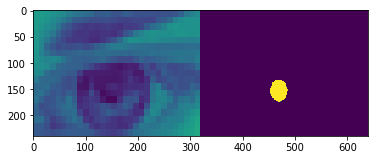

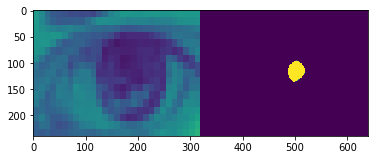

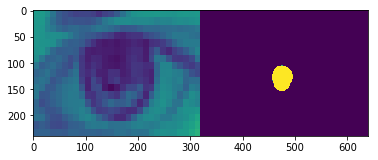

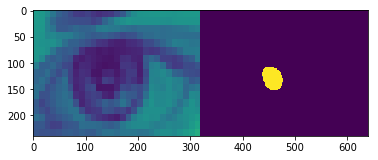

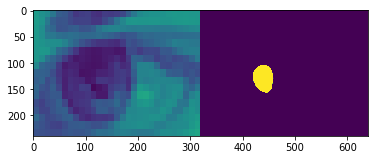

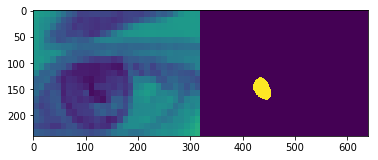

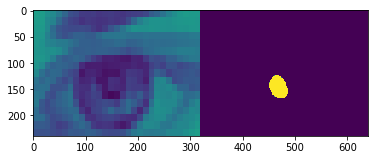

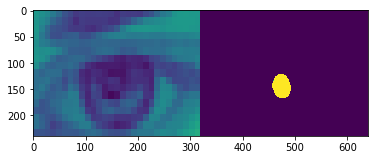

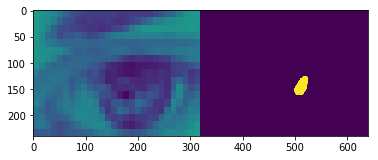

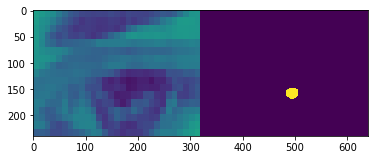

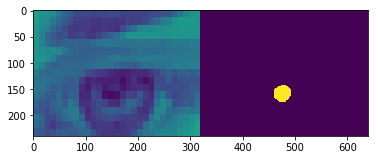

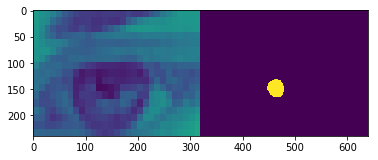

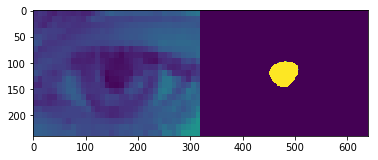

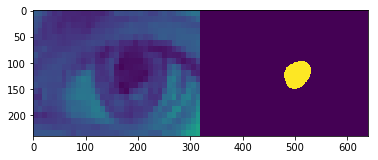

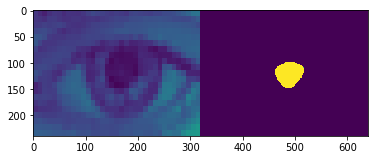

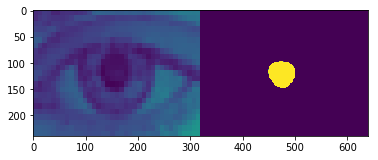

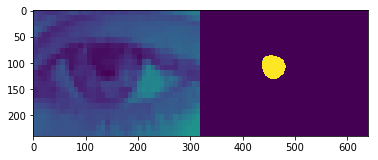

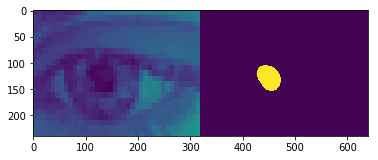

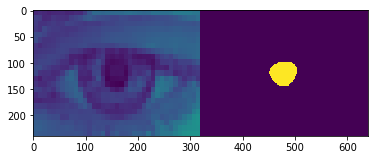

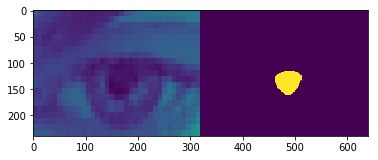

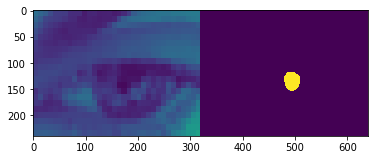

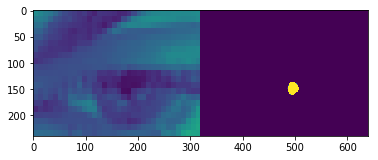

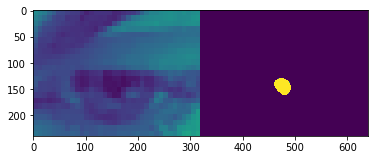

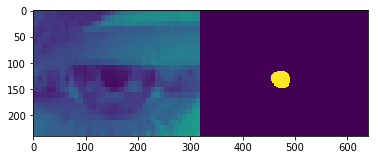

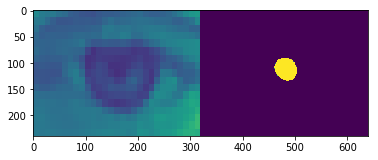

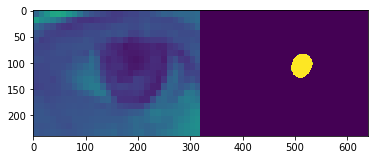

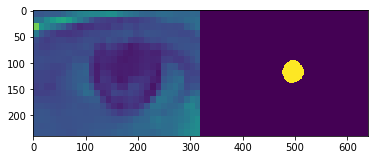

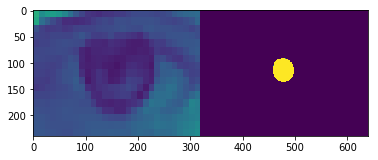

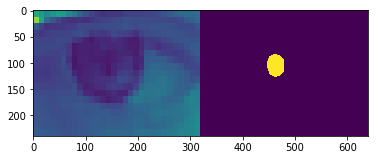

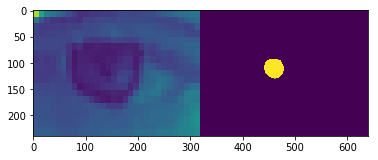

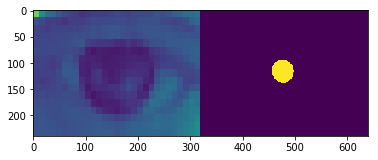

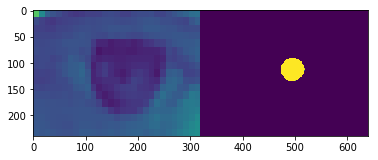

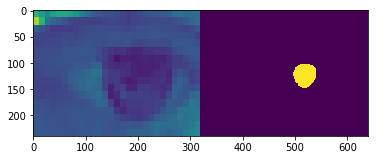

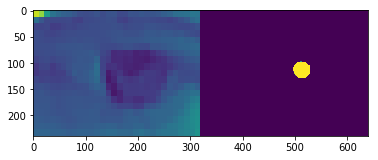

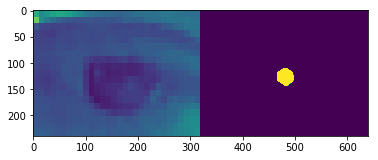

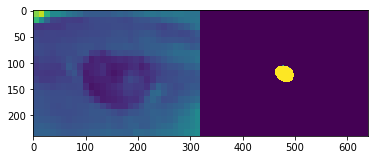

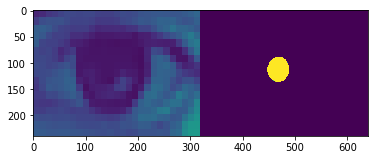

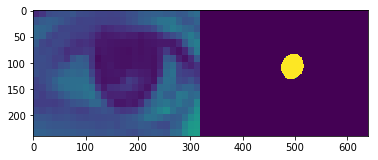

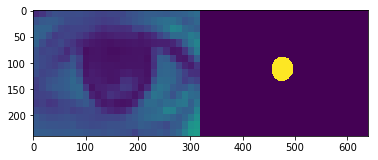

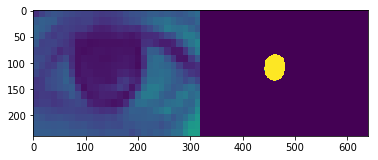

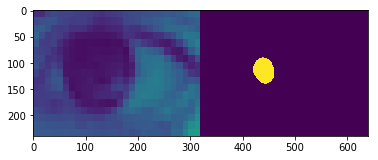

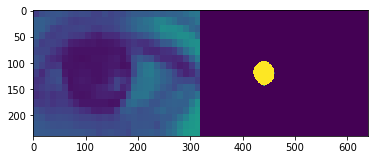

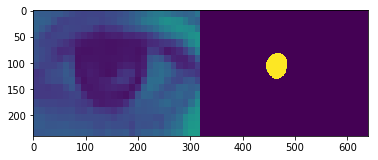

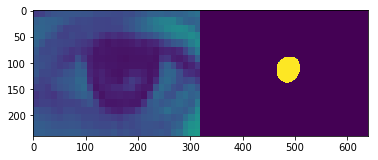

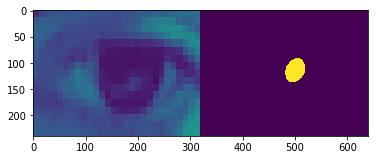

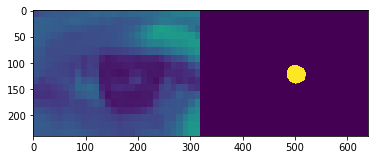

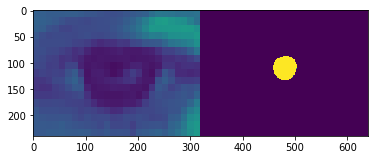

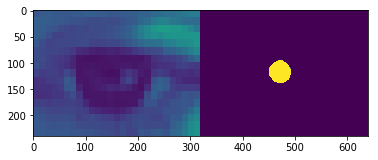

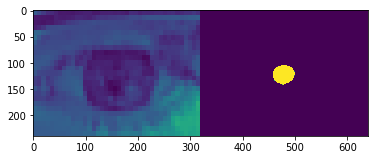

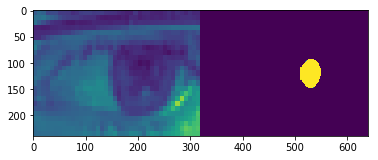

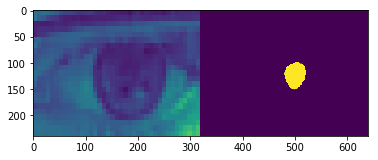

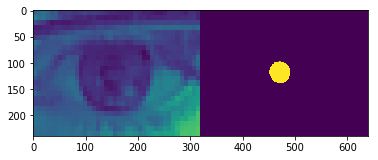

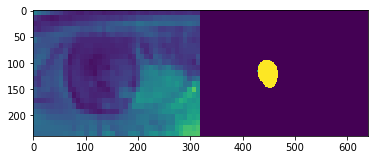

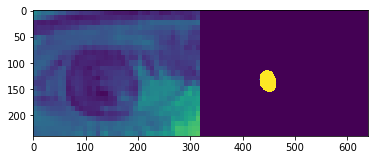

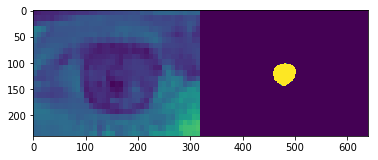

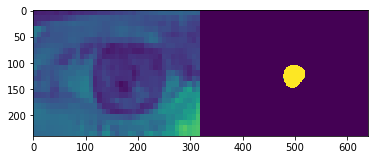

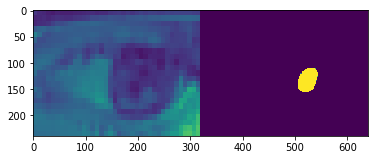

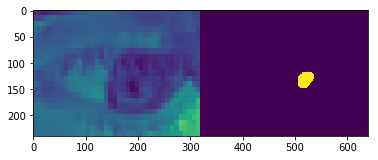

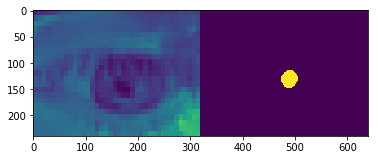

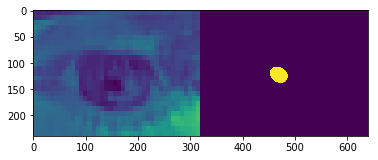

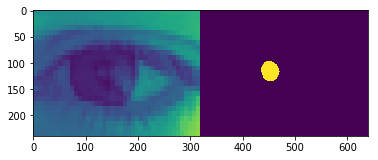

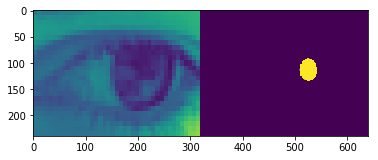

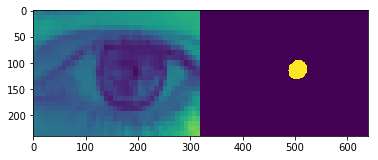

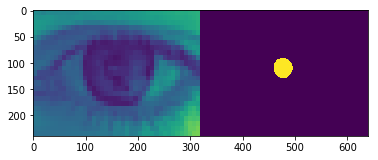

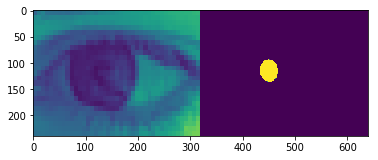

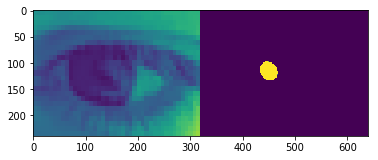

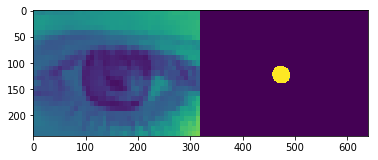

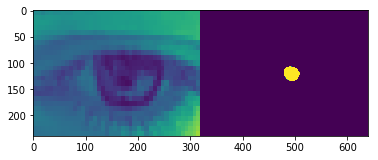

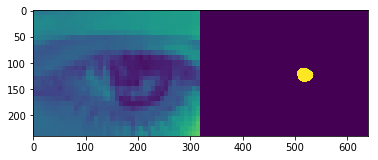

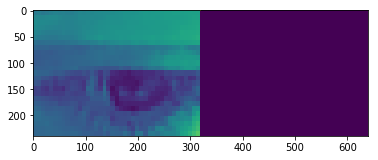

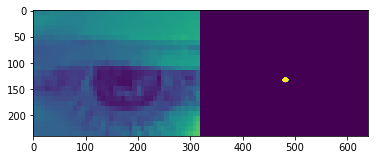

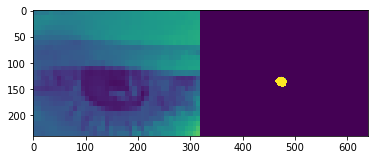

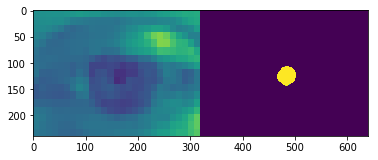

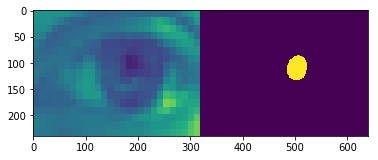

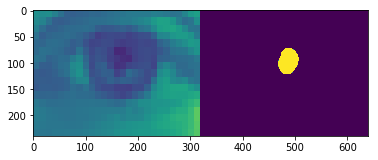

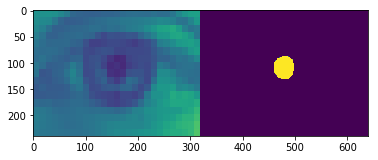

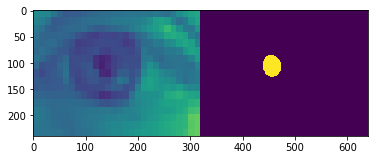

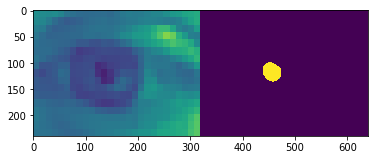

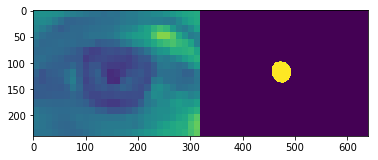

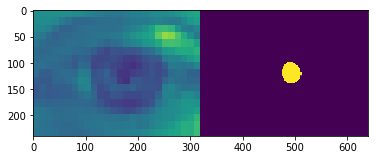

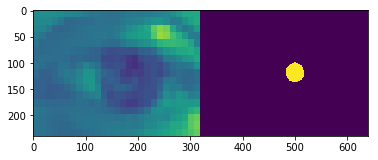

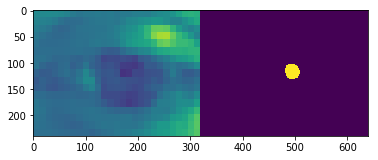

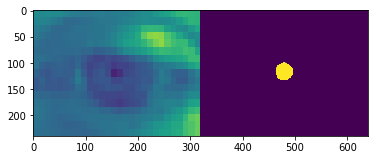

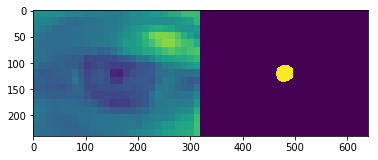

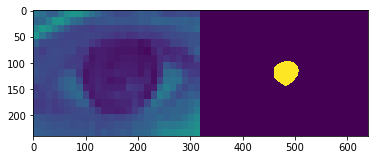

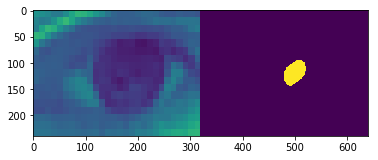

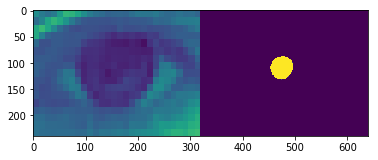

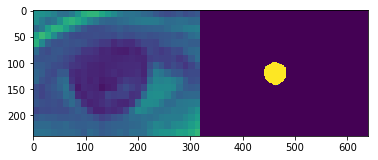

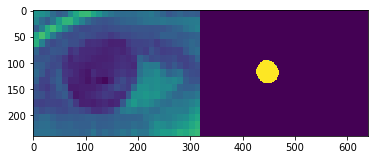

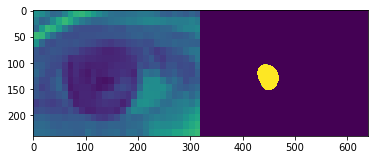

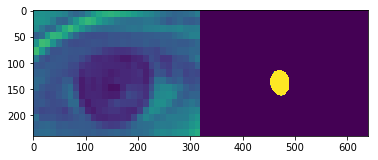

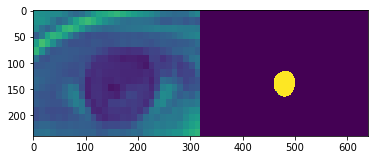

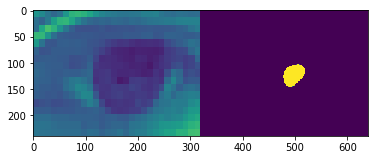

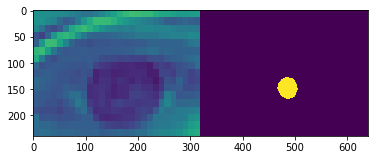

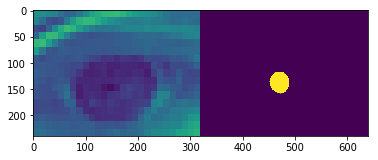

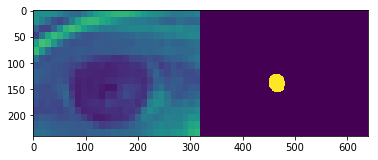

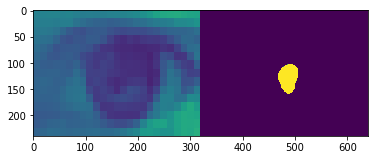

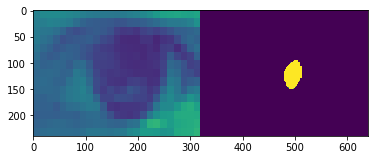

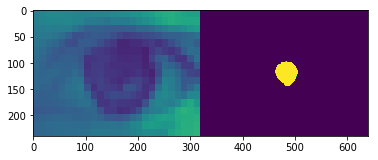

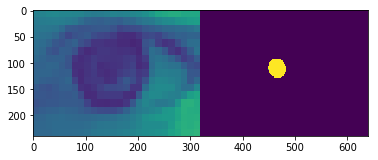

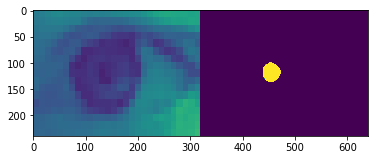

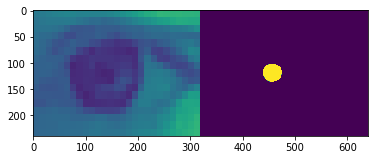

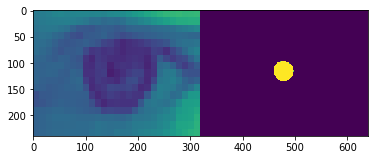

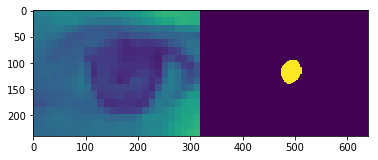

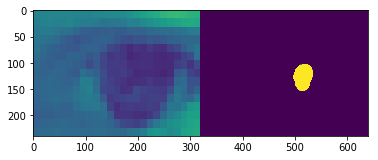

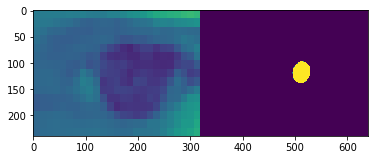

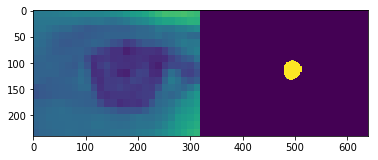

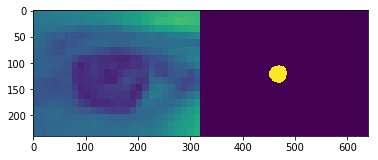

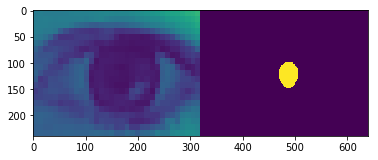

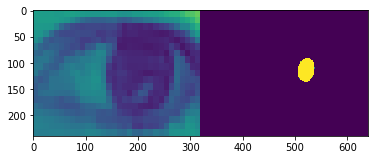

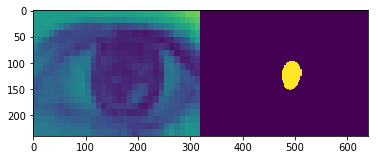

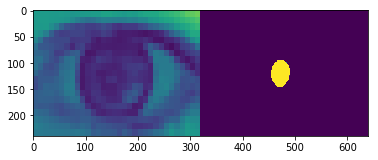

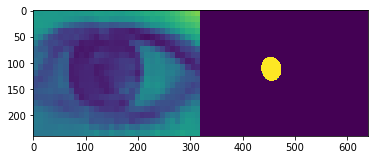

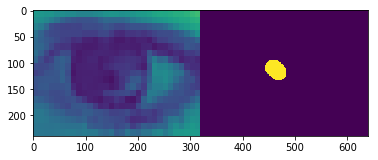

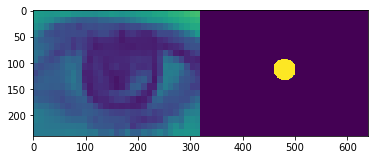

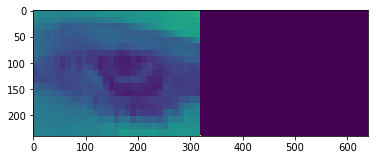

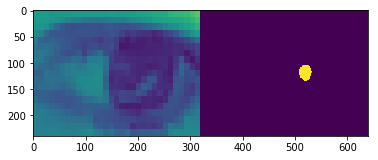

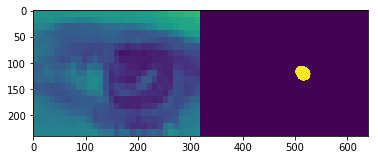

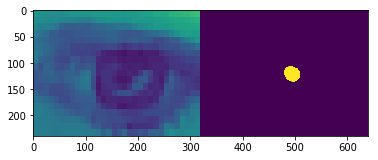

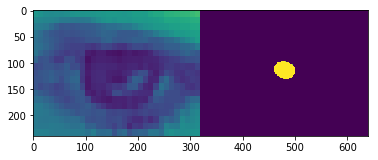

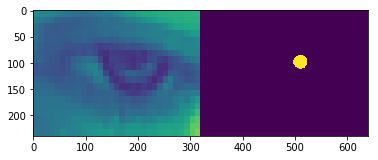

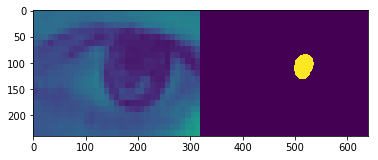

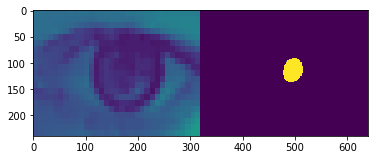

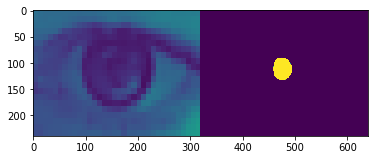

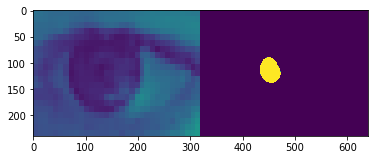

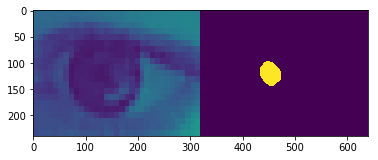

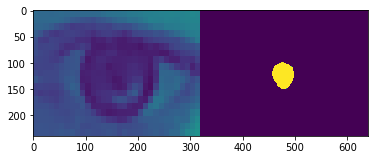

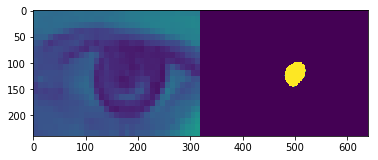

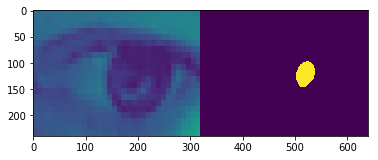

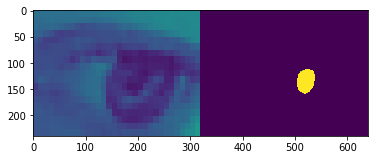

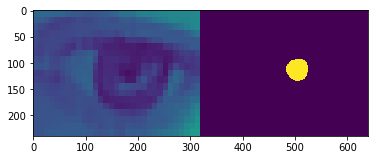

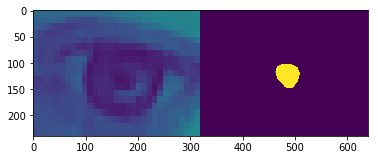

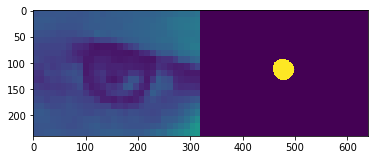

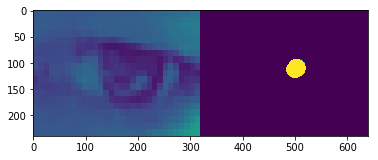

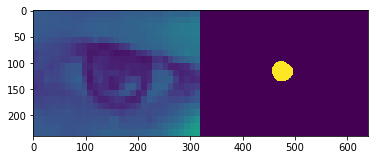

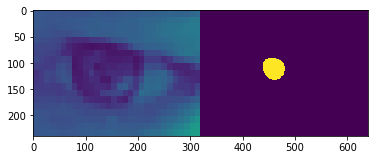

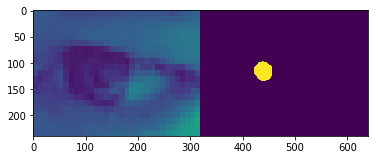

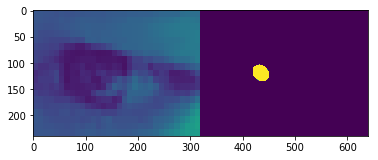

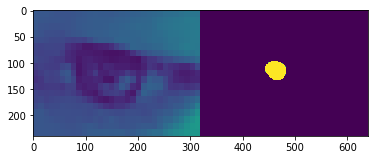

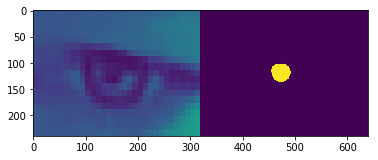

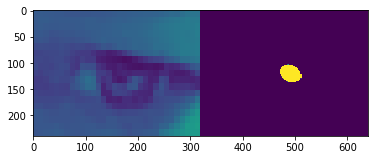

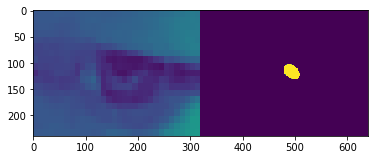

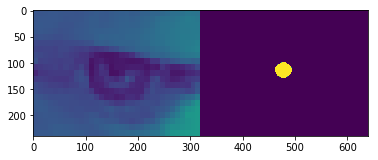

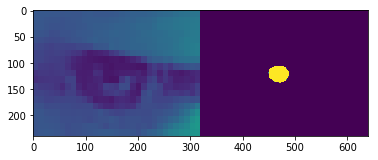

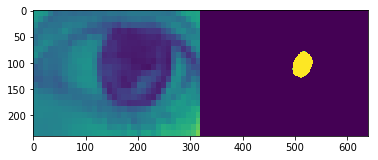

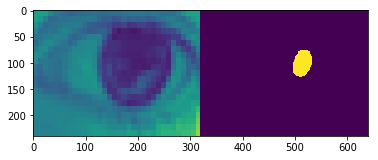

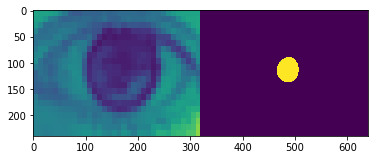

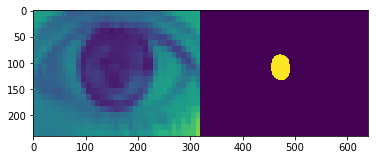

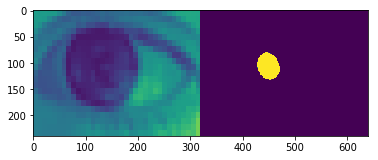

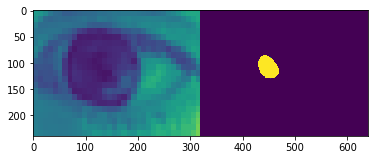

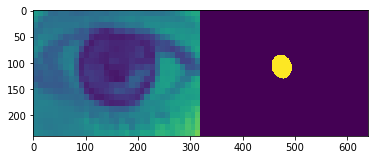

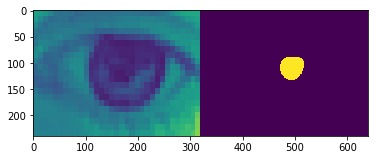

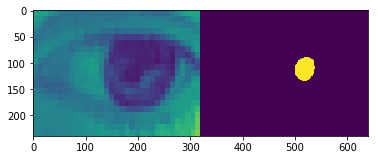

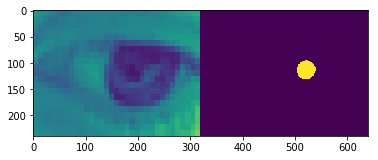

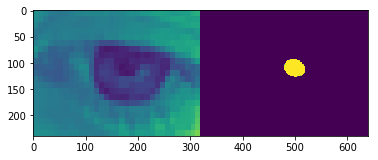

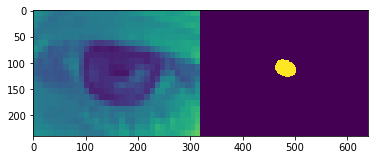

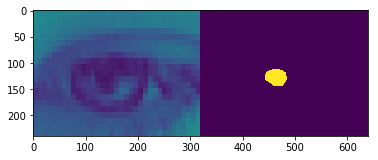

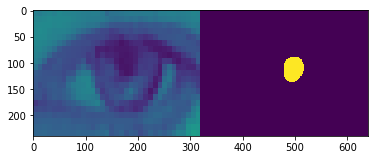

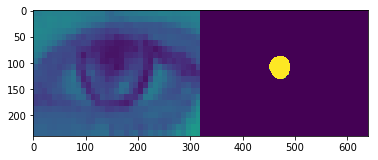

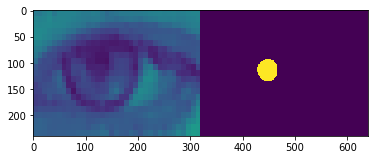

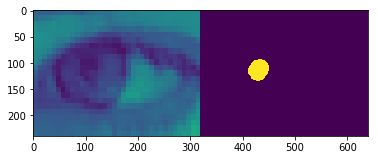

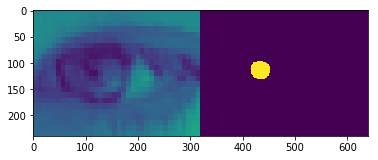

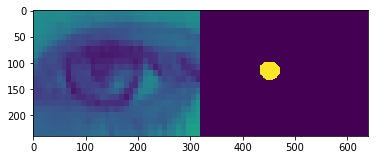

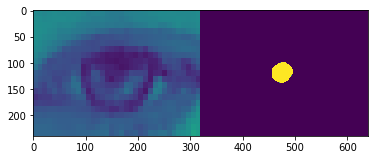

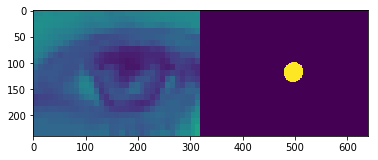

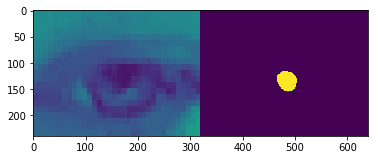

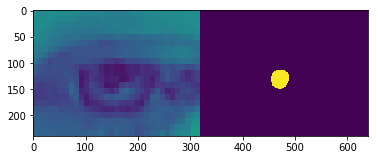

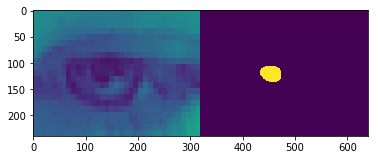

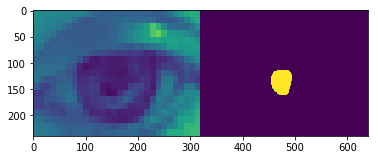

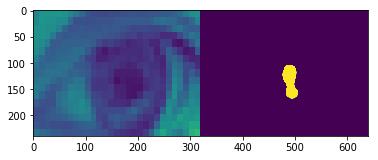

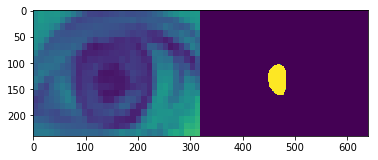

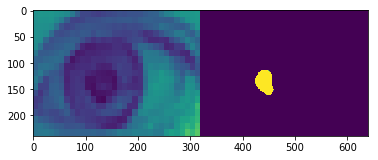

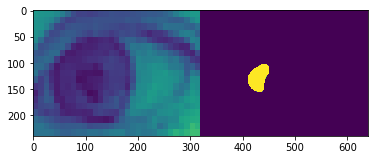

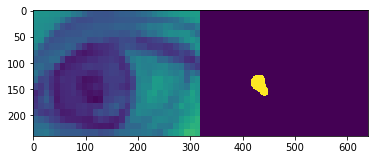

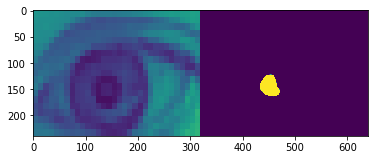

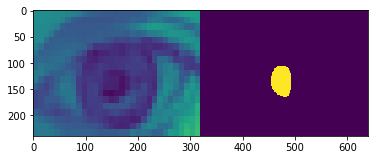

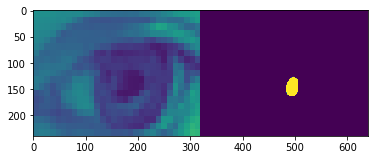

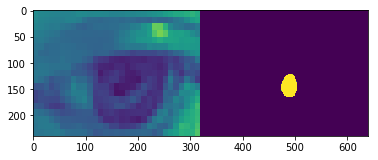

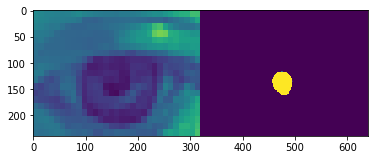

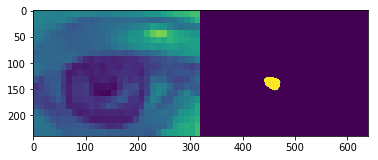

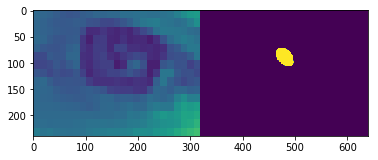

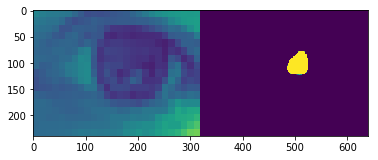

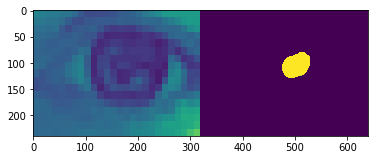

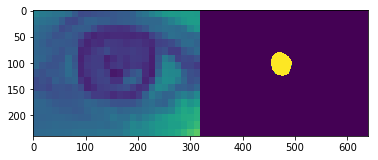

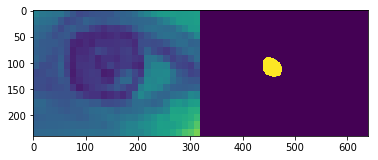

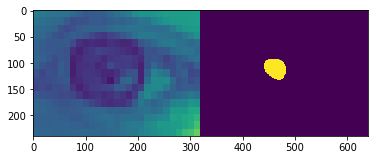

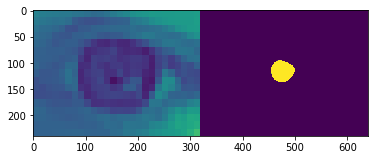

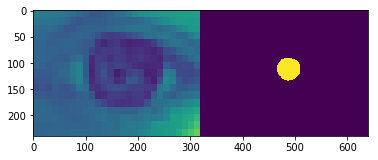

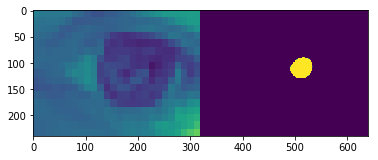

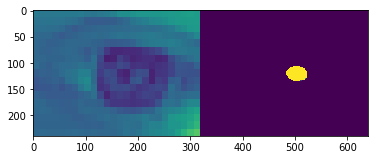

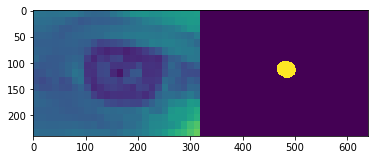

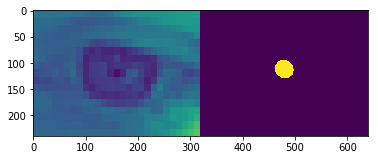

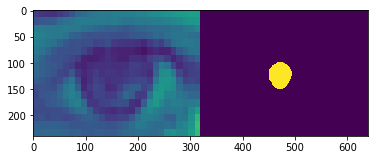

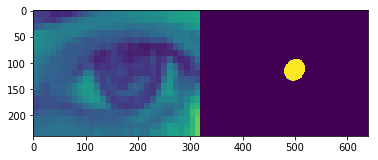

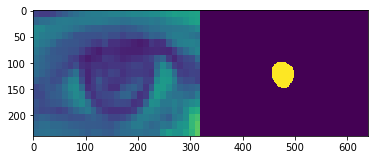

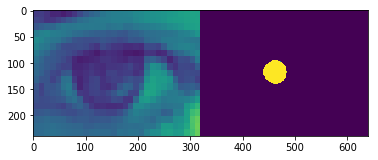

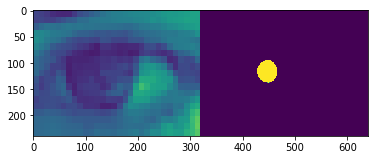

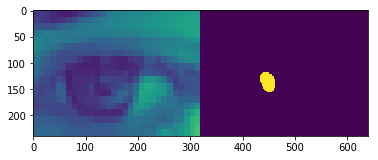

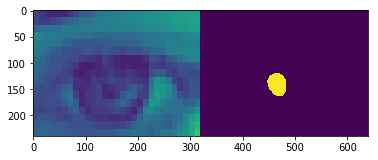

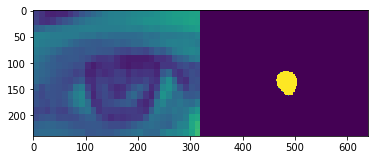

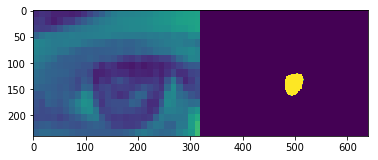

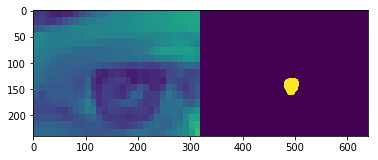

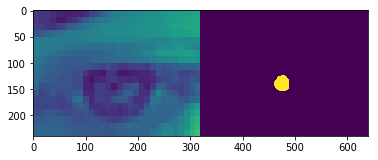

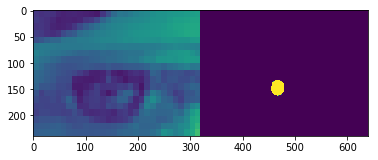

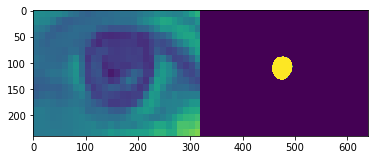

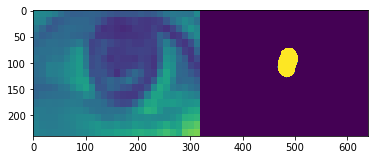

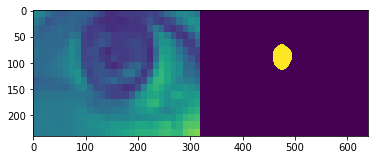

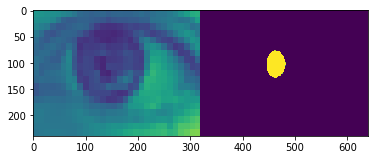

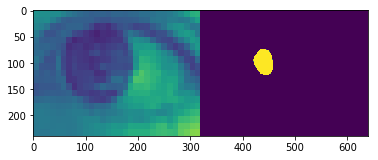

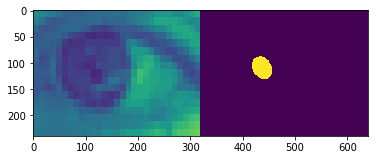

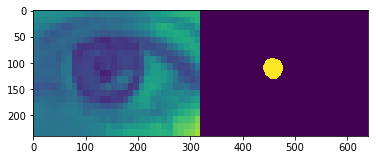

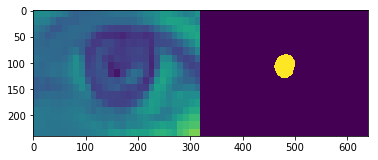

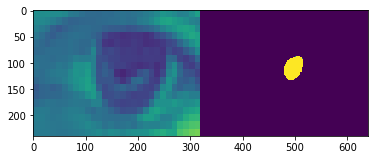

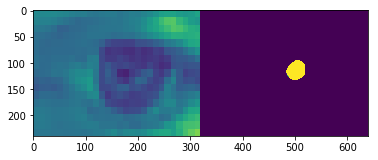

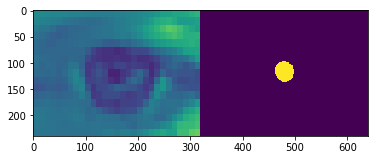

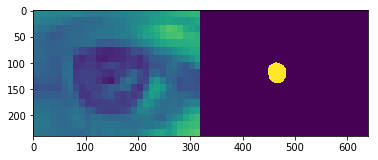

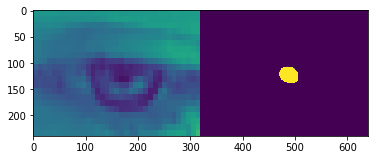

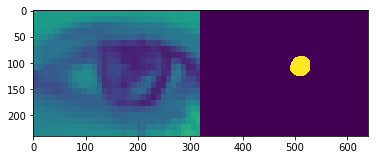

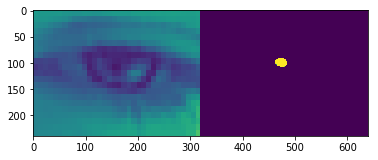

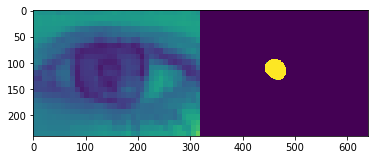

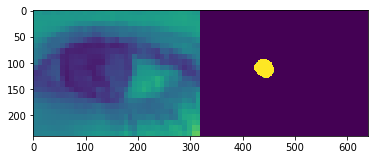

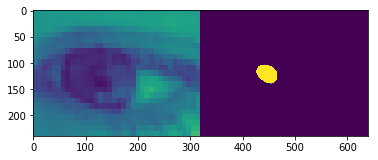

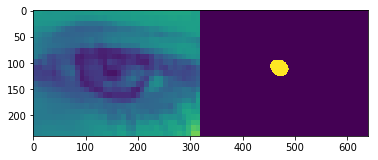

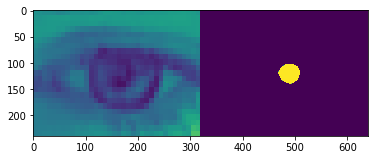

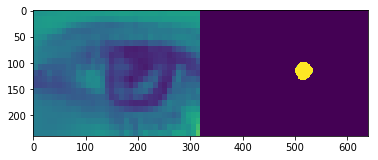

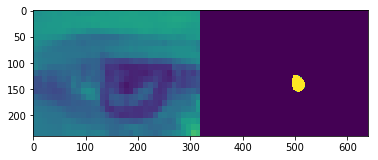

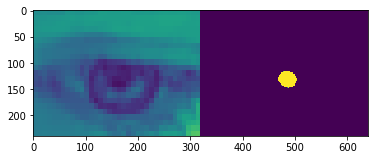

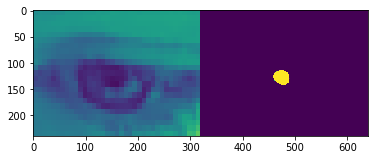

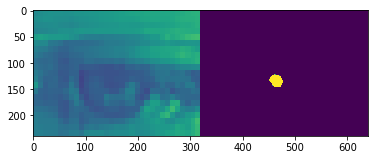

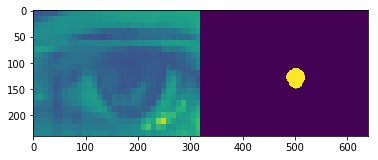

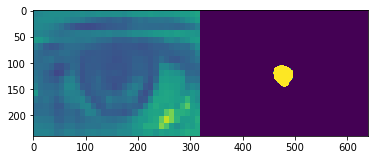

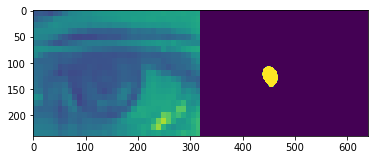

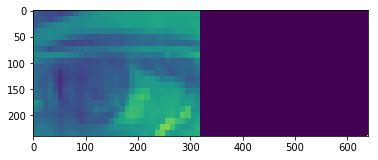

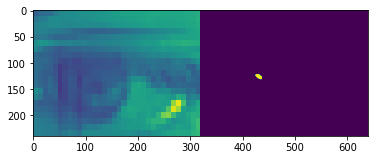

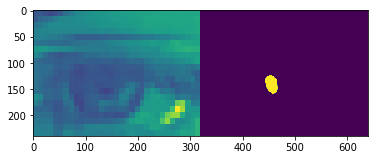

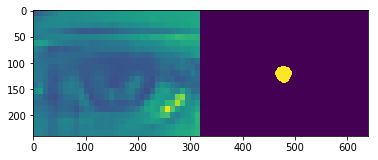

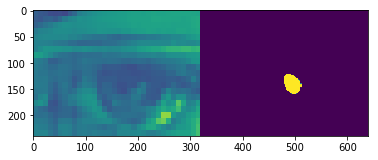

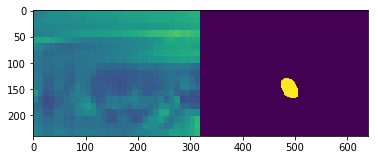

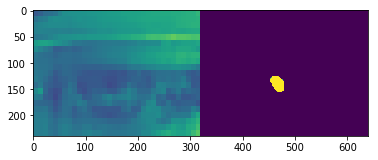

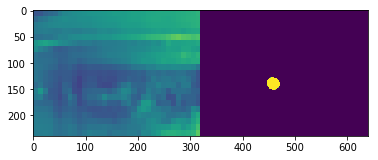

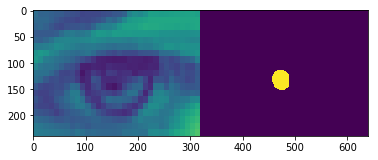

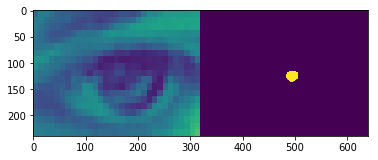

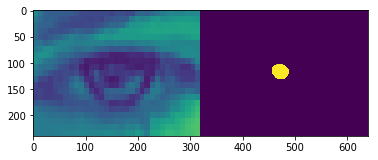

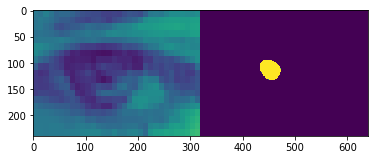

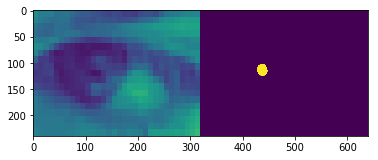

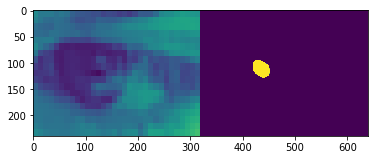

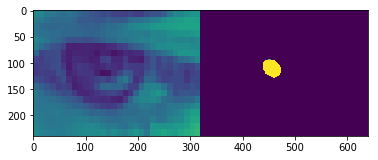

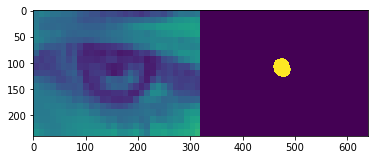

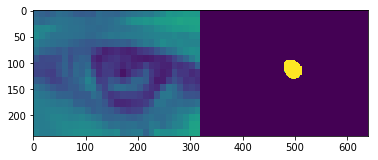

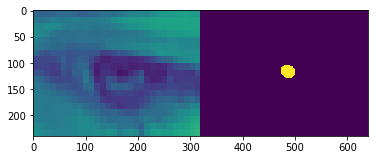

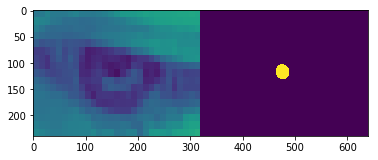

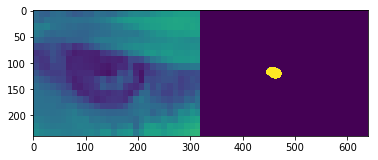

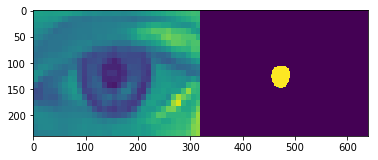

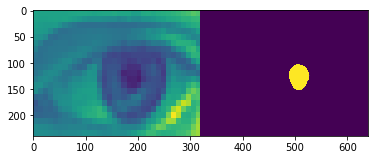

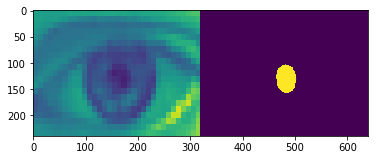

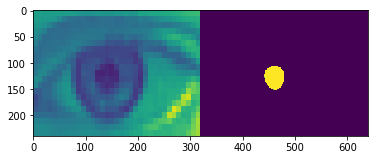

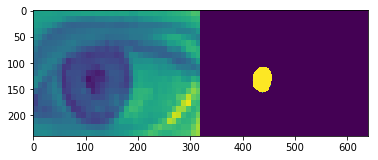

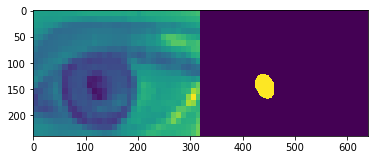

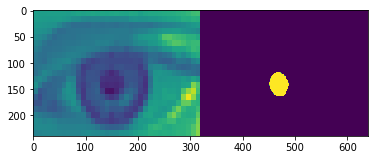

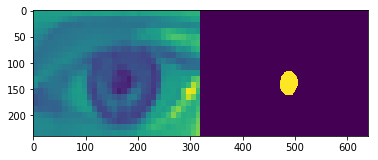

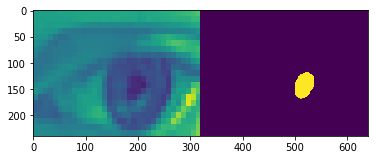

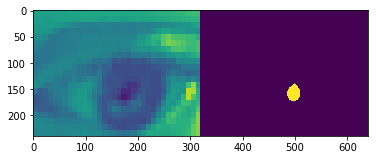

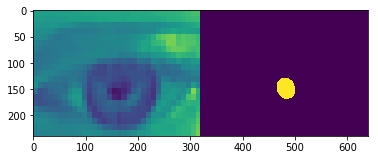

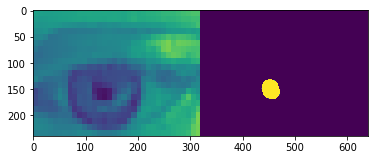

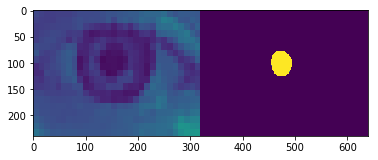

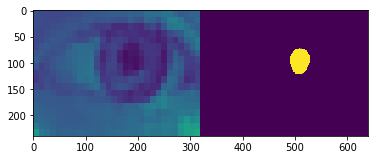

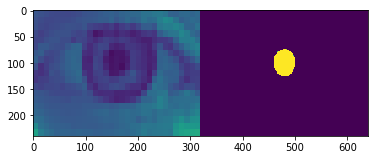

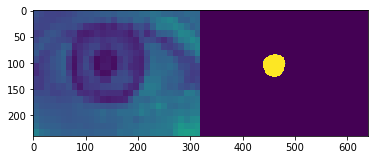

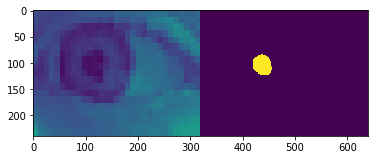

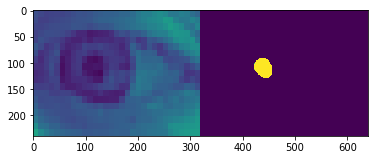

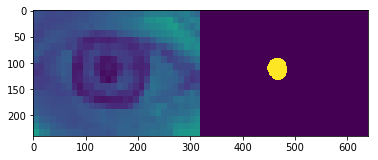

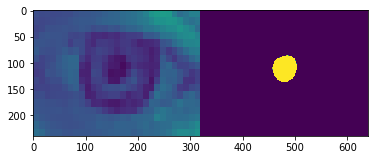

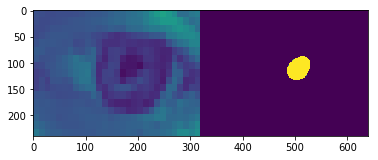

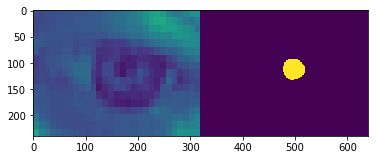

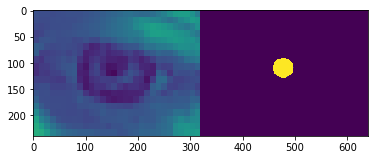

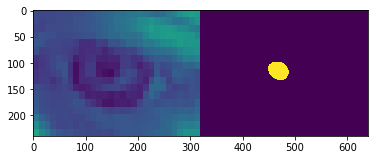

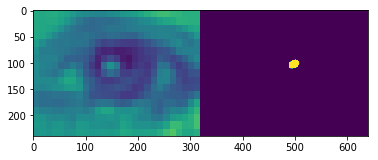

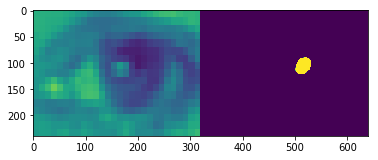

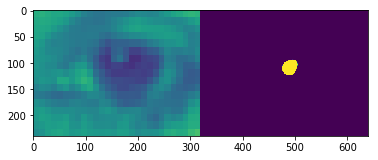

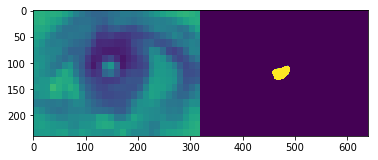

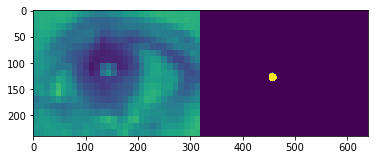

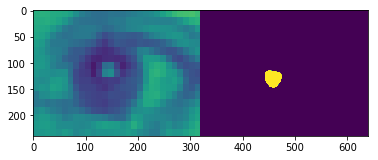

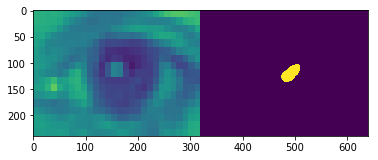

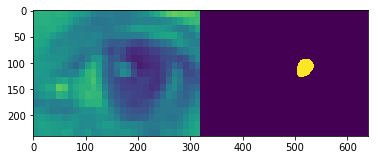

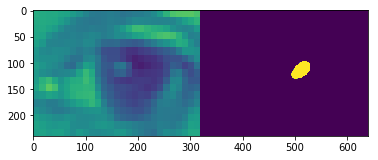

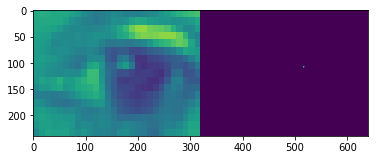

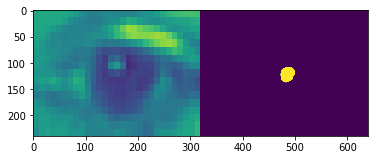

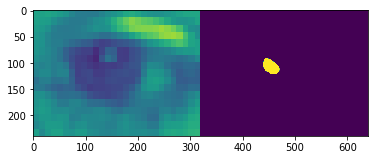

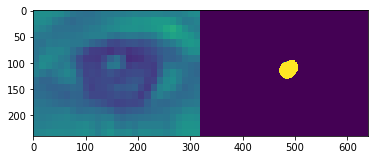

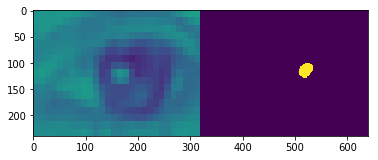

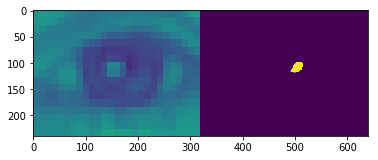

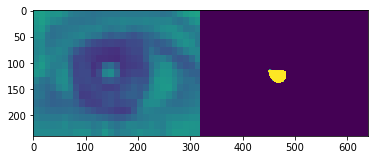

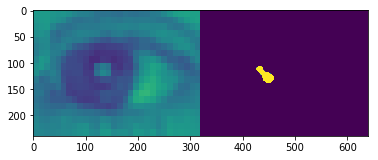

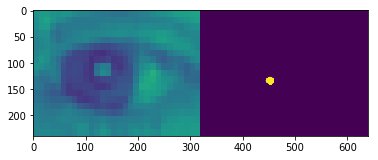

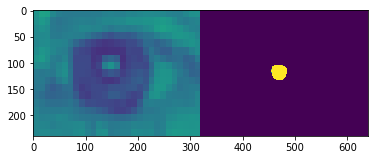

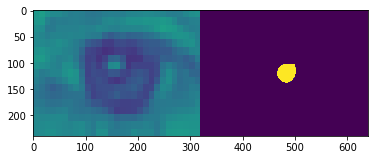

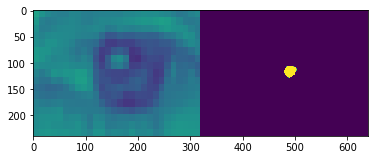

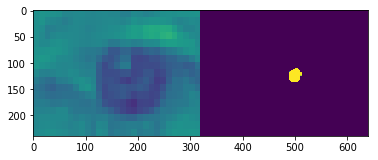

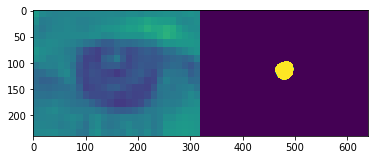

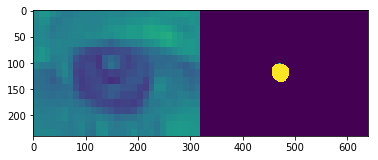

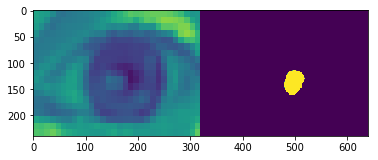

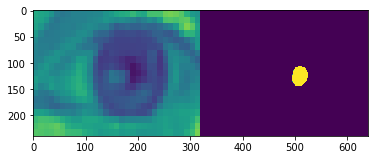

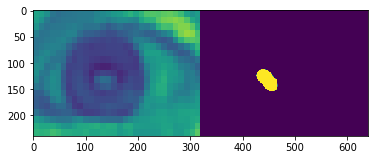

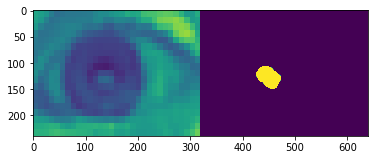

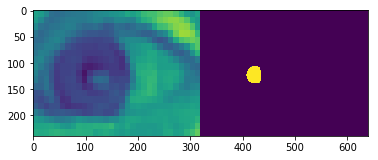

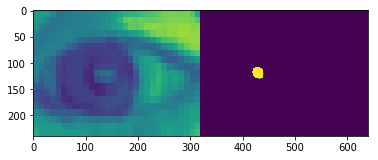

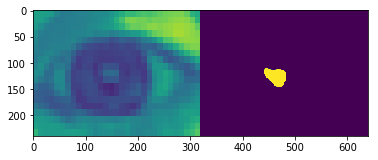

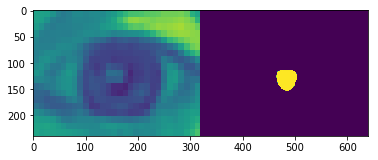

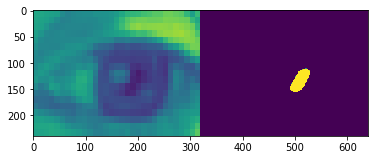

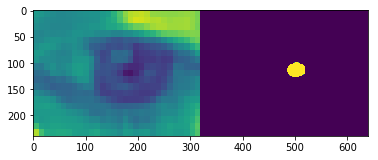

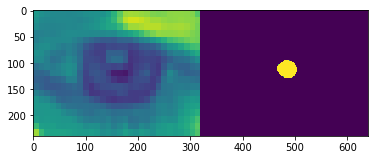

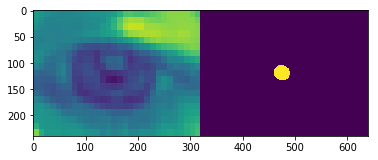

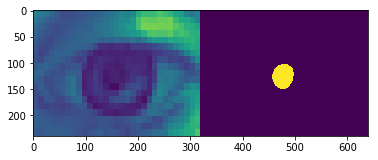

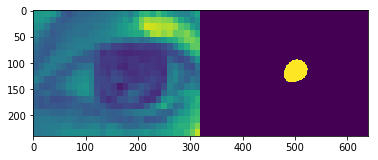

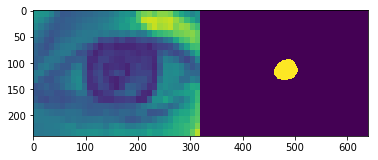

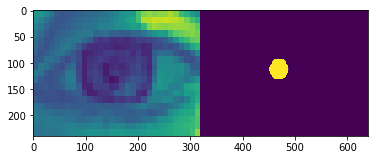

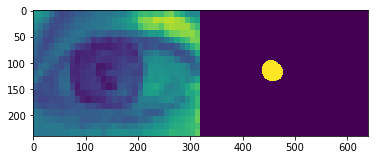

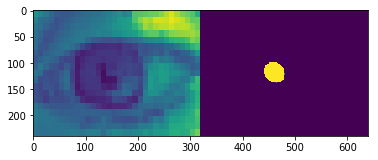

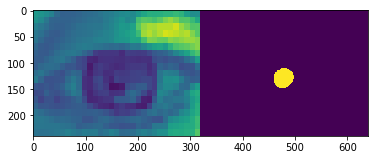

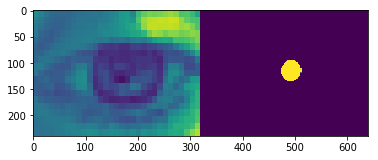

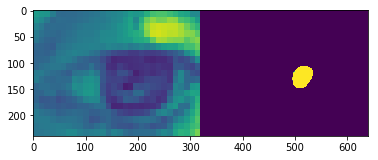

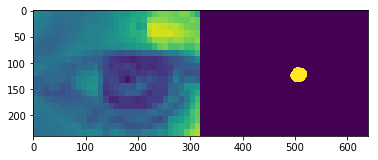

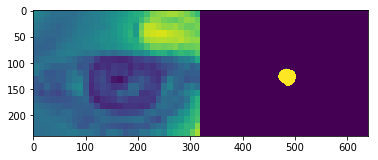

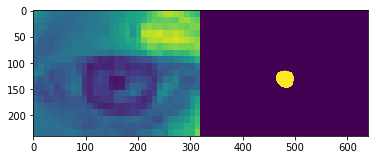

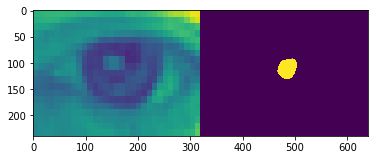

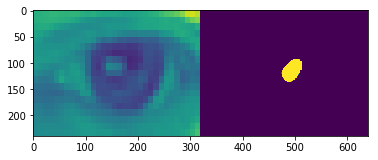

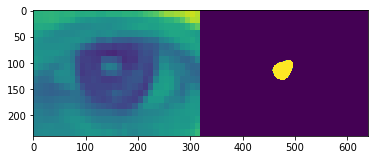

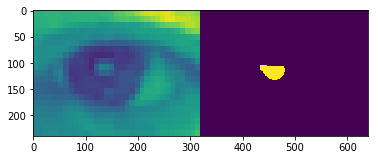

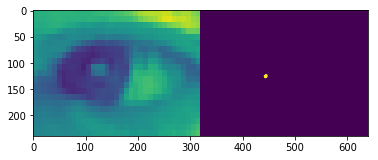

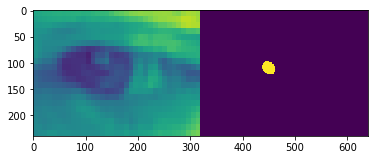

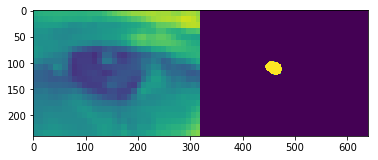

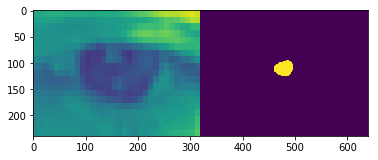

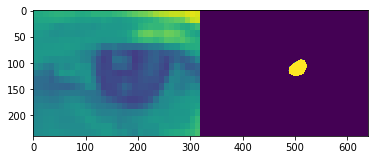

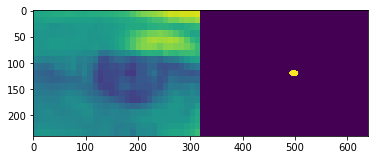

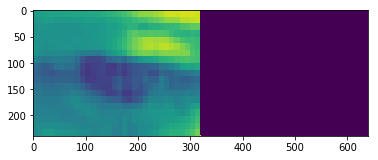

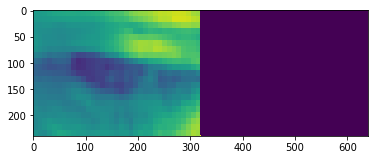

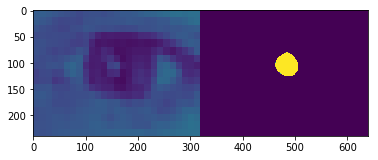

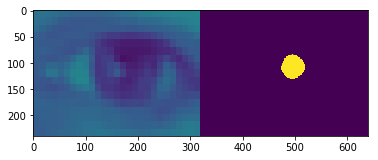

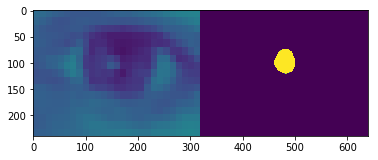

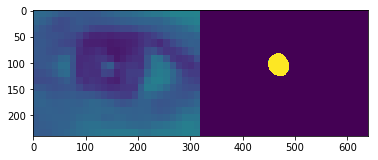

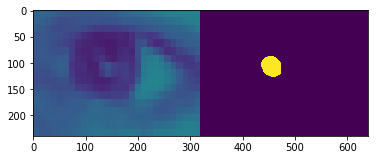

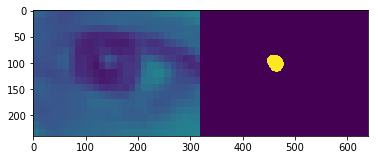

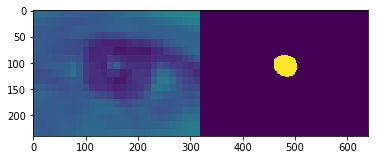

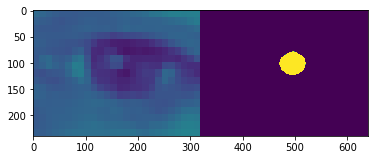

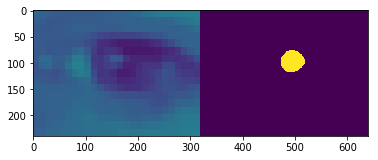

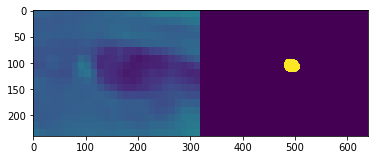

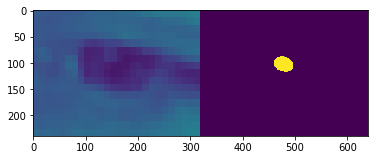

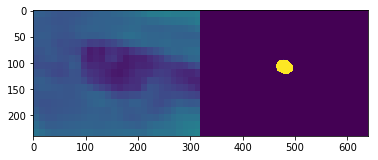

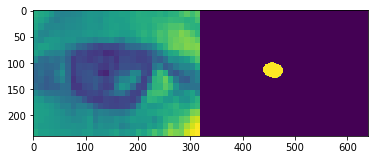

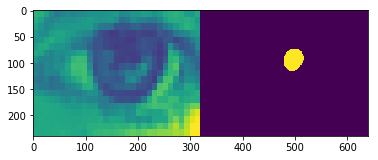

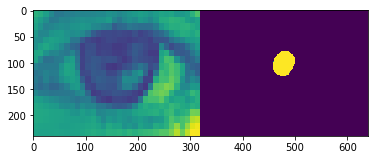

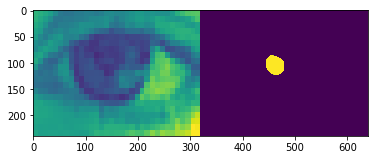

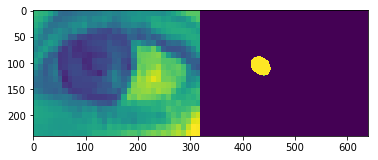

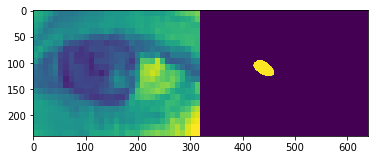

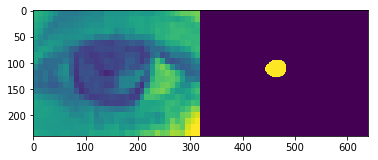

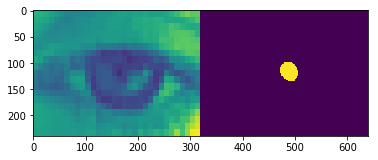

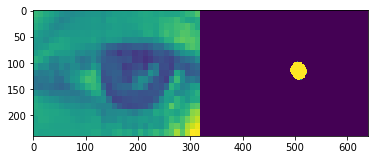

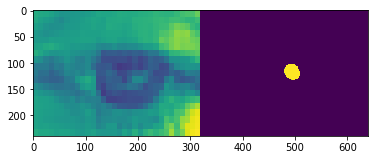

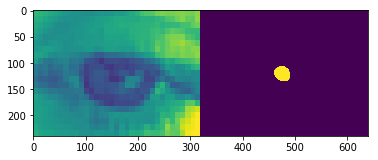

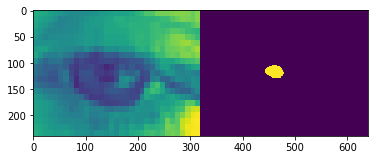

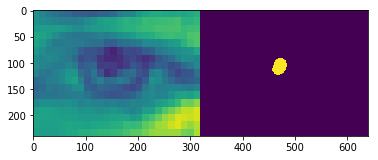

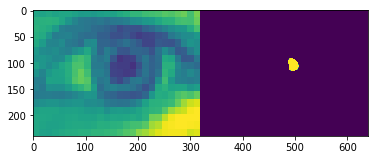

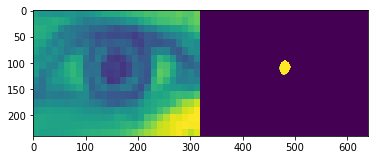

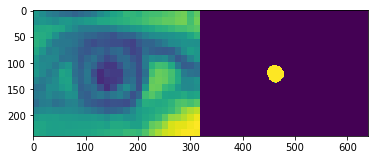

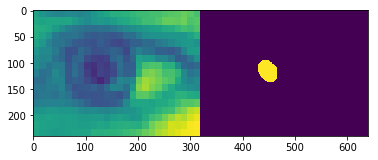

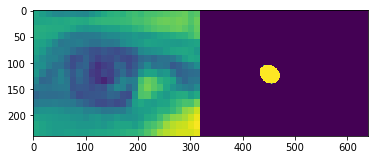

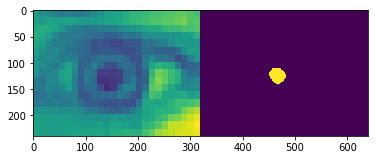

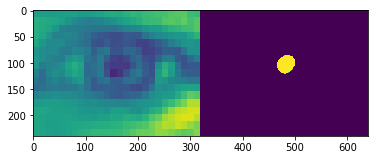

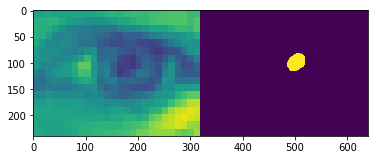

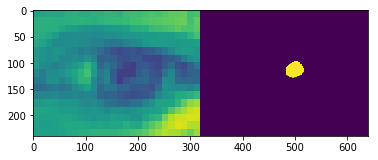

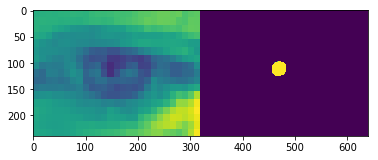

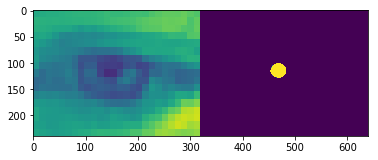

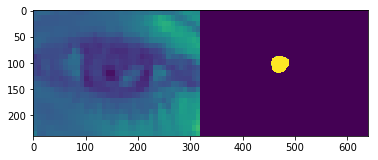

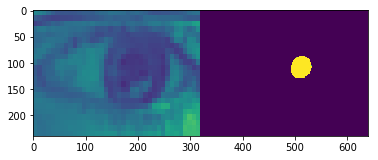

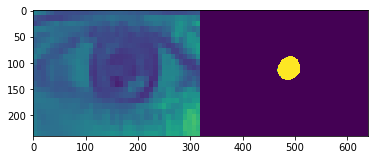

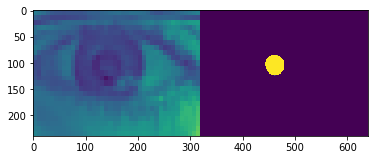

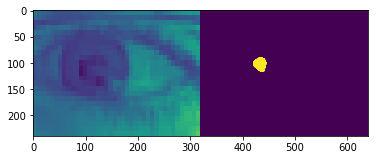

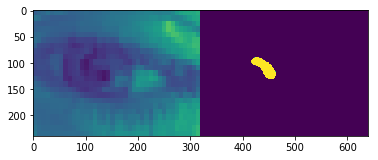

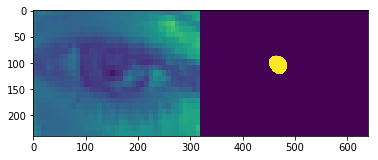

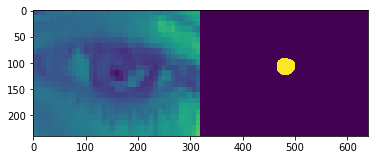

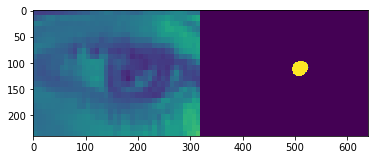

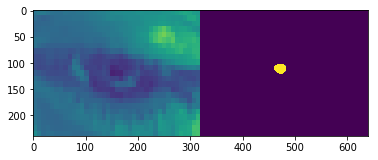

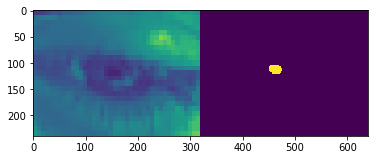

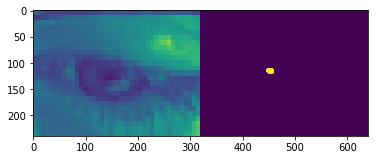

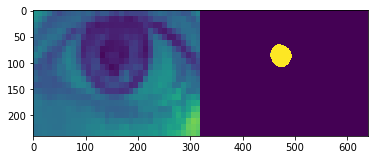

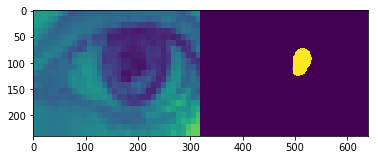

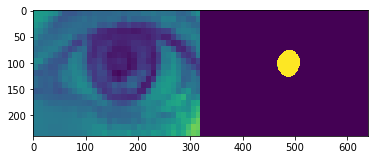

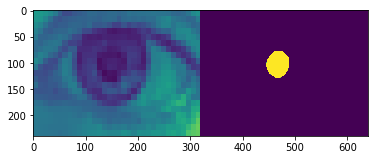

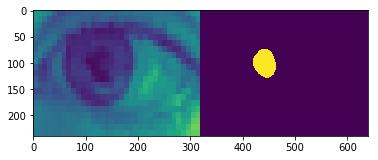

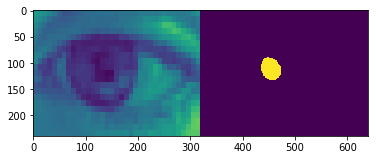

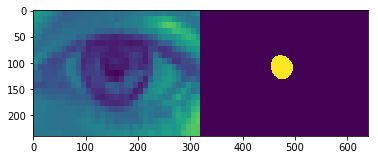

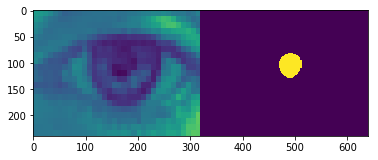

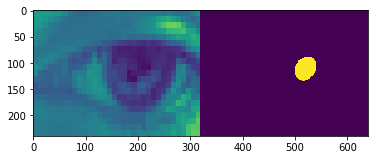

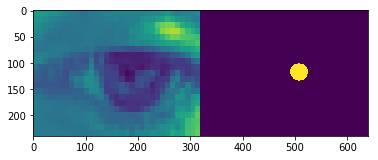

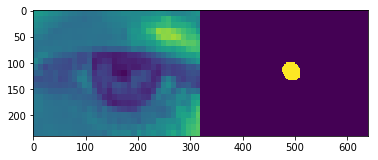

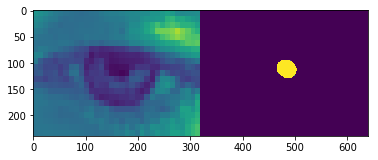

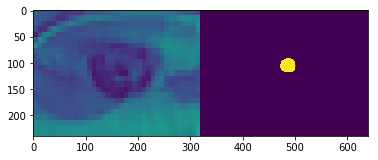

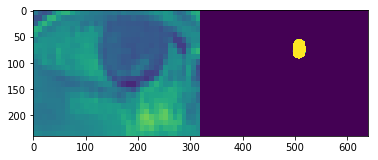

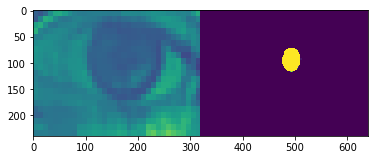

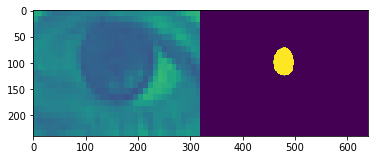

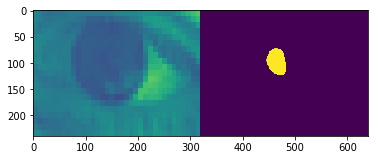

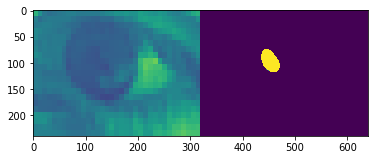

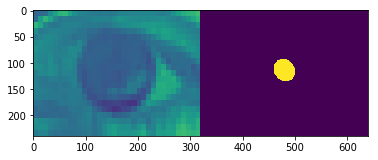

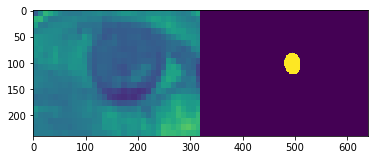

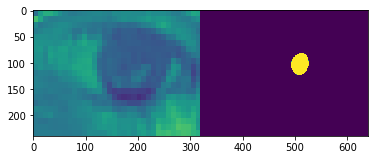

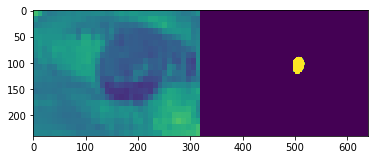

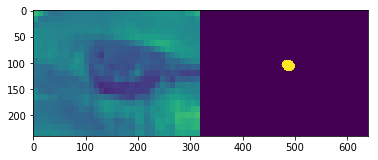

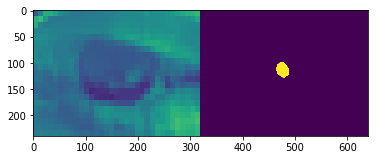

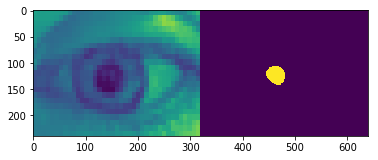

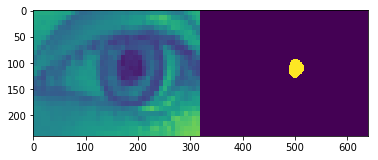

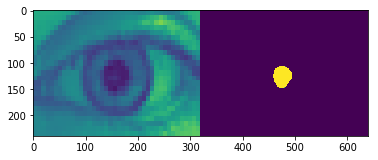

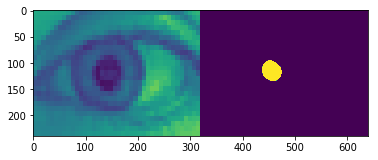

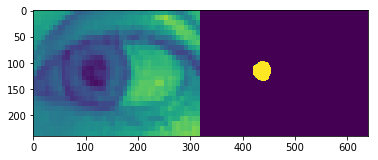

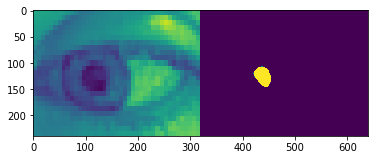

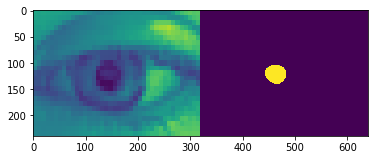

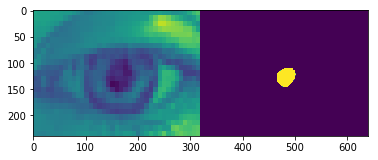

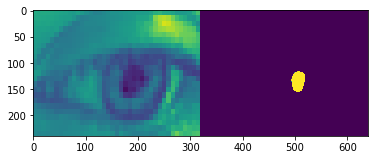

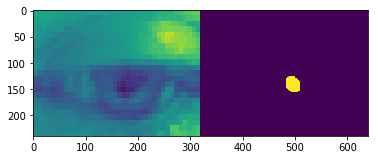

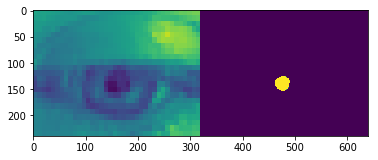

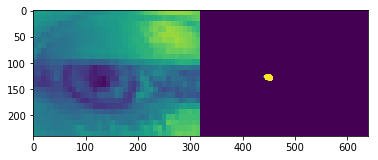

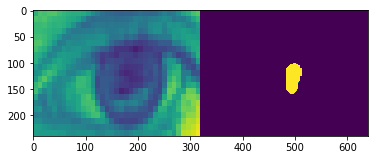

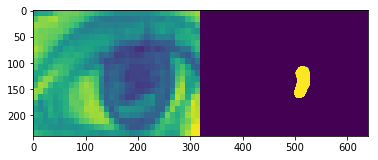

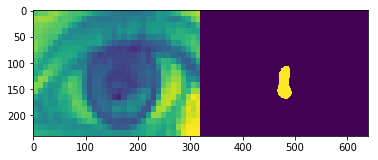

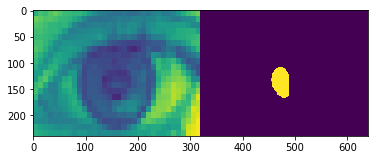

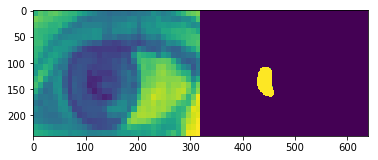

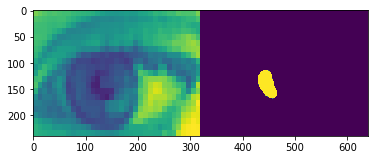

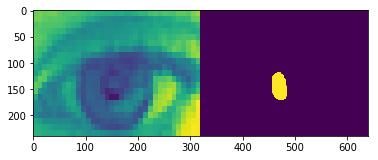

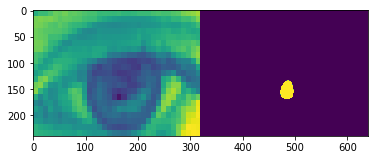

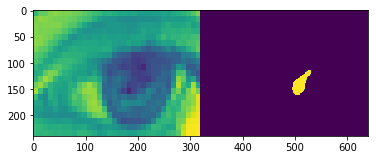

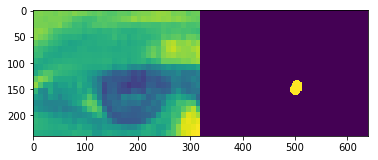

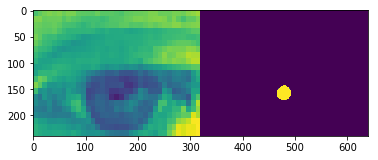

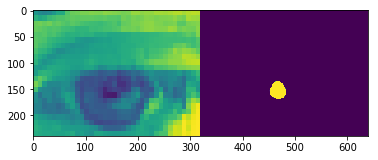

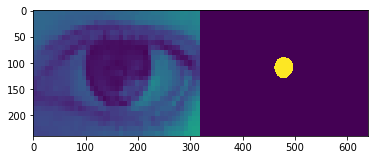

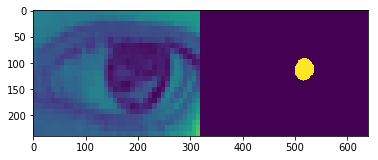

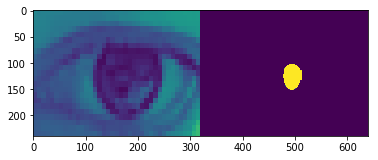

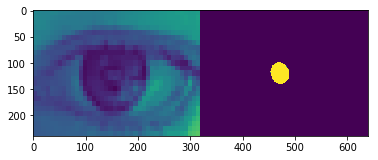

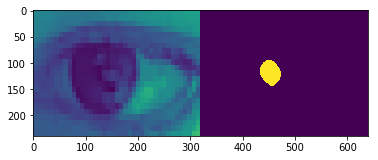

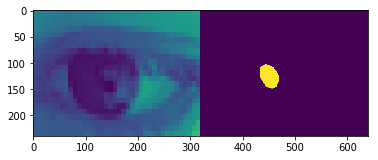

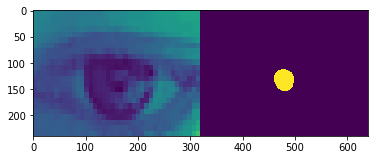

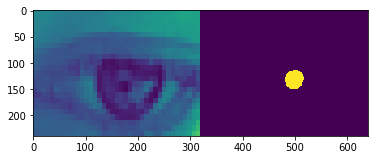

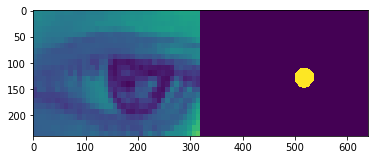

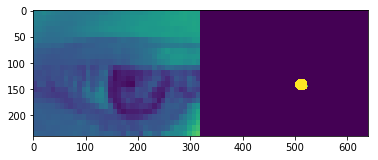

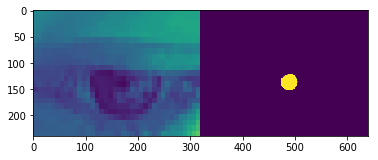

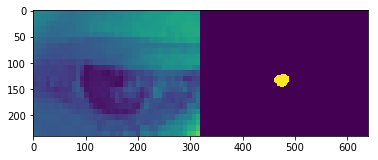

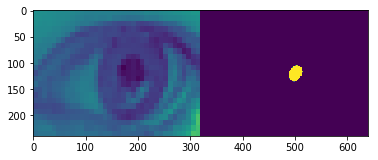

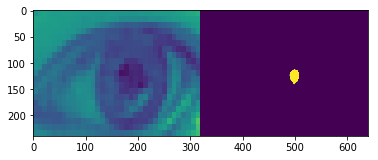

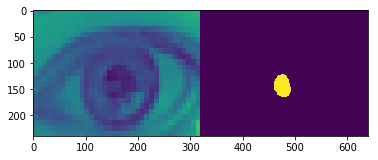

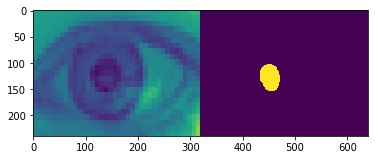

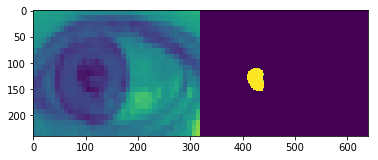

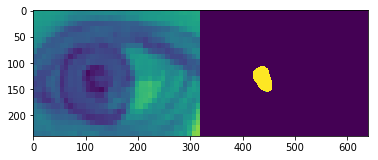

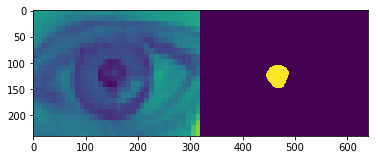

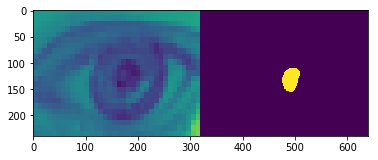

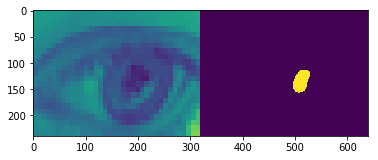

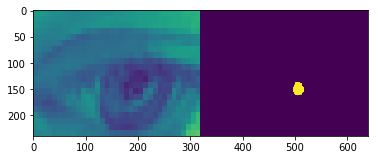

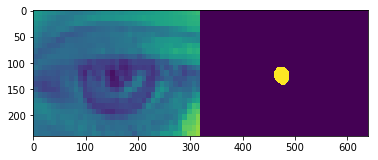

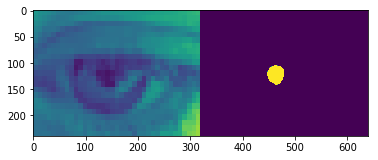

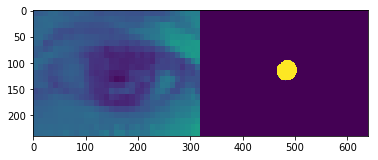

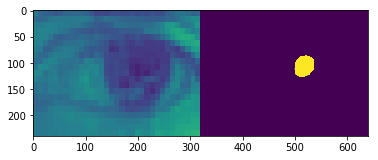

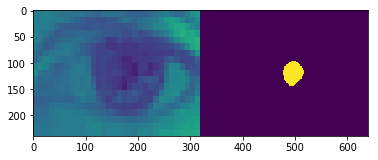

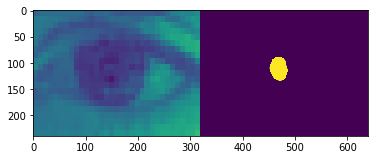

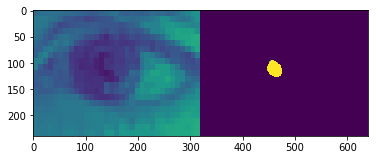

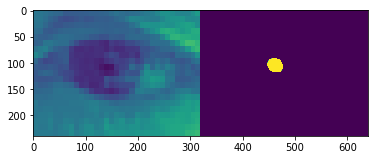

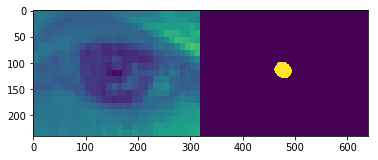

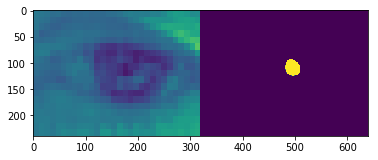

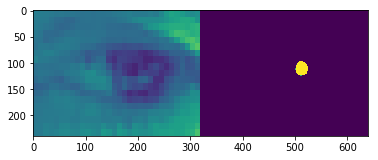

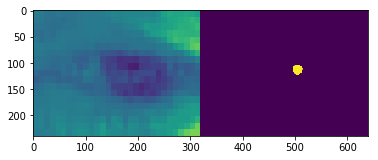

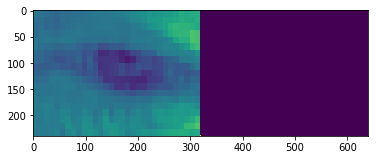

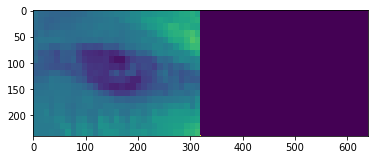

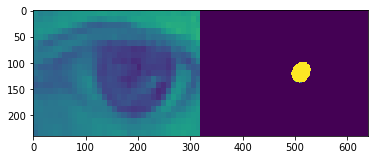

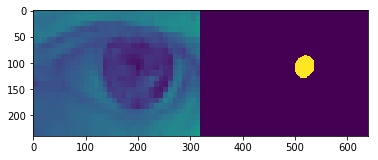

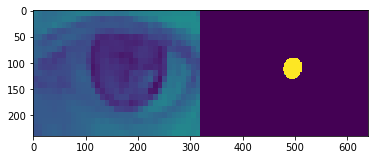

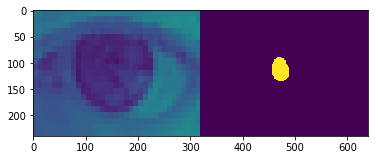

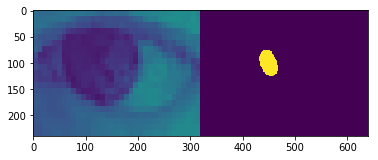

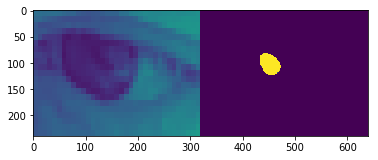

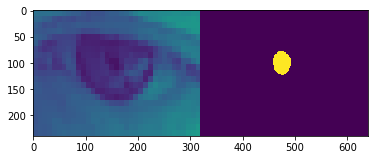

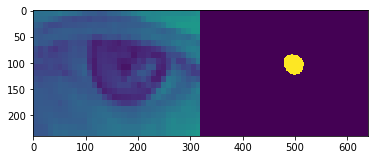

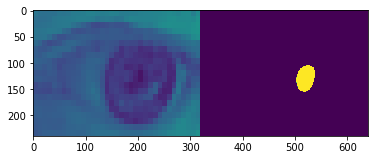

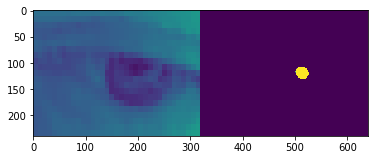

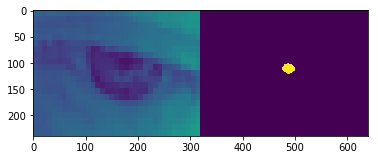

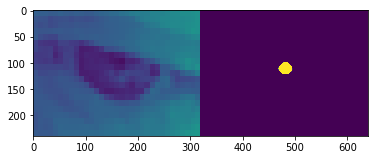

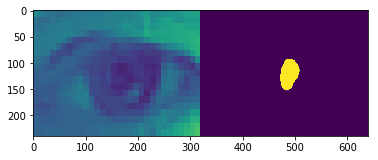

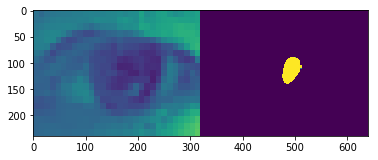

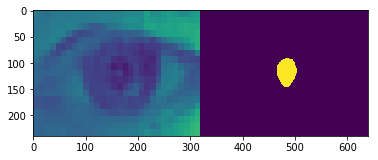

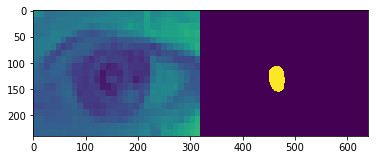

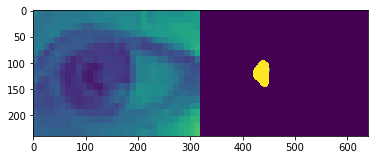

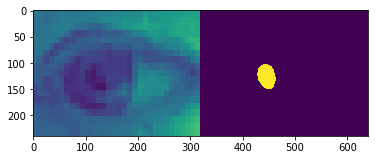

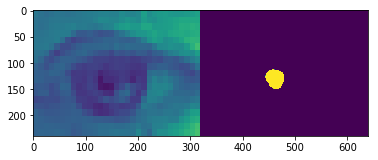

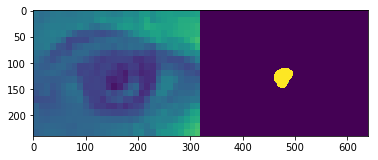

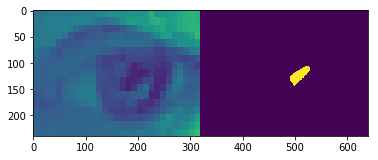

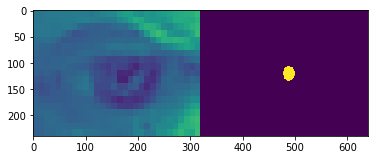

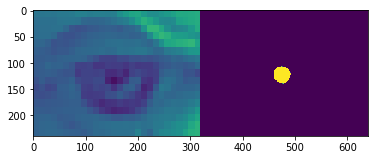

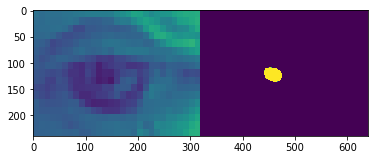

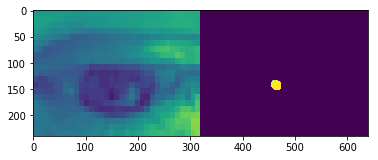

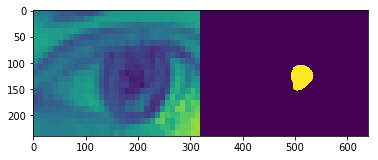

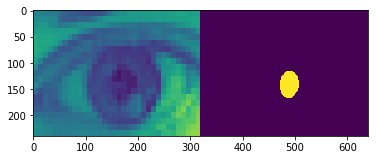

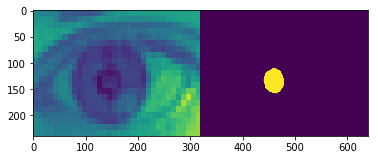

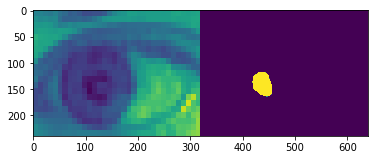

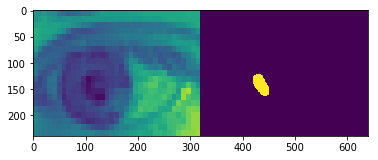

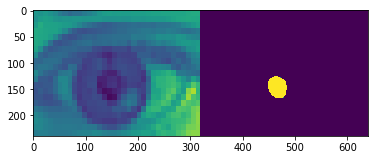

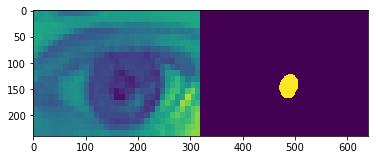

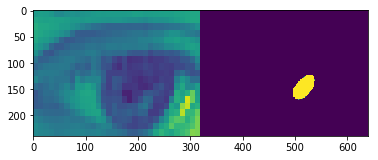

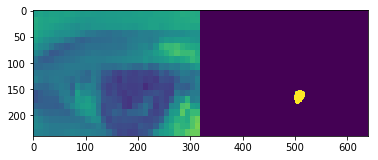

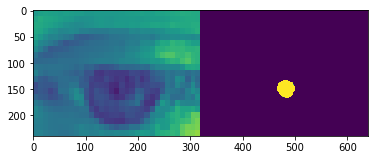

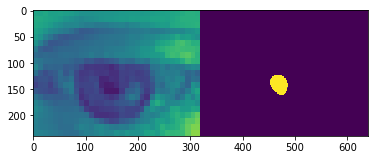

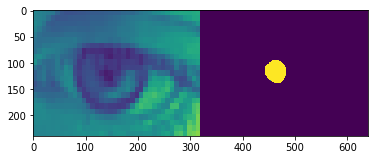

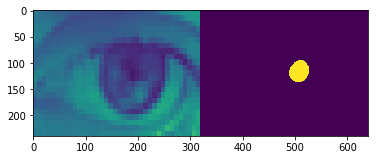

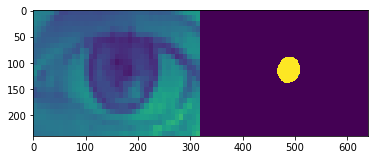

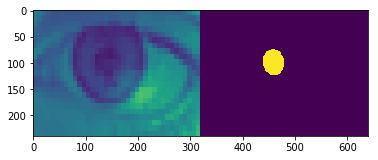

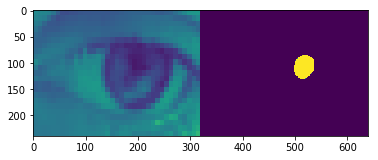

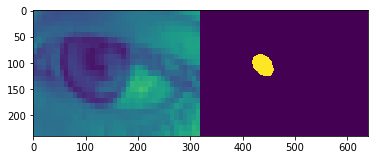

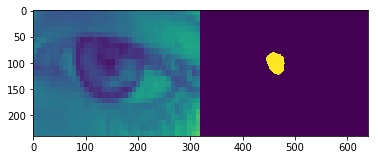

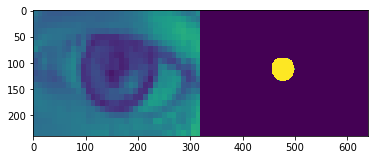

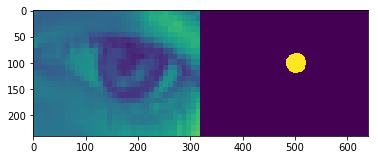

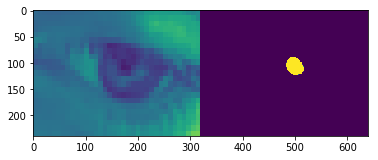

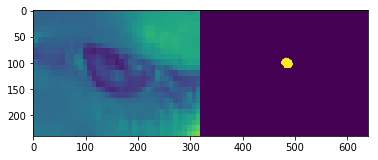

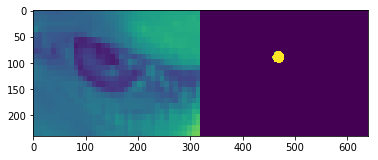

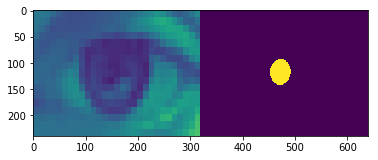

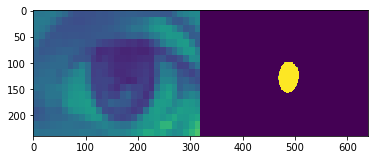

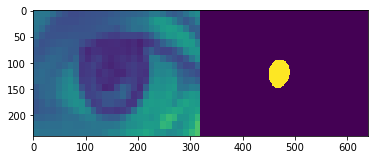

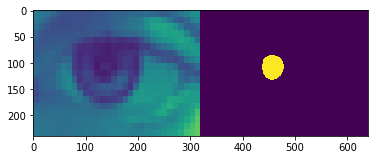

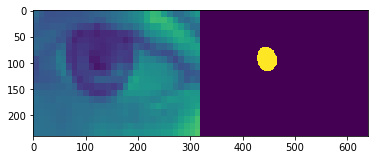

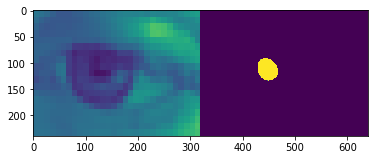

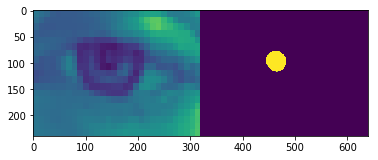

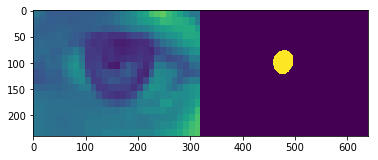

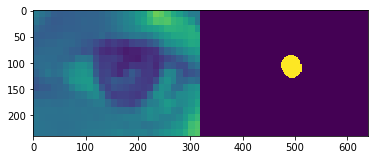

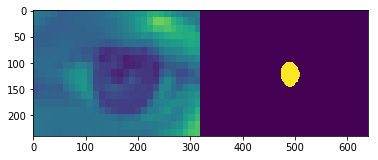

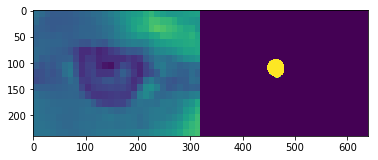

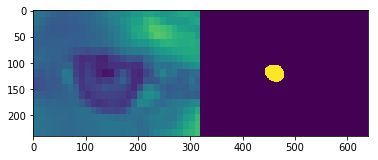

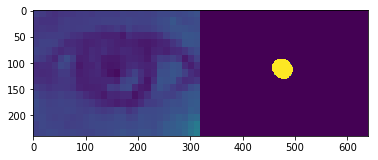

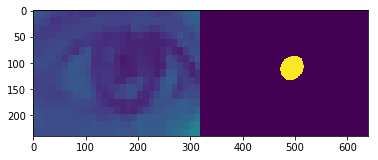

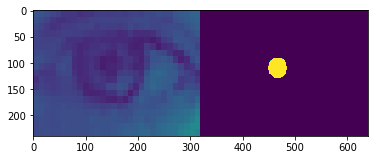

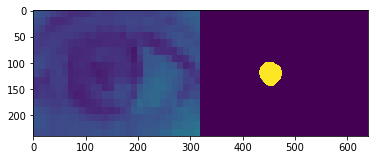

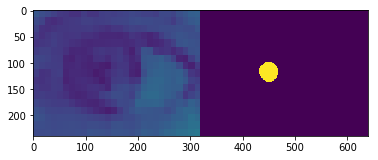

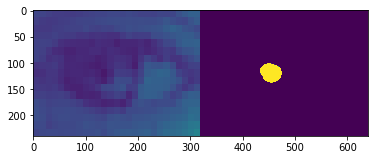

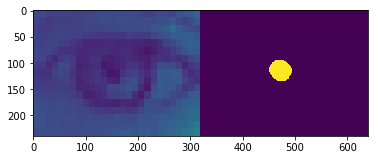

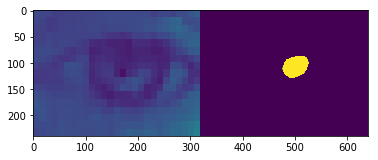

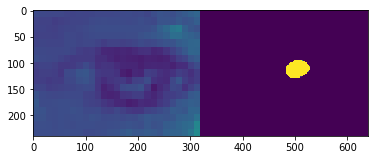

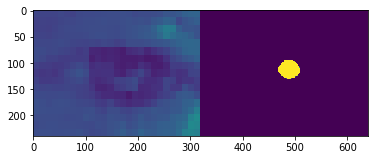

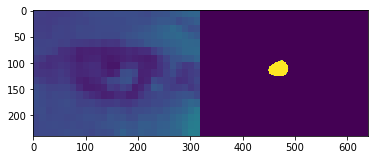

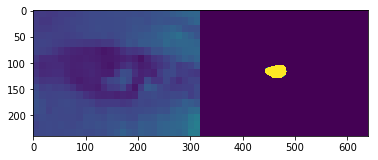

200: Dice eval av. : nan


/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
    n = 0
    dice_eval = []

    for i in range(len(fpaths_xs_test)):
        # テスト画像
        im1 = Image.open(fpaths_xs_test[i])
        im1 = im1.resize((320,240)) 
        # 出力結果
        im2 = Image.open(os.path.join(dname_outputs, "%05d.png"%(n)))
        im2 = im2.resize((320,240))
        # Grond Truth
        plt.imshow(np.hstack((np.array(im1),np.array(im2))))
        plt.show()
        n = n + 1
    
    print('%d: Dice eval av. : %f'%(epoch,np.mean(np.array(dice_eval))))